In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# Phần code này dựa trên bài viết này
# https://www.sciencedirect.com/science/article/pii/S1877050919302789

# Import the libraries

In [3]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [4]:
# Hàm vẽ mô hình miêu tả giá trị từng thuộc tính
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [5]:
# Hàm thêm cột giá trị Ma, là đường trung bình động (Moving Average) của biến giá trị Close
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [6]:
# Class này kế thừa class TimeseriesGenerator
# Nó tạo ra các batch dữ liệu được chuẩn hóa (standarized)
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [7]:
# Giải thích các thông số đầu vào của class TimeseriesGenerator
# Data: Những dữ liệu liên tiếp nhau (axis 0 được kì vọng là time dimension)
# Target: Dữ liệu tương ứng với những timesteps trong data
# Length: Độ dài của các sequences đầu vào (Hay window, look-back)
# sampling_rate: Chu kỳ của các timestep input được lấy (VD: sampling_rate=2 
# thì cách 2 ngày lấy một lần)
# stride: Chu kỳ của các timestep output được lấy (VD: stride=2 
# thì cách 2 ngày lấy một lần, hay chú Sơn nói là số bước mà cửa sổ trượt)
# start_index, end_index: Khoảng dữ liệu được dùng
# bacth_size: số lượng samples 1 batch
# ([day1, day2, day3],[day4]) là 1 sample
# [([day1, day2, day3],[day4]), ([day2, day3, day4],[day5])] là 1 batch có 
# batch_size là 5
################Xét ví dụ sau############
# from keras.preprocessing.sequence import TimeseriesGenerator
# import numpy as np
# data = np.array([[i] for i in range(50)])
# targets = np.array([[i] for i in range(50)])
# data_gen = TimeseriesGenerator(data, targets,
#                                length=10, sampling_rate=2,
#                                batch_size=2)
# assert len(data_gen) == 20
# batch_0 = data_gen[0]
# x, y = batch_0
# assert np.array_equal(x,
#                       np.array([[[0], [2], [4], [6], [8]],
#                                 [[1], [3], [5], [7], [9]]]))
# assert np.array_equal(y,
#                       np.array([[10], [11]]))
# ==>length=10 nên những dữ liệu được pick cho input có index 0->9
# Và dữ liệu đầu tiên cho output có index là 10
# sampling_rate bằng 2 nên (index thứ i) - (index thứ i - 1) = 2
# Batch_size=2 --> Mỗi batch có 2 sample mà có 41 samples --> Có 21 batches

def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.8)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [8]:
# Hàm dùng để tính mean squared error cho generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
# Các hàm tính metrics từ 2 tập thực tế và dự đoán.
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
# Vì Discriminator trong bài toán này chỉ có hai giá trị đầu ra (giống/ không giống) nên dùng hàm phân loại nhị phân
# Tìm hiểu Binary Cross Entropy là gì tại đây:
# https://ndquy.github.io/posts/loss-function-p2/#:~:text=Binary%20Cross%2DEntropy%20Loss,tr%E1%BB%8B%20%7B0%2C%201%7D.
# Cross-entropy là hàm loss được sử dụng mặc định cho bài toán phân lớp nhị phân.
# Nó được thiết kế để sử dụng với bài toán phân loại nhị phân trong đó các giá trị mục tiêu nhận một trong 2 giá trị {0, 1}.
# Trang 402
def discriminator_loss(real_output, fake_output):
    # So sách kết quả dự đoán như thể nào với 1 (đúng) (real_loss)
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    # So sách kết quả dự đoán như thể nào với 1 (đúng) (real_loss)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    # Giá trị mất mát của Generator
    total_loss = real_loss + fake_loss
    return total_loss
# https://www.sciencedirect.com/science/article/pii/S1877050919302789
# Trang 403
def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse


## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    # return_sequences = True, Trả về cho lớp sau các điểm đầu ra trước đó thay vì chỉ các điểm đầu ra ở lớp cuối cùng
    # Trong mạng neural học sâu, kernel_initializer là một tham số được sử dụng để khởi tạo trọng số (weights) của các lớp (layer) trong mạng neural.
    lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
    # Batch Normalization là một lớp (layer) được sử dụng trong mạng neural học sâu để chuẩn hóa đầu ra của một lớp trước khi đưa vào lớp kế tiếp
    # Cải thiện "vanishing gradient" và "exploding gradient", đồng thời giúp mô hình hội tụ nhanh hơn
    batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
    batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_droput)
    #  LeakyReLU
    # https://aicurious.io/blog/2019-09-23-cac-ham-kich-hoat-activation-function-trong-neural-networks
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs = inputs, outputs = output)
    model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
    model.summary()

    return model
# Vì sao cần hàm kích hoạt, vì nếu có hàm kích hoạt mà là các lớp nơ ron đơn thuần xếp chồng lên nhau thì kết quả đầu ra đơn 
# là một hàm tuyến tính của giá trị đầu vào --> Việc xếp chồng mà k có hàm kích hoạt là vô nghĩa
# Sigmoid (0,1). Đạo hàm đẹp nhưng dễ bằng 0 (vanishing gradient), không có trung tâm nên hội tụ khó khăn
# tanh (-1,1). Cũng bão hòa hai đầu nhưng có trung tâm (O)
# ReLu max(0, x): Sử dụng khá nhiều gần đây do tốc độ hội tụ nhanh do nó k bị bão hòa 2 đầu
# --> Rectified Linear Unit: đơn vị tuyến tính được hiệu chỉnh
# Tính toán nhanh dO công thức đơn giản
# Nhược điểm là với những node < 0 thù activation chuyển thành 0 (Dying ReLU) (*)
# Leaky ReLU dùng để khắc phục ReLU
# LeakyReLU: f(x) = 1 với x<0 và f(x)=ax + 1 với x>=0 với a nhỏ
# Thay vì trả về 0 với x < 0 thì nó cố gắng tạo ra một đường xiên nhỏ



## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # là một lớp sinh dữ liệu ngẫu nhiên nhằm giảm thiểu overfit
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    # GradientTape trả về  Context Manager, quản lý quan sát các thay đổi của mô hình và cập nhật lại trọng số
    # Nó theo dõi các quá trình tính toán của mô hình trong quá trình lan truyền thuận và cập nhật trong quá trình lan truyền ngược
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Giải thích training=True 
        # https://stackoverflow.com/questions/57320371/what-does-training-true-mean-when-calling-a-tensorflow-keras-model
        generated_prediction = generator(sequences, training=True)
        # None là cách tăng dimension. VD: [1,2,3] --> [[1],[2],[3]]
        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    # Biến history (training) và history_val (testing) lưu các thông số liên quan đến mse, rmse, mae, mape để vẽ đồ thị ở bước sau
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        # Với mỗi batch
        for sequence_batch, sequence_end_batch in dataset:
            # Tiến hành train, cập nhật weight bằng Gradient Tape cho hai mô hình G và D
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            # lấy ra giá trị của các loss function 
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        # Verbose là dài dòng, verbose=False có nghĩa là không xuất ra giá trị cụ thể
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        #Lưu các thông số vào biến history
        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "AMZN"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    3.628125    3.631250    3.278125    3.459375    3.459375   
6    2000-01-11    3.343750    3.500000    3.250000    3.337500    3.337500   
7    2000-01-12    3.393750    3.400000    3.150000    3.178125    3.178125   
8    2000-01-13    3.246875    3.359375    3.156250    3.296875    3.296875   
9    2000-01-14    3.337500    3.431250    3.200000    3.212500    3.212500   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  160.250000  160.506500  159.208496  159.263504  159.263504   
5279 2020-12-24  159.695007  160.100006  158.449997  158.634506  158.634506   
5280 2020-12-28  159.699997  165.199997  158.634506  164.197998  164.197998   
5281 2020-12-29  165.496994  167.532501  164.061005  166.100006  166.100006   
5282 2020-12-30  167.050003  167.104996  164.123505  164.292496  164.292496   

         Volume          Ma  
5     295158000    3.761875  
6     210654000    3.560000  
7     216090000    3.408125  
8     208962000    3.346250  
9     137072000    3.350000  
...         ...         ...  
5278   41876000  160.913904  
5279   29038000  160.357004  
5280  113736000  159.723105  
5281   97458000  160.546204  
5282   64186000  161.704404  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 5, 10)             720       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                             

Time for epoch 53 is 0.808361291885376 sec Generator Loss: 1.0207867622375488,  Discriminator_loss: 1.2393925189971924
Time for epoch 54 is 0.8043851852416992 sec Generator Loss: 1.0098605155944824,  Discriminator_loss: 1.2486162185668945
Time for epoch 55 is 0.8407678604125977 sec Generator Loss: 0.9818580150604248,  Discriminator_loss: 1.242106318473816
Time for epoch 56 is 0.8582673072814941 sec Generator Loss: 0.9794614911079407,  Discriminator_loss: 1.258923888206482
Time for epoch 57 is 0.8107197284698486 sec Generator Loss: 0.9809814691543579,  Discriminator_loss: 1.2586499452590942
Time for epoch 58 is 0.8105204105377197 sec Generator Loss: 0.9880598783493042,  Discriminator_loss: 1.2423884868621826
Time for epoch 59 is 0.8049798011779785 sec Generator Loss: 0.982414186000824,  Discriminator_loss: 1.2563222646713257
Time for epoch 60 is 0.8082804679870605 sec Generator Loss: 0.9815431833267212,  Discriminator_loss: 1.2567551136016846
Time for epoch 61 is 0.836237907409668 sec G

Time for epoch 122 is 0.7691121101379395 sec Generator Loss: 0.9146417379379272,  Discriminator_loss: 1.2992807626724243
Time for epoch 123 is 0.8370006084442139 sec Generator Loss: 0.894463300704956,  Discriminator_loss: 1.300363302230835
Time for epoch 124 is 0.8652729988098145 sec Generator Loss: 0.9066136479377747,  Discriminator_loss: 1.3087902069091797
Time for epoch 125 is 0.8096210956573486 sec Generator Loss: 0.9008011817932129,  Discriminator_loss: 1.304241418838501
Time for epoch 126 is 0.7883384227752686 sec Generator Loss: 0.901531994342804,  Discriminator_loss: 1.302053689956665
Time for epoch 127 is 0.7920687198638916 sec Generator Loss: 0.8857856392860413,  Discriminator_loss: 1.3030664920806885
Time for epoch 128 is 0.8125066757202148 sec Generator Loss: 0.8965762257575989,  Discriminator_loss: 1.3118005990982056
Time for epoch 129 is 0.8104009628295898 sec Generator Loss: 0.905460774898529,  Discriminator_loss: 1.3074105978012085
Time for epoch 130 is 0.88455533981323

Time for epoch 191 is 0.8484458923339844 sec Generator Loss: 0.8879716992378235,  Discriminator_loss: 1.297224760055542
Time for epoch 192 is 0.8219821453094482 sec Generator Loss: 0.8867888450622559,  Discriminator_loss: 1.2952834367752075
Time for epoch 193 is 0.760199785232544 sec Generator Loss: 0.8900046348571777,  Discriminator_loss: 1.30064058303833
Time for epoch 194 is 0.8017351627349854 sec Generator Loss: 0.8926588296890259,  Discriminator_loss: 1.290552020072937
Time for epoch 195 is 0.7730288505554199 sec Generator Loss: 0.891532838344574,  Discriminator_loss: 1.2988210916519165
Time for epoch 196 is 0.8058884143829346 sec Generator Loss: 0.8765614628791809,  Discriminator_loss: 1.2992578744888306
Time for epoch 197 is 0.8191671371459961 sec Generator Loss: 0.8892342448234558,  Discriminator_loss: 1.3020048141479492
Time for epoch 198 is 0.8393940925598145 sec Generator Loss: 0.8867639303207397,  Discriminator_loss: 1.304452896118164
Time for epoch 199 is 0.833570003509521

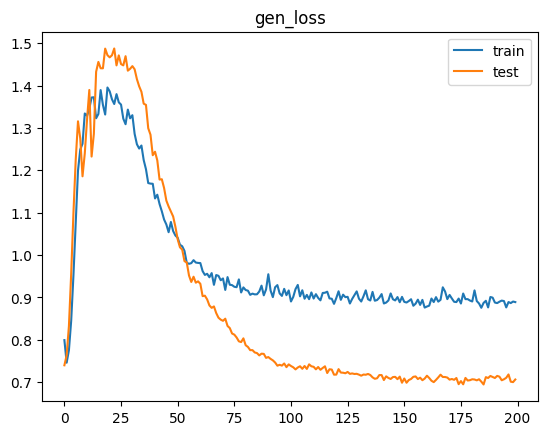

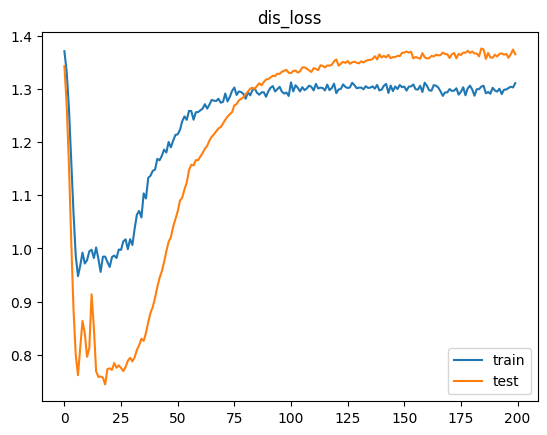

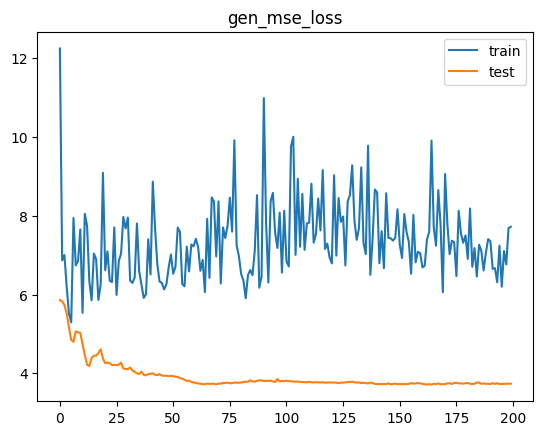

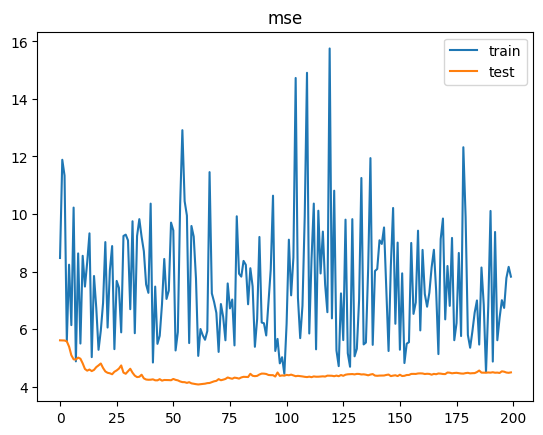

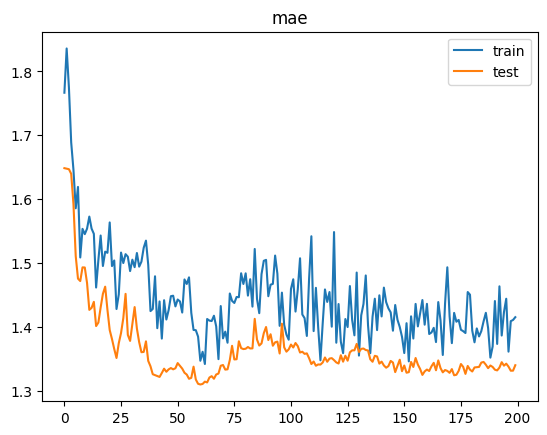

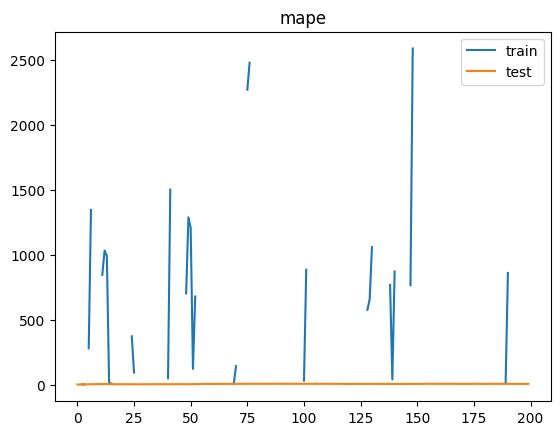

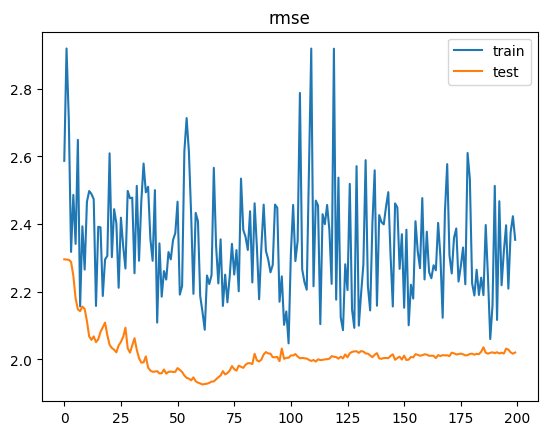

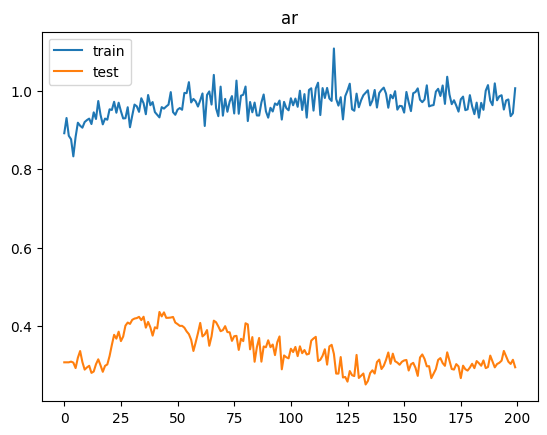

2/2 [==============================] - 0s 2ms/step


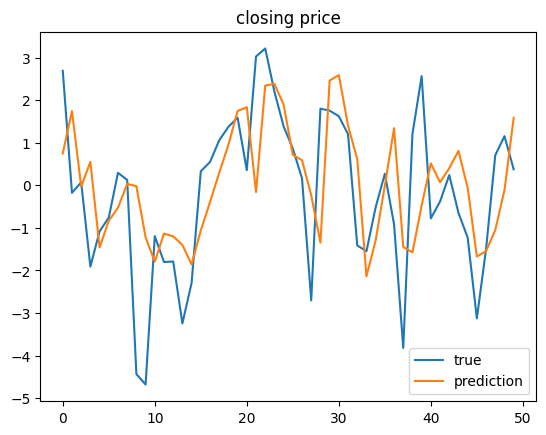

[MSE Baseline] train: 5.410971489361624  test: 4.137918162168212
Delta time with epochs = 200: 0:02:51.635718
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 lstm_3 (LSTM) 

Time for epoch 52 is 0.8234140872955322 sec Generator Loss: 1.0183991193771362,  Discriminator_loss: 1.2206722497940063
Time for epoch 53 is 0.7631397247314453 sec Generator Loss: 1.0242782831192017,  Discriminator_loss: 1.2233450412750244
Time for epoch 54 is 0.7704839706420898 sec Generator Loss: 1.0030664205551147,  Discriminator_loss: 1.236690640449524
Time for epoch 55 is 0.7761106491088867 sec Generator Loss: 0.9942901134490967,  Discriminator_loss: 1.2408000230789185
Time for epoch 56 is 0.7806222438812256 sec Generator Loss: 1.013952374458313,  Discriminator_loss: 1.233767032623291
Time for epoch 57 is 0.8666694164276123 sec Generator Loss: 0.9988828897476196,  Discriminator_loss: 1.2322665452957153
Time for epoch 58 is 0.881472110748291 sec Generator Loss: 0.9979550242424011,  Discriminator_loss: 1.2271430492401123
Time for epoch 59 is 0.8492982387542725 sec Generator Loss: 0.9785377383232117,  Discriminator_loss: 1.24625825881958
Time for epoch 60 is 0.803905725479126 sec Gen

Time for epoch 121 is 0.7606203556060791 sec Generator Loss: 0.9102200269699097,  Discriminator_loss: 1.2884293794631958
Time for epoch 122 is 0.8093535900115967 sec Generator Loss: 0.8989386558532715,  Discriminator_loss: 1.2872275114059448
Time for epoch 123 is 0.7899231910705566 sec Generator Loss: 0.8825139403343201,  Discriminator_loss: 1.2941207885742188
Time for epoch 124 is 0.7878422737121582 sec Generator Loss: 0.9152764081954956,  Discriminator_loss: 1.2858659029006958
Time for epoch 125 is 0.7692103385925293 sec Generator Loss: 0.8918472528457642,  Discriminator_loss: 1.2857792377471924
Time for epoch 126 is 0.8403708934783936 sec Generator Loss: 0.9001747369766235,  Discriminator_loss: 1.2905833721160889
Time for epoch 127 is 0.778162956237793 sec Generator Loss: 0.900600254535675,  Discriminator_loss: 1.2885136604309082
Time for epoch 128 is 0.7954792976379395 sec Generator Loss: 0.8923425674438477,  Discriminator_loss: 1.2990198135375977
Time for epoch 129 is 0.7928209304

Time for epoch 190 is 0.772899866104126 sec Generator Loss: 0.8913716673851013,  Discriminator_loss: 1.3030635118484497
Time for epoch 191 is 0.7739865779876709 sec Generator Loss: 0.8786572217941284,  Discriminator_loss: 1.3052740097045898
Time for epoch 192 is 0.7751970291137695 sec Generator Loss: 0.8689984679222107,  Discriminator_loss: 1.3117367029190063
Time for epoch 193 is 0.8336184024810791 sec Generator Loss: 0.8762836456298828,  Discriminator_loss: 1.3116544485092163
Time for epoch 194 is 0.7871716022491455 sec Generator Loss: 0.8629806637763977,  Discriminator_loss: 1.3024059534072876
Time for epoch 195 is 0.7743165493011475 sec Generator Loss: 0.8833631873130798,  Discriminator_loss: 1.3012135028839111
Time for epoch 196 is 0.767880916595459 sec Generator Loss: 0.9183030128479004,  Discriminator_loss: 1.3031764030456543
Time for epoch 197 is 0.7726848125457764 sec Generator Loss: 0.8946868181228638,  Discriminator_loss: 1.301672339439392
Time for epoch 198 is 0.76932048797

Time for epoch 258 is 0.7967760562896729 sec Generator Loss: 0.8717343807220459,  Discriminator_loss: 1.292920708656311
Time for epoch 259 is 0.7690439224243164 sec Generator Loss: 0.8914779424667358,  Discriminator_loss: 1.295375943183899
Time for epoch 260 is 0.7697017192840576 sec Generator Loss: 0.894064724445343,  Discriminator_loss: 1.299384593963623
Time for epoch 261 is 0.81825852394104 sec Generator Loss: 0.8925251364707947,  Discriminator_loss: 1.2864394187927246
Time for epoch 262 is 0.7890679836273193 sec Generator Loss: 0.8830018043518066,  Discriminator_loss: 1.2921046018600464
Time for epoch 263 is 0.7803418636322021 sec Generator Loss: 0.873310923576355,  Discriminator_loss: 1.2982710599899292
Time for epoch 264 is 0.7864830493927002 sec Generator Loss: 0.8718909025192261,  Discriminator_loss: 1.294806957244873
Time for epoch 265 is 0.7672824859619141 sec Generator Loss: 0.875234842300415,  Discriminator_loss: 1.3013617992401123
Time for epoch 266 is 0.7680449485778809 

Time for epoch 326 is 0.7749240398406982 sec Generator Loss: 0.8732529878616333,  Discriminator_loss: 1.2939485311508179
Time for epoch 327 is 0.7682945728302002 sec Generator Loss: 0.8723205924034119,  Discriminator_loss: 1.2968425750732422
Time for epoch 328 is 0.8092081546783447 sec Generator Loss: 0.8781840205192566,  Discriminator_loss: 1.2953882217407227
Time for epoch 329 is 0.8195388317108154 sec Generator Loss: 0.8887933492660522,  Discriminator_loss: 1.2951864004135132
Time for epoch 330 is 0.7705543041229248 sec Generator Loss: 0.8815051317214966,  Discriminator_loss: 1.2929500341415405
Time for epoch 331 is 0.774956464767456 sec Generator Loss: 0.8921994566917419,  Discriminator_loss: 1.2918307781219482
Time for epoch 332 is 0.7728767395019531 sec Generator Loss: 0.8924596905708313,  Discriminator_loss: 1.2947146892547607
Time for epoch 333 is 0.7861192226409912 sec Generator Loss: 0.9040729403495789,  Discriminator_loss: 1.292757272720337
Time for epoch 334 is 0.8035922050

Time for epoch 395 is 0.7734270095825195 sec Generator Loss: 0.8919691443443298,  Discriminator_loss: 1.3015174865722656
Time for epoch 396 is 0.8296689987182617 sec Generator Loss: 0.8953375220298767,  Discriminator_loss: 1.301506757736206
Time for epoch 397 is 0.8152892589569092 sec Generator Loss: 0.8755958080291748,  Discriminator_loss: 1.3022814989089966
Time for epoch 398 is 0.7850954532623291 sec Generator Loss: 0.8850356936454773,  Discriminator_loss: 1.291882872581482
Time for epoch 399 is 0.7697277069091797 sec Generator Loss: 0.8892165422439575,  Discriminator_loss: 1.2902826070785522
Time for epoch 400 is 0.7868521213531494 sec Generator Loss: 0.8765230178833008,  Discriminator_loss: 1.3013633489608765
Time for epoch 401 is 0.7749588489532471 sec Generator Loss: 0.880556046962738,  Discriminator_loss: 1.3023686408996582
Time for epoch 402 is 0.790992259979248 sec Generator Loss: 0.873465895652771,  Discriminator_loss: 1.293516755104065
Time for epoch 403 is 0.80836081504821

In [ ]:
for epochs in [200]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 5, 10)             720       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                             

Time for epoch 53 is 0.855886697769165 sec Generator Loss: 1.190081238746643,  Discriminator_loss: 1.1357916593551636
Time for epoch 54 is 0.7911419868469238 sec Generator Loss: 1.16080904006958,  Discriminator_loss: 1.1485493183135986
Time for epoch 55 is 0.7571096420288086 sec Generator Loss: 1.1420676708221436,  Discriminator_loss: 1.1592246294021606
Time for epoch 56 is 0.7632453441619873 sec Generator Loss: 1.123318076133728,  Discriminator_loss: 1.1759119033813477
Time for epoch 57 is 0.7369258403778076 sec Generator Loss: 1.10230553150177,  Discriminator_loss: 1.163381814956665
Time for epoch 58 is 0.7239880561828613 sec Generator Loss: 1.0908597707748413,  Discriminator_loss: 1.189648151397705
Time for epoch 59 is 0.7238385677337646 sec Generator Loss: 1.0881495475769043,  Discriminator_loss: 1.1822370290756226
Time for epoch 60 is 0.73789381980896 sec Generator Loss: 1.0698052644729614,  Discriminator_loss: 1.1985164880752563
Time for epoch 61 is 0.7544591426849365 sec Generat

Time for epoch 122 is 0.7651393413543701 sec Generator Loss: 0.934607982635498,  Discriminator_loss: 1.2843126058578491
Time for epoch 123 is 0.7642836570739746 sec Generator Loss: 0.9197382926940918,  Discriminator_loss: 1.2842389345169067
Time for epoch 124 is 0.852424144744873 sec Generator Loss: 0.9211471080780029,  Discriminator_loss: 1.2804619073867798
Time for epoch 125 is 1.0048353672027588 sec Generator Loss: 0.9338876605033875,  Discriminator_loss: 1.2847524881362915
Time for epoch 126 is 0.8664140701293945 sec Generator Loss: 0.9253228306770325,  Discriminator_loss: 1.2836694717407227
Time for epoch 127 is 0.7954533100128174 sec Generator Loss: 0.9321582913398743,  Discriminator_loss: 1.279489278793335
Time for epoch 128 is 0.7688112258911133 sec Generator Loss: 0.9276087284088135,  Discriminator_loss: 1.287047028541565
Time for epoch 129 is 0.9128577709197998 sec Generator Loss: 0.9159154295921326,  Discriminator_loss: 1.2944345474243164
Time for epoch 130 is 0.775996446609

Time for epoch 190 is 0.7453560829162598 sec Generator Loss: 0.9037445783615112,  Discriminator_loss: 1.308634877204895
Time for epoch 191 is 0.7413022518157959 sec Generator Loss: 0.910438060760498,  Discriminator_loss: 1.3015106916427612
Time for epoch 192 is 0.7264852523803711 sec Generator Loss: 0.8927607536315918,  Discriminator_loss: 1.3047667741775513
Time for epoch 193 is 0.7273299694061279 sec Generator Loss: 0.869523823261261,  Discriminator_loss: 1.3131664991378784
Time for epoch 194 is 0.7176482677459717 sec Generator Loss: 0.8907068371772766,  Discriminator_loss: 1.302729845046997
Time for epoch 195 is 0.7251663208007812 sec Generator Loss: 0.8846122622489929,  Discriminator_loss: 1.3083235025405884
Time for epoch 196 is 0.7291967868804932 sec Generator Loss: 0.8787232637405396,  Discriminator_loss: 1.3128257989883423
Time for epoch 197 is 0.738353967666626 sec Generator Loss: 0.9013981819152832,  Discriminator_loss: 1.2996522188186646
Time for epoch 198 is 0.7241683006286

Time for epoch 258 is 0.7723150253295898 sec Generator Loss: 0.8910970687866211,  Discriminator_loss: 1.309117078781128
Time for epoch 259 is 0.8123247623443604 sec Generator Loss: 0.9060252904891968,  Discriminator_loss: 1.2983466386795044
Time for epoch 260 is 0.8109273910522461 sec Generator Loss: 0.8792563080787659,  Discriminator_loss: 1.2990339994430542
Time for epoch 261 is 0.7618362903594971 sec Generator Loss: 0.9268131256103516,  Discriminator_loss: 1.288585901260376
Time for epoch 262 is 0.7694251537322998 sec Generator Loss: 0.9094602465629578,  Discriminator_loss: 1.2991701364517212
Time for epoch 263 is 0.7778136730194092 sec Generator Loss: 0.8943669199943542,  Discriminator_loss: 1.2924944162368774
Time for epoch 264 is 0.7757763862609863 sec Generator Loss: 0.8954795002937317,  Discriminator_loss: 1.3121145963668823
Time for epoch 265 is 0.7603073120117188 sec Generator Loss: 0.9141225218772888,  Discriminator_loss: 1.3043556213378906
Time for epoch 266 is 0.7334125041

Time for epoch 326 is 0.7416026592254639 sec Generator Loss: 0.8992924094200134,  Discriminator_loss: 1.3032230138778687
Time for epoch 327 is 0.7226636409759521 sec Generator Loss: 0.9053593873977661,  Discriminator_loss: 1.3105223178863525
Time for epoch 328 is 0.734978437423706 sec Generator Loss: 0.8915112018585205,  Discriminator_loss: 1.3096351623535156
Time for epoch 329 is 0.722092866897583 sec Generator Loss: 0.8804592490196228,  Discriminator_loss: 1.305925965309143
Time for epoch 330 is 0.7208366394042969 sec Generator Loss: 0.8987316489219666,  Discriminator_loss: 1.2999809980392456
Time for epoch 331 is 0.7301359176635742 sec Generator Loss: 0.880226194858551,  Discriminator_loss: 1.313758134841919
Time for epoch 332 is 0.7392637729644775 sec Generator Loss: 0.8938249349594116,  Discriminator_loss: 1.306187629699707
Time for epoch 333 is 0.7267138957977295 sec Generator Loss: 0.9112728834152222,  Discriminator_loss: 1.29093337059021
Time for epoch 334 is 0.7285454273223877

Time for epoch 395 is 0.8190650939941406 sec Generator Loss: 0.9011129140853882,  Discriminator_loss: 1.3016985654830933
Time for epoch 396 is 0.8606851100921631 sec Generator Loss: 0.8942966461181641,  Discriminator_loss: 1.2986339330673218
Time for epoch 397 is 0.7913925647735596 sec Generator Loss: 0.9002695083618164,  Discriminator_loss: 1.2972829341888428
Time for epoch 398 is 0.7959177494049072 sec Generator Loss: 0.914046585559845,  Discriminator_loss: 1.2922651767730713
Time for epoch 399 is 0.8203351497650146 sec Generator Loss: 0.9018238186836243,  Discriminator_loss: 1.2957803010940552
Time for epoch 400 is 0.7909266948699951 sec Generator Loss: 0.9151042699813843,  Discriminator_loss: 1.288547158241272
Time for epoch 401 is 0.7519490718841553 sec Generator Loss: 0.9116255640983582,  Discriminator_loss: 1.2936532497406006
Time for epoch 402 is 0.7921857833862305 sec Generator Loss: 0.9112681150436401,  Discriminator_loss: 1.3008227348327637
Time for epoch 403 is 0.7500979900

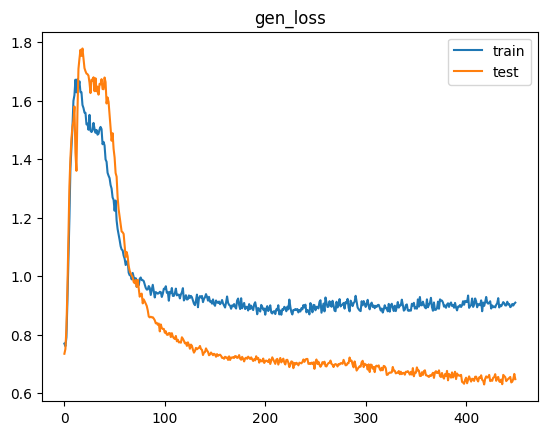

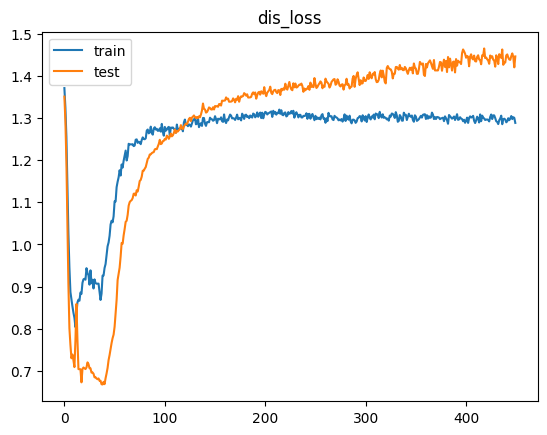

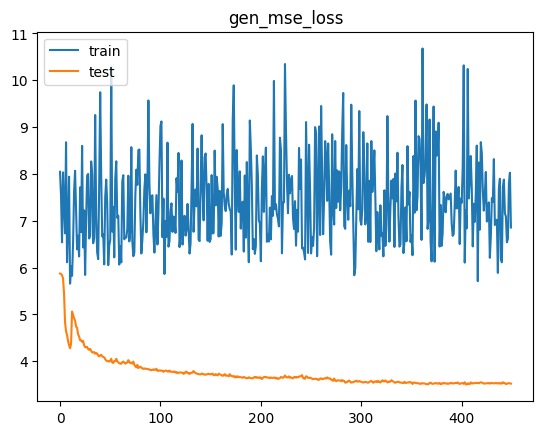

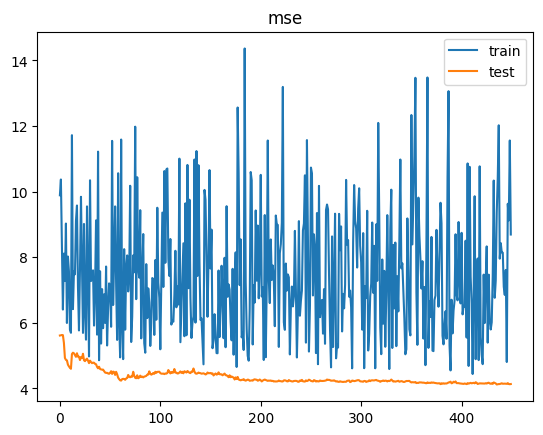

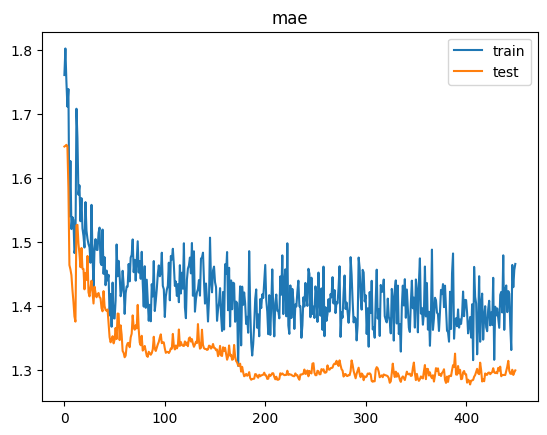

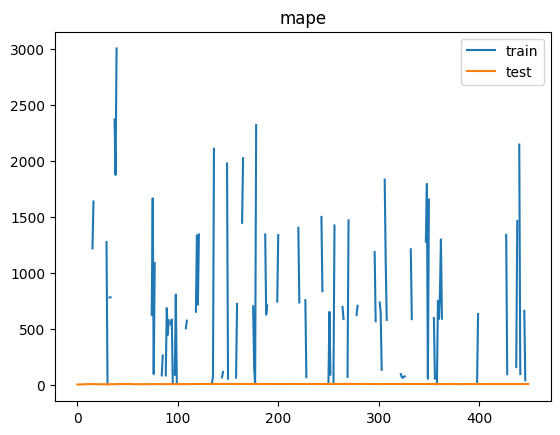

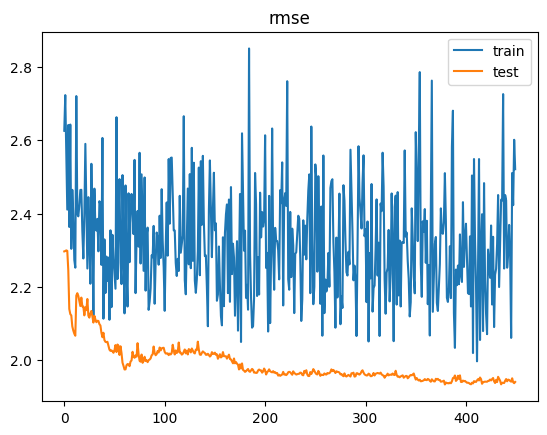

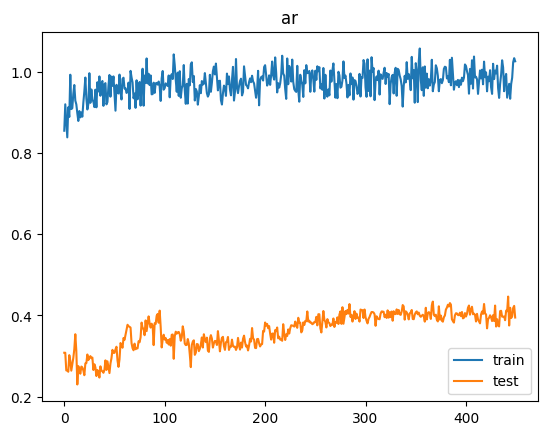

2/2 [==============================] - 0s 3ms/step


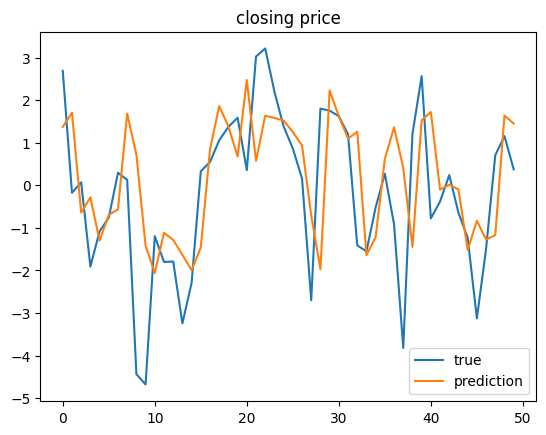

[MSE Baseline] train: 4.41359468646351  test: 4.137918162168212
Delta time with epochs = 450: 0:05:54.955579
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 lstm_3 (LSTM)  

Time for epoch 53 is 0.7897074222564697 sec Generator Loss: 0.96676105260849,  Discriminator_loss: 1.2716758251190186
Time for epoch 54 is 0.8185882568359375 sec Generator Loss: 0.9500399231910706,  Discriminator_loss: 1.2708765268325806
Time for epoch 55 is 0.8559062480926514 sec Generator Loss: 0.9483057856559753,  Discriminator_loss: 1.2856998443603516
Time for epoch 56 is 0.8192124366760254 sec Generator Loss: 0.9288696050643921,  Discriminator_loss: 1.279763102531433
Time for epoch 57 is 0.8117239475250244 sec Generator Loss: 0.9267788529396057,  Discriminator_loss: 1.2965214252471924
Time for epoch 58 is 0.8129358291625977 sec Generator Loss: 0.9219986796379089,  Discriminator_loss: 1.292342185974121
Time for epoch 59 is 0.8095901012420654 sec Generator Loss: 0.9218830466270447,  Discriminator_loss: 1.298970341682434
Time for epoch 60 is 0.7963008880615234 sec Generator Loss: 0.9068219661712646,  Discriminator_loss: 1.2937400341033936
Time for epoch 61 is 0.789421558380127 sec Ge

Time for epoch 122 is 0.7927694320678711 sec Generator Loss: 0.8507491946220398,  Discriminator_loss: 1.3213953971862793
Time for epoch 123 is 0.7833278179168701 sec Generator Loss: 0.868908166885376,  Discriminator_loss: 1.3051499128341675
Time for epoch 124 is 0.7962267398834229 sec Generator Loss: 0.86762934923172,  Discriminator_loss: 1.3096849918365479
Time for epoch 125 is 0.7450432777404785 sec Generator Loss: 0.849034309387207,  Discriminator_loss: 1.3190785646438599
Time for epoch 126 is 0.7540533542633057 sec Generator Loss: 0.8538506627082825,  Discriminator_loss: 1.31712007522583
Time for epoch 127 is 0.7444255352020264 sec Generator Loss: 0.8521921038627625,  Discriminator_loss: 1.3159056901931763
Time for epoch 128 is 0.7546637058258057 sec Generator Loss: 0.8507370948791504,  Discriminator_loss: 1.3158934116363525
Time for epoch 129 is 0.7460813522338867 sec Generator Loss: 0.8488802313804626,  Discriminator_loss: 1.31546151638031
Time for epoch 130 is 0.7458977699279785

Time for epoch 191 is 0.7410452365875244 sec Generator Loss: 0.8445752859115601,  Discriminator_loss: 1.3300472497940063
Time for epoch 192 is 0.750847339630127 sec Generator Loss: 0.8520920276641846,  Discriminator_loss: 1.315075397491455
Time for epoch 193 is 0.7385051250457764 sec Generator Loss: 0.8482264280319214,  Discriminator_loss: 1.3180502653121948
Time for epoch 194 is 0.7406482696533203 sec Generator Loss: 0.8429274559020996,  Discriminator_loss: 1.3192710876464844
Time for epoch 195 is 0.7371439933776855 sec Generator Loss: 0.8461547493934631,  Discriminator_loss: 1.31674325466156
Time for epoch 196 is 0.7409677505493164 sec Generator Loss: 0.8602250814437866,  Discriminator_loss: 1.318395972251892
Time for epoch 197 is 0.7780356407165527 sec Generator Loss: 0.8599782586097717,  Discriminator_loss: 1.3170241117477417
Time for epoch 198 is 0.7765626907348633 sec Generator Loss: 0.8461443185806274,  Discriminator_loss: 1.3156410455703735
Time for epoch 199 is 0.7762019634246

Time for epoch 259 is 0.7574305534362793 sec Generator Loss: 0.8585834503173828,  Discriminator_loss: 1.322062373161316
Time for epoch 260 is 0.7391500473022461 sec Generator Loss: 0.8507051467895508,  Discriminator_loss: 1.3154261112213135
Time for epoch 261 is 0.772681713104248 sec Generator Loss: 0.862383246421814,  Discriminator_loss: 1.3122214078903198
Time for epoch 262 is 0.7461938858032227 sec Generator Loss: 0.8602477312088013,  Discriminator_loss: 1.3149802684783936
Time for epoch 263 is 0.7365748882293701 sec Generator Loss: 0.8664725422859192,  Discriminator_loss: 1.321763515472412
Time for epoch 264 is 0.7435102462768555 sec Generator Loss: 0.8537488579750061,  Discriminator_loss: 1.308637022972107
Time for epoch 265 is 0.7382102012634277 sec Generator Loss: 0.8604571223258972,  Discriminator_loss: 1.3175503015518188
Time for epoch 266 is 0.7416653633117676 sec Generator Loss: 0.8573076128959656,  Discriminator_loss: 1.312951922416687
Time for epoch 267 is 0.74891138076782

Time for epoch 328 is 0.7509346008300781 sec Generator Loss: 0.8819019794464111,  Discriminator_loss: 1.3038562536239624
Time for epoch 329 is 0.7420272827148438 sec Generator Loss: 0.8820509314537048,  Discriminator_loss: 1.311000108718872
Time for epoch 330 is 0.738436222076416 sec Generator Loss: 0.8558837175369263,  Discriminator_loss: 1.3033514022827148
Time for epoch 331 is 0.7497725486755371 sec Generator Loss: 0.8702641725540161,  Discriminator_loss: 1.308493733406067
Time for epoch 332 is 0.7441508769989014 sec Generator Loss: 0.8715028166770935,  Discriminator_loss: 1.3027194738388062
Time for epoch 333 is 0.7403881549835205 sec Generator Loss: 0.8678949475288391,  Discriminator_loss: 1.3061227798461914
Time for epoch 334 is 0.7794554233551025 sec Generator Loss: 0.869820237159729,  Discriminator_loss: 1.3058629035949707
Time for epoch 335 is 0.7921476364135742 sec Generator Loss: 0.871620237827301,  Discriminator_loss: 1.308078408241272
Time for epoch 336 is 0.74860715866088

Time for epoch 397 is 0.7501537799835205 sec Generator Loss: 0.8899733424186707,  Discriminator_loss: 1.2941436767578125
Time for epoch 398 is 0.733893632888794 sec Generator Loss: 0.8669897317886353,  Discriminator_loss: 1.303152322769165
Time for epoch 399 is 0.7345230579376221 sec Generator Loss: 0.8829845786094666,  Discriminator_loss: 1.2975852489471436
Time for epoch 400 is 0.7292520999908447 sec Generator Loss: 0.86480313539505,  Discriminator_loss: 1.3031448125839233
Time for epoch 401 is 0.7351160049438477 sec Generator Loss: 0.8903892636299133,  Discriminator_loss: 1.2984514236450195
Time for epoch 402 is 0.7430431842803955 sec Generator Loss: 0.8801012635231018,  Discriminator_loss: 1.3042603731155396
Time for epoch 403 is 0.7865006923675537 sec Generator Loss: 0.8776820302009583,  Discriminator_loss: 1.3026775121688843
Time for epoch 404 is 0.7343723773956299 sec Generator Loss: 0.8894909024238586,  Discriminator_loss: 1.2997668981552124
Time for epoch 405 is 0.736688613891

Time for epoch 465 is 0.7473955154418945 sec Generator Loss: 0.9071069955825806,  Discriminator_loss: 1.2955759763717651
Time for epoch 466 is 0.7452952861785889 sec Generator Loss: 0.8820962905883789,  Discriminator_loss: 1.3093212842941284
Time for epoch 467 is 0.7353579998016357 sec Generator Loss: 0.8630198240280151,  Discriminator_loss: 1.3050633668899536
Time for epoch 468 is 0.741154670715332 sec Generator Loss: 0.874449610710144,  Discriminator_loss: 1.2987308502197266
Time for epoch 469 is 0.7456893920898438 sec Generator Loss: 0.8845996260643005,  Discriminator_loss: 1.2967356443405151
Time for epoch 470 is 0.7358207702636719 sec Generator Loss: 0.8918711543083191,  Discriminator_loss: 1.2916065454483032
Time for epoch 471 is 0.7303483486175537 sec Generator Loss: 0.8928082585334778,  Discriminator_loss: 1.2851616144180298
Time for epoch 472 is 0.736156702041626 sec Generator Loss: 0.8941311240196228,  Discriminator_loss: 1.2929471731185913
Time for epoch 473 is 0.77117919921

Time for epoch 533 is 0.7423193454742432 sec Generator Loss: 0.8899489641189575,  Discriminator_loss: 1.290989875793457
Time for epoch 534 is 0.7400083541870117 sec Generator Loss: 0.9018502235412598,  Discriminator_loss: 1.2775092124938965
Time for epoch 535 is 0.7400059700012207 sec Generator Loss: 0.8848901987075806,  Discriminator_loss: 1.2905021905899048
Time for epoch 536 is 0.7367033958435059 sec Generator Loss: 0.8912625908851624,  Discriminator_loss: 1.2850377559661865
Time for epoch 537 is 0.750103235244751 sec Generator Loss: 0.9094035029411316,  Discriminator_loss: 1.285130500793457
Time for epoch 538 is 0.7434611320495605 sec Generator Loss: 0.8875232338905334,  Discriminator_loss: 1.2884411811828613
Time for epoch 539 is 0.7370657920837402 sec Generator Loss: 0.884810209274292,  Discriminator_loss: 1.296725869178772
Time for epoch 540 is 0.7472748756408691 sec Generator Loss: 0.8955735564231873,  Discriminator_loss: 1.283157229423523
Time for epoch 541 is 0.78108286857604

Time for epoch 602 is 0.7536067962646484 sec Generator Loss: 0.887501060962677,  Discriminator_loss: 1.2876551151275635
Time for epoch 603 is 0.7468211650848389 sec Generator Loss: 0.906387448310852,  Discriminator_loss: 1.2939071655273438
Time for epoch 604 is 0.73870849609375 sec Generator Loss: 0.9107603430747986,  Discriminator_loss: 1.2846835851669312
Time for epoch 605 is 0.7348260879516602 sec Generator Loss: 0.9001523852348328,  Discriminator_loss: 1.2905818223953247
Time for epoch 606 is 0.7385632991790771 sec Generator Loss: 0.9067841172218323,  Discriminator_loss: 1.2795090675354004
Time for epoch 607 is 0.7374789714813232 sec Generator Loss: 0.8899791240692139,  Discriminator_loss: 1.2895301580429077
Time for epoch 608 is 0.7456471920013428 sec Generator Loss: 0.8861335515975952,  Discriminator_loss: 1.2870993614196777
Time for epoch 609 is 0.7444970607757568 sec Generator Loss: 0.8940569758415222,  Discriminator_loss: 1.2908973693847656
Time for epoch 610 is 0.740792512893

Time for epoch 670 is 0.7480390071868896 sec Generator Loss: 0.8971880674362183,  Discriminator_loss: 1.2858986854553223
Time for epoch 671 is 0.7432525157928467 sec Generator Loss: 0.9107704162597656,  Discriminator_loss: 1.2971001863479614
Time for epoch 672 is 0.7416951656341553 sec Generator Loss: 0.8908953666687012,  Discriminator_loss: 1.2942874431610107
Time for epoch 673 is 0.7438790798187256 sec Generator Loss: 0.9207905530929565,  Discriminator_loss: 1.2712597846984863
Time for epoch 674 is 0.7527685165405273 sec Generator Loss: 0.8985296487808228,  Discriminator_loss: 1.2857731580734253
Time for epoch 675 is 0.7518208026885986 sec Generator Loss: 0.8864197731018066,  Discriminator_loss: 1.2856383323669434
Time for epoch 676 is 0.7371656894683838 sec Generator Loss: 0.9015257954597473,  Discriminator_loss: 1.2787669897079468
Time for epoch 677 is 0.7443528175354004 sec Generator Loss: 0.9047684669494629,  Discriminator_loss: 1.2806565761566162
Time for epoch 678 is 0.74196100

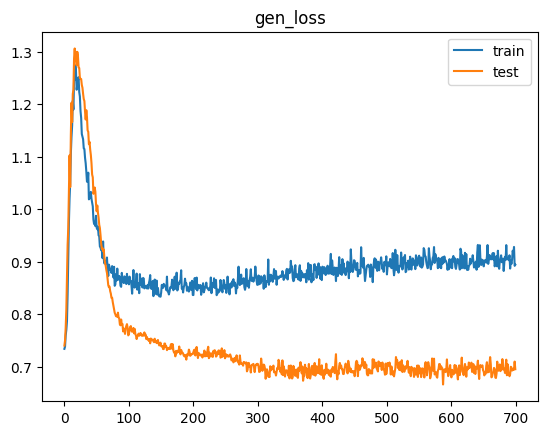

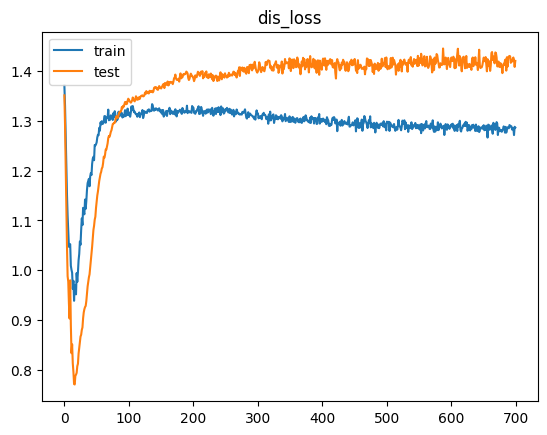

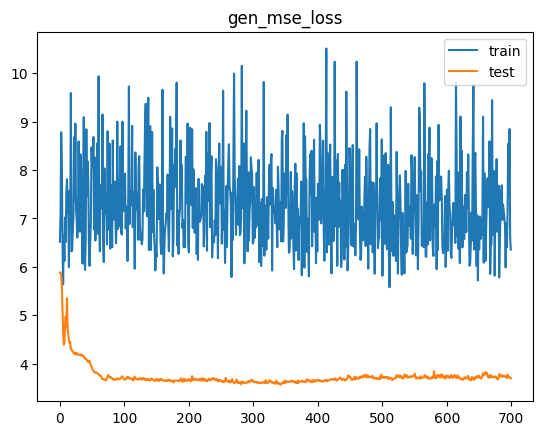

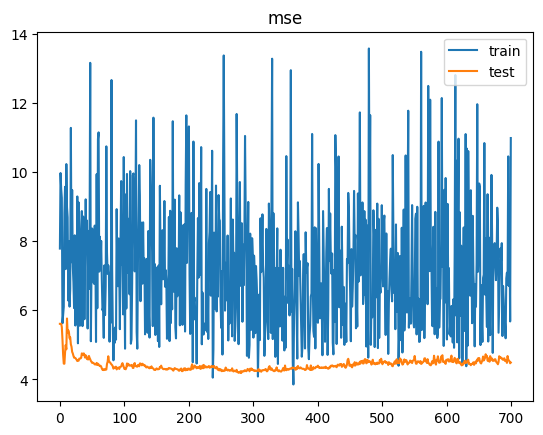

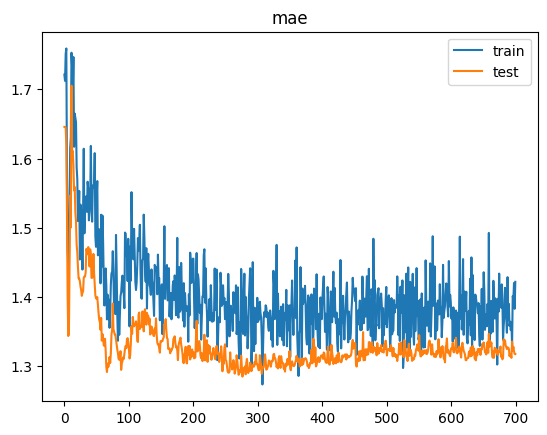

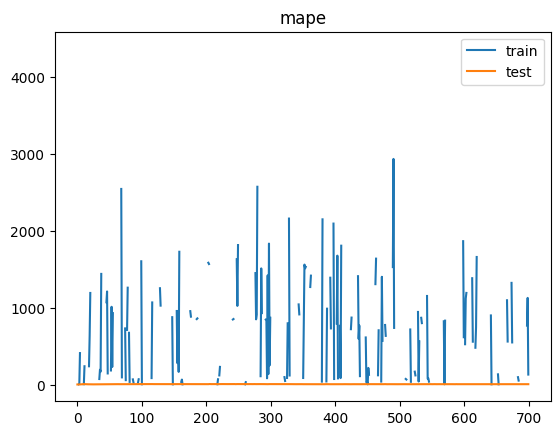

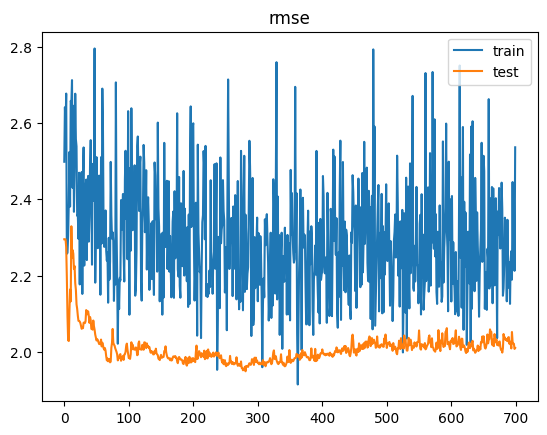

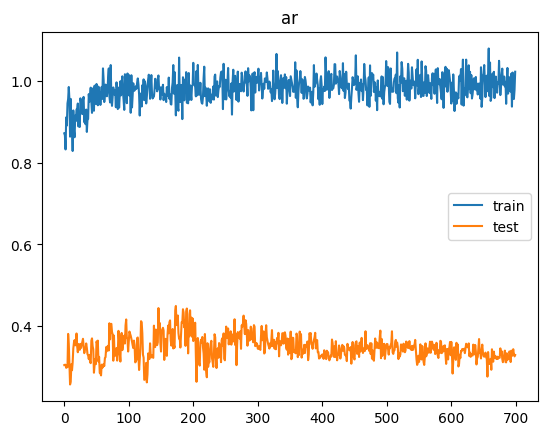

2/2 [==============================] - 0s 3ms/step


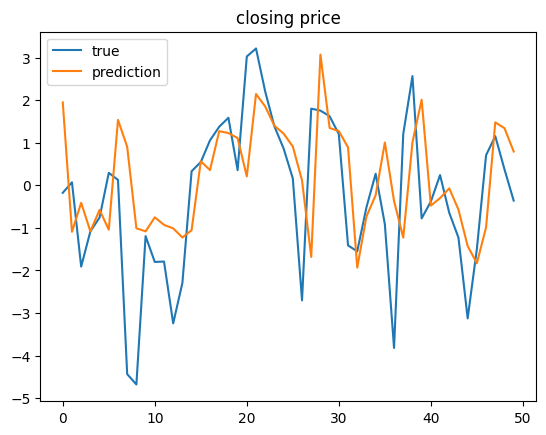

[MSE Baseline] train: 8.248087417959395  test: 4.1521541466081695
Delta time with epochs = 700: 0:09:11.655152


In [20]:
for epochs in [450, 700]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                           

Time for epoch 53 is 0.7827553749084473 sec Generator Loss: 1.1475328207015991,  Discriminator_loss: 1.1299172639846802
Time for epoch 54 is 0.9711916446685791 sec Generator Loss: 1.160172462463379,  Discriminator_loss: 1.1200592517852783
Time for epoch 55 is 0.8555281162261963 sec Generator Loss: 1.1432020664215088,  Discriminator_loss: 1.138951063156128
Time for epoch 56 is 0.8207616806030273 sec Generator Loss: 1.1323366165161133,  Discriminator_loss: 1.1433414220809937
Time for epoch 57 is 0.7610840797424316 sec Generator Loss: 1.108425498008728,  Discriminator_loss: 1.1475872993469238
Time for epoch 58 is 0.812432050704956 sec Generator Loss: 1.1102592945098877,  Discriminator_loss: 1.1459038257598877
Time for epoch 59 is 0.8331966400146484 sec Generator Loss: 1.0945013761520386,  Discriminator_loss: 1.1659218072891235
Time for epoch 60 is 0.7444908618927002 sec Generator Loss: 1.074175238609314,  Discriminator_loss: 1.173645257949829
Time for epoch 61 is 0.7425572872161865 sec Ge

Time for epoch 122 is 0.7863996028900146 sec Generator Loss: 0.911674439907074,  Discriminator_loss: 1.2829580307006836
Time for epoch 123 is 0.7923393249511719 sec Generator Loss: 0.9068795442581177,  Discriminator_loss: 1.2961262464523315
Time for epoch 124 is 0.7538225650787354 sec Generator Loss: 0.9148582816123962,  Discriminator_loss: 1.2815191745758057
Time for epoch 125 is 0.7644028663635254 sec Generator Loss: 0.9365518689155579,  Discriminator_loss: 1.2748416662216187
Time for epoch 126 is 0.7523577213287354 sec Generator Loss: 0.9354140758514404,  Discriminator_loss: 1.2847508192062378
Time for epoch 127 is 0.7533106803894043 sec Generator Loss: 0.9020637273788452,  Discriminator_loss: 1.2920324802398682
Time for epoch 128 is 0.7581703662872314 sec Generator Loss: 0.9334229230880737,  Discriminator_loss: 1.2861181497573853
Time for epoch 129 is 0.7524778842926025 sec Generator Loss: 0.943464457988739,  Discriminator_loss: 1.2806862592697144
Time for epoch 130 is 0.7512228488

Time for epoch 190 is 0.7525820732116699 sec Generator Loss: 0.8901978135108948,  Discriminator_loss: 1.2848435640335083
Time for epoch 191 is 0.7524676322937012 sec Generator Loss: 0.9248989224433899,  Discriminator_loss: 1.2920544147491455
Time for epoch 192 is 0.7824387550354004 sec Generator Loss: 0.8999839425086975,  Discriminator_loss: 1.3085044622421265
Time for epoch 193 is 0.7743651866912842 sec Generator Loss: 0.8884737491607666,  Discriminator_loss: 1.3001693487167358
Time for epoch 194 is 0.755774736404419 sec Generator Loss: 0.8858546018600464,  Discriminator_loss: 1.305975317955017
Time for epoch 195 is 0.7695364952087402 sec Generator Loss: 0.8649311065673828,  Discriminator_loss: 1.3154034614562988
Time for epoch 196 is 0.778292179107666 sec Generator Loss: 0.8817892670631409,  Discriminator_loss: 1.302588939666748
Time for epoch 197 is 0.7512602806091309 sec Generator Loss: 0.9175246357917786,  Discriminator_loss: 1.29011869430542
Time for epoch 198 is 0.74930524826049

Time for epoch 258 is 0.852210283279419 sec Generator Loss: 0.8939743638038635,  Discriminator_loss: 1.3003292083740234
Time for epoch 259 is 0.7843623161315918 sec Generator Loss: 0.8921048045158386,  Discriminator_loss: 1.294049859046936
Time for epoch 260 is 0.7848923206329346 sec Generator Loss: 0.88394695520401,  Discriminator_loss: 1.2950283288955688
Time for epoch 261 is 0.7517490386962891 sec Generator Loss: 0.8978221416473389,  Discriminator_loss: 1.298498511314392
Time for epoch 262 is 0.7766702175140381 sec Generator Loss: 0.8998807668685913,  Discriminator_loss: 1.289703369140625
Time for epoch 263 is 0.8356890678405762 sec Generator Loss: 0.8919442892074585,  Discriminator_loss: 1.2972123622894287
Time for epoch 264 is 0.7869443893432617 sec Generator Loss: 0.8786749839782715,  Discriminator_loss: 1.2976828813552856
Time for epoch 265 is 0.7822310924530029 sec Generator Loss: 0.8871845006942749,  Discriminator_loss: 1.2915165424346924
Time for epoch 266 is 0.78936243057250

Time for epoch 326 is 0.7674233913421631 sec Generator Loss: 0.9092140793800354,  Discriminator_loss: 1.287243127822876
Time for epoch 327 is 0.7520961761474609 sec Generator Loss: 0.8968135118484497,  Discriminator_loss: 1.2887290716171265
Time for epoch 328 is 0.7440731525421143 sec Generator Loss: 0.8854146003723145,  Discriminator_loss: 1.2851439714431763
Time for epoch 329 is 0.7896692752838135 sec Generator Loss: 0.8991199135780334,  Discriminator_loss: 1.283393383026123
Time for epoch 330 is 0.7430074214935303 sec Generator Loss: 0.8955750465393066,  Discriminator_loss: 1.2988030910491943
Time for epoch 331 is 0.7932934761047363 sec Generator Loss: 0.894900381565094,  Discriminator_loss: 1.29062020778656
Time for epoch 332 is 0.7557952404022217 sec Generator Loss: 0.9170533418655396,  Discriminator_loss: 1.2973556518554688
Time for epoch 333 is 0.7607259750366211 sec Generator Loss: 0.8946235775947571,  Discriminator_loss: 1.2849087715148926
Time for epoch 334 is 0.7519116401672

Time for epoch 394 is 0.8015182018280029 sec Generator Loss: 0.9314345717430115,  Discriminator_loss: 1.2895485162734985
Time for epoch 395 is 0.7854444980621338 sec Generator Loss: 0.9335612058639526,  Discriminator_loss: 1.2859212160110474
Time for epoch 396 is 0.8835301399230957 sec Generator Loss: 0.8980579376220703,  Discriminator_loss: 1.283676266670227
Time for epoch 397 is 0.8016142845153809 sec Generator Loss: 0.9113483428955078,  Discriminator_loss: 1.2820179462432861
Time for epoch 398 is 0.7867438793182373 sec Generator Loss: 0.9041786193847656,  Discriminator_loss: 1.2877863645553589
Time for epoch 399 is 0.7972633838653564 sec Generator Loss: 0.9154263138771057,  Discriminator_loss: 1.2941666841506958
Time for epoch 400 is 0.7911078929901123 sec Generator Loss: 0.92507404088974,  Discriminator_loss: 1.2838983535766602
Time for epoch 401 is 0.756941556930542 sec Generator Loss: 0.9046909213066101,  Discriminator_loss: 1.2962801456451416
Time for epoch 402 is 0.753994941711

Time for epoch 462 is 0.7889621257781982 sec Generator Loss: 0.9074475169181824,  Discriminator_loss: 1.2847115993499756
Time for epoch 463 is 0.8300895690917969 sec Generator Loss: 0.9034382104873657,  Discriminator_loss: 1.2965120077133179
Time for epoch 464 is 0.8118128776550293 sec Generator Loss: 0.8905604481697083,  Discriminator_loss: 1.2968252897262573
Time for epoch 465 is 0.8684399127960205 sec Generator Loss: 0.8914687633514404,  Discriminator_loss: 1.2951477766036987
Time for epoch 466 is 0.8372266292572021 sec Generator Loss: 0.9264091849327087,  Discriminator_loss: 1.2848825454711914
Time for epoch 467 is 0.8019058704376221 sec Generator Loss: 0.9100555777549744,  Discriminator_loss: 1.2876100540161133
Time for epoch 468 is 0.7884180545806885 sec Generator Loss: 0.9284614324569702,  Discriminator_loss: 1.2899582386016846
Time for epoch 469 is 0.7608146667480469 sec Generator Loss: 0.9041510820388794,  Discriminator_loss: 1.2887383699417114
Time for epoch 470 is 0.75923800

Time for epoch 530 is 0.7577428817749023 sec Generator Loss: 0.9194726347923279,  Discriminator_loss: 1.2941148281097412
Time for epoch 531 is 0.7590196132659912 sec Generator Loss: 0.9171971082687378,  Discriminator_loss: 1.2831355333328247
Time for epoch 532 is 0.7594845294952393 sec Generator Loss: 0.9352796077728271,  Discriminator_loss: 1.2904129028320312
Time for epoch 533 is 0.7713377475738525 sec Generator Loss: 0.9027919769287109,  Discriminator_loss: 1.2955588102340698
Time for epoch 534 is 0.8067238330841064 sec Generator Loss: 0.9129739999771118,  Discriminator_loss: 1.2891134023666382
Time for epoch 535 is 0.7665071487426758 sec Generator Loss: 0.9060636162757874,  Discriminator_loss: 1.294119119644165
Time for epoch 536 is 0.7705380916595459 sec Generator Loss: 0.8927643299102783,  Discriminator_loss: 1.2895832061767578
Time for epoch 537 is 0.7793645858764648 sec Generator Loss: 0.906474232673645,  Discriminator_loss: 1.2993409633636475
Time for epoch 538 is 0.8142111301

Time for epoch 598 is 0.9346225261688232 sec Generator Loss: 0.8848647475242615,  Discriminator_loss: 1.2986069917678833
Time for epoch 599 is 0.9956505298614502 sec Generator Loss: 0.9021164774894714,  Discriminator_loss: 1.299785852432251
Time for epoch 600 is 0.9195942878723145 sec Generator Loss: 0.8806172609329224,  Discriminator_loss: 1.2986292839050293
Time for epoch 601 is 0.8215575218200684 sec Generator Loss: 0.896797776222229,  Discriminator_loss: 1.2950072288513184
Time for epoch 602 is 0.8319973945617676 sec Generator Loss: 0.909126877784729,  Discriminator_loss: 1.2940826416015625
Time for epoch 603 is 0.8280384540557861 sec Generator Loss: 0.8852750062942505,  Discriminator_loss: 1.3013173341751099
Time for epoch 604 is 0.8542203903198242 sec Generator Loss: 0.8952131867408752,  Discriminator_loss: 1.301155924797058
Time for epoch 605 is 0.8553361892700195 sec Generator Loss: 0.8979039192199707,  Discriminator_loss: 1.2892365455627441
Time for epoch 606 is 0.830216169357

Time for epoch 666 is 0.7651307582855225 sec Generator Loss: 0.9231534004211426,  Discriminator_loss: 1.2854204177856445
Time for epoch 667 is 0.7579820156097412 sec Generator Loss: 0.9068663716316223,  Discriminator_loss: 1.2878962755203247
Time for epoch 668 is 0.7503163814544678 sec Generator Loss: 0.9066480994224548,  Discriminator_loss: 1.2898967266082764
Time for epoch 669 is 0.7746069431304932 sec Generator Loss: 0.9037922024726868,  Discriminator_loss: 1.2856929302215576
Time for epoch 670 is 0.8294470310211182 sec Generator Loss: 0.9213067293167114,  Discriminator_loss: 1.2943421602249146
Time for epoch 671 is 0.7886612415313721 sec Generator Loss: 0.9095548987388611,  Discriminator_loss: 1.29050874710083
Time for epoch 672 is 0.798166036605835 sec Generator Loss: 0.9018267393112183,  Discriminator_loss: 1.28461754322052
Time for epoch 673 is 0.8090043067932129 sec Generator Loss: 0.9276911616325378,  Discriminator_loss: 1.2904086112976074
Time for epoch 674 is 0.7986626625061

Time for epoch 734 is 0.8726634979248047 sec Generator Loss: 0.9070615172386169,  Discriminator_loss: 1.3013012409210205
Time for epoch 735 is 0.8673200607299805 sec Generator Loss: 0.9002127647399902,  Discriminator_loss: 1.2934544086456299
Time for epoch 736 is 0.8520627021789551 sec Generator Loss: 0.9019959568977356,  Discriminator_loss: 1.2895903587341309
Time for epoch 737 is 0.9373552799224854 sec Generator Loss: 0.8943054676055908,  Discriminator_loss: 1.2887848615646362
Time for epoch 738 is 0.9436073303222656 sec Generator Loss: 0.910070538520813,  Discriminator_loss: 1.2877119779586792
Time for epoch 739 is 0.8961694240570068 sec Generator Loss: 0.9182114601135254,  Discriminator_loss: 1.2950042486190796
Time for epoch 740 is 0.8961999416351318 sec Generator Loss: 0.9380238652229309,  Discriminator_loss: 1.2826728820800781
Time for epoch 741 is 0.8917655944824219 sec Generator Loss: 0.9020999670028687,  Discriminator_loss: 1.293169617652893
Time for epoch 742 is 0.9499089717

Time for epoch 802 is 0.9365017414093018 sec Generator Loss: 0.9119222164154053,  Discriminator_loss: 1.2882493734359741
Time for epoch 803 is 0.9583055973052979 sec Generator Loss: 0.9096512794494629,  Discriminator_loss: 1.291876196861267
Time for epoch 804 is 0.9211471080780029 sec Generator Loss: 0.8983440399169922,  Discriminator_loss: 1.2850171327590942
Time for epoch 805 is 0.890047550201416 sec Generator Loss: 0.9286759495735168,  Discriminator_loss: 1.2914928197860718
Time for epoch 806 is 0.9335839748382568 sec Generator Loss: 0.9096187949180603,  Discriminator_loss: 1.28251314163208
Time for epoch 807 is 1.0541250705718994 sec Generator Loss: 0.9001159071922302,  Discriminator_loss: 1.2960052490234375
Time for epoch 808 is 0.8582911491394043 sec Generator Loss: 0.9103335738182068,  Discriminator_loss: 1.2862025499343872
Time for epoch 809 is 0.8984982967376709 sec Generator Loss: 0.8890961408615112,  Discriminator_loss: 1.2971782684326172
Time for epoch 810 is 0.824942350387

Time for epoch 870 is 0.8729381561279297 sec Generator Loss: 0.941265344619751,  Discriminator_loss: 1.277439832687378
Time for epoch 871 is 0.8193137645721436 sec Generator Loss: 0.9399542808532715,  Discriminator_loss: 1.2745113372802734
Time for epoch 872 is 0.8226325511932373 sec Generator Loss: 0.9284253716468811,  Discriminator_loss: 1.2808797359466553
Time for epoch 873 is 0.8081448078155518 sec Generator Loss: 0.9124519228935242,  Discriminator_loss: 1.28145432472229
Time for epoch 874 is 0.8126769065856934 sec Generator Loss: 0.922046959400177,  Discriminator_loss: 1.2897733449935913
Time for epoch 875 is 0.802966833114624 sec Generator Loss: 0.9138510823249817,  Discriminator_loss: 1.2870758771896362
Time for epoch 876 is 0.8791906833648682 sec Generator Loss: 0.9291316866874695,  Discriminator_loss: 1.2844598293304443
Time for epoch 877 is 0.9136152267456055 sec Generator Loss: 0.9010710716247559,  Discriminator_loss: 1.2864102125167847
Time for epoch 878 is 0.93306469917297

Time for epoch 939 is 0.8071150779724121 sec Generator Loss: 0.9066778421401978,  Discriminator_loss: 1.2853590250015259
Time for epoch 940 is 0.8101496696472168 sec Generator Loss: 0.9270840883255005,  Discriminator_loss: 1.279665470123291
Time for epoch 941 is 0.8295021057128906 sec Generator Loss: 0.9181214570999146,  Discriminator_loss: 1.2861124277114868
Time for epoch 942 is 0.9358429908752441 sec Generator Loss: 0.9314256906509399,  Discriminator_loss: 1.281646966934204
Time for epoch 943 is 0.8388187885284424 sec Generator Loss: 0.924424409866333,  Discriminator_loss: 1.2758338451385498
Time for epoch 944 is 0.9630579948425293 sec Generator Loss: 0.9063369035720825,  Discriminator_loss: 1.286219596862793
Time for epoch 945 is 0.8112215995788574 sec Generator Loss: 0.9187621474266052,  Discriminator_loss: 1.2883882522583008
Time for epoch 946 is 0.8659005165100098 sec Generator Loss: 0.9257522821426392,  Discriminator_loss: 1.2779977321624756
Time for epoch 947 is 0.844015836715

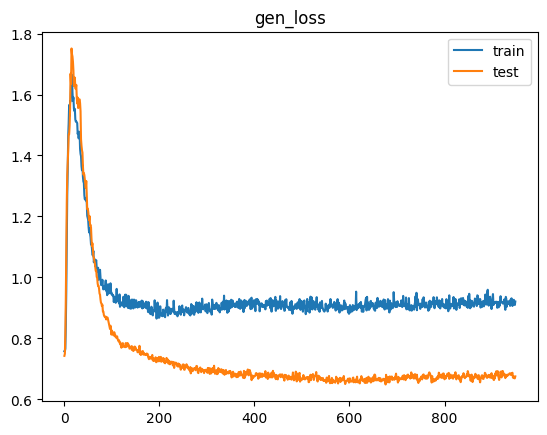

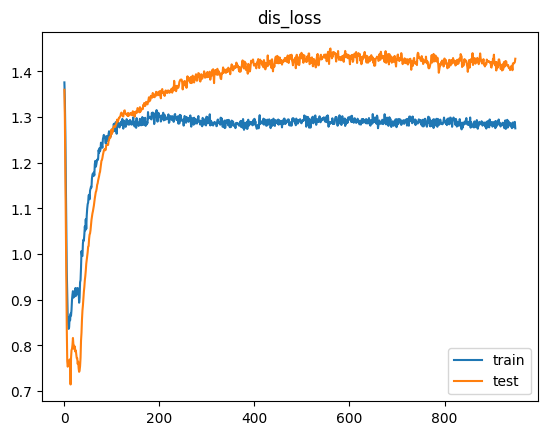

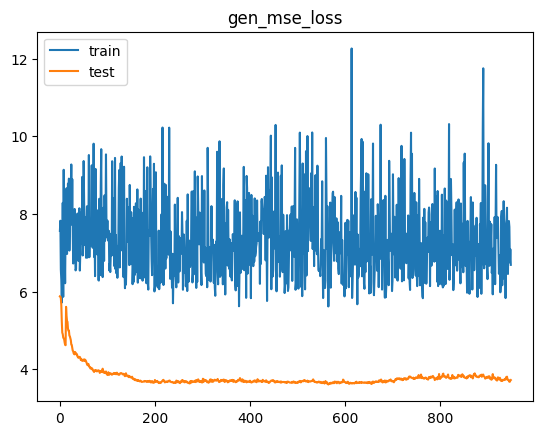

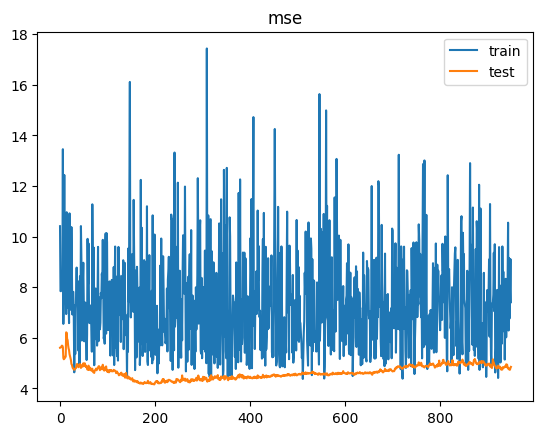

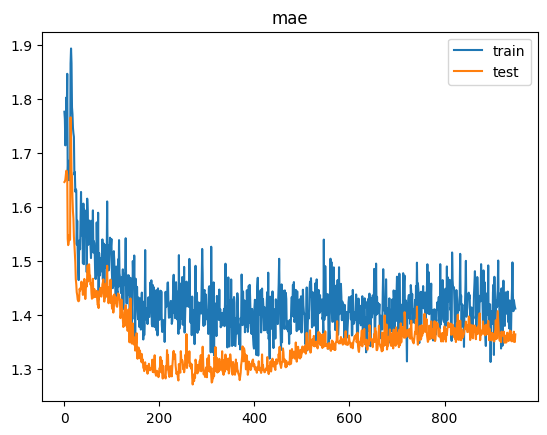

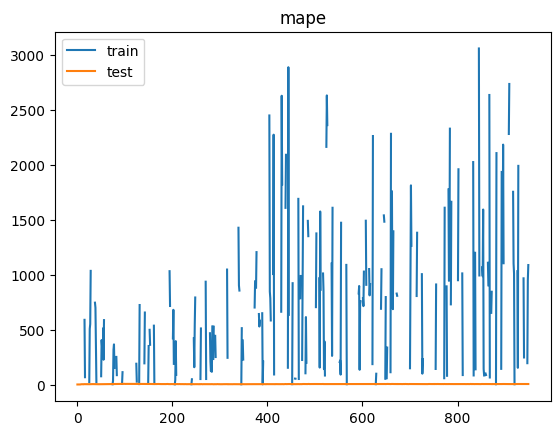

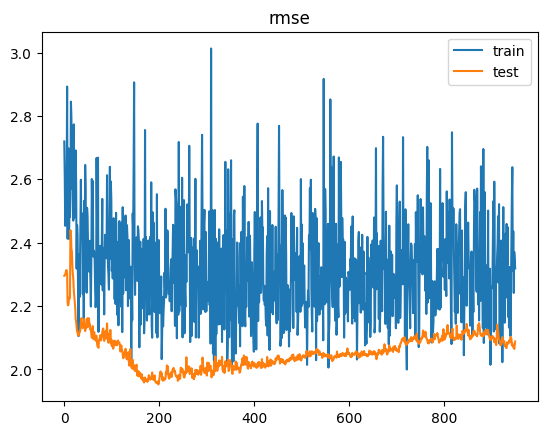

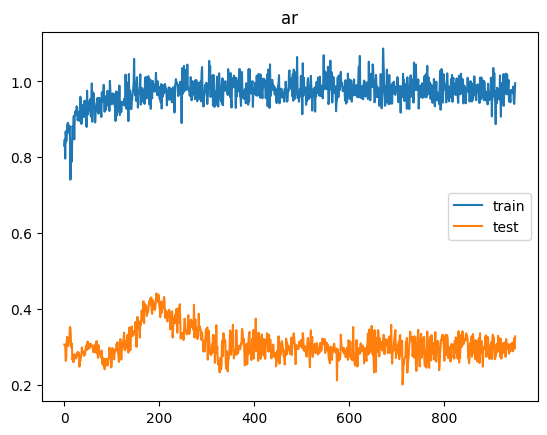

2/2 [==============================] - 0s 2ms/step


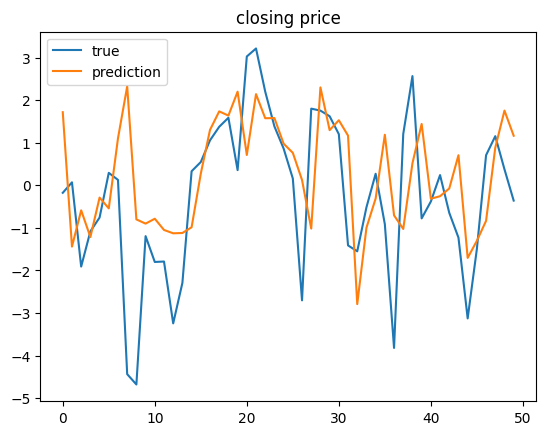

[MSE Baseline] train: 6.017044696454708  test: 4.1521541466081695
Delta time with epochs = 950: 0:13:09.888375


KeyboardInterrupt: 

In [21]:
for epochs in [950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 5, 10)             720       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                             

Time for epoch 53 is 0.7549951076507568 sec Generator Loss: 1.0244417190551758,  Discriminator_loss: 1.2186057567596436
Time for epoch 54 is 0.8005392551422119 sec Generator Loss: 0.9977145791053772,  Discriminator_loss: 1.2276474237442017
Time for epoch 55 is 0.7871181964874268 sec Generator Loss: 0.9875972867012024,  Discriminator_loss: 1.226791501045227
Time for epoch 56 is 0.75034499168396 sec Generator Loss: 0.9845488667488098,  Discriminator_loss: 1.22393798828125
Time for epoch 57 is 0.745929479598999 sec Generator Loss: 1.0023106336593628,  Discriminator_loss: 1.2412941455841064
Time for epoch 58 is 0.771235466003418 sec Generator Loss: 0.962615430355072,  Discriminator_loss: 1.2571176290512085
Time for epoch 59 is 0.9502518177032471 sec Generator Loss: 0.9781591892242432,  Discriminator_loss: 1.2426824569702148
Time for epoch 60 is 0.7574794292449951 sec Generator Loss: 0.9612449407577515,  Discriminator_loss: 1.2574843168258667
Time for epoch 61 is 0.8039066791534424 sec Gene

Time for epoch 122 is 0.7399575710296631 sec Generator Loss: 0.9515232443809509,  Discriminator_loss: 1.2719309329986572
Time for epoch 123 is 0.727269172668457 sec Generator Loss: 0.9482471942901611,  Discriminator_loss: 1.2707774639129639
Time for epoch 124 is 0.7288284301757812 sec Generator Loss: 0.9220951199531555,  Discriminator_loss: 1.278828501701355
Time for epoch 125 is 0.7245798110961914 sec Generator Loss: 0.9291443228721619,  Discriminator_loss: 1.26786208152771
Time for epoch 126 is 0.7247052192687988 sec Generator Loss: 0.9077810049057007,  Discriminator_loss: 1.285461664199829
Time for epoch 127 is 0.7356750965118408 sec Generator Loss: 0.9378927946090698,  Discriminator_loss: 1.2741966247558594
Time for epoch 128 is 0.7385573387145996 sec Generator Loss: 0.9311251640319824,  Discriminator_loss: 1.2846490144729614
Time for epoch 129 is 0.7322375774383545 sec Generator Loss: 0.9086586833000183,  Discriminator_loss: 1.271289587020874
Time for epoch 130 is 0.73620223999023

Time for epoch 190 is 0.7212982177734375 sec Generator Loss: 0.9249482154846191,  Discriminator_loss: 1.277166724205017
Time for epoch 191 is 0.7297148704528809 sec Generator Loss: 0.91592937707901,  Discriminator_loss: 1.2811675071716309
Time for epoch 192 is 0.7374253273010254 sec Generator Loss: 0.9113966822624207,  Discriminator_loss: 1.2731794118881226
Time for epoch 193 is 0.7262001037597656 sec Generator Loss: 0.9079384803771973,  Discriminator_loss: 1.2817590236663818
Time for epoch 194 is 0.7356150150299072 sec Generator Loss: 0.9055805206298828,  Discriminator_loss: 1.2835979461669922
Time for epoch 195 is 0.7579684257507324 sec Generator Loss: 0.8926934599876404,  Discriminator_loss: 1.2876100540161133
Time for epoch 196 is 0.7782344818115234 sec Generator Loss: 0.9091985821723938,  Discriminator_loss: 1.2706152200698853
Time for epoch 197 is 0.7887885570526123 sec Generator Loss: 0.9223466515541077,  Discriminator_loss: 1.2733533382415771
Time for epoch 198 is 0.76214885711

Time for epoch 259 is 0.8361935615539551 sec Generator Loss: 0.894331693649292,  Discriminator_loss: 1.2905826568603516
Time for epoch 260 is 0.9743435382843018 sec Generator Loss: 0.9047068953514099,  Discriminator_loss: 1.296029806137085
Time for epoch 261 is 1.0574188232421875 sec Generator Loss: 0.8874819278717041,  Discriminator_loss: 1.2884273529052734
Time for epoch 262 is 1.0059444904327393 sec Generator Loss: 0.9078930616378784,  Discriminator_loss: 1.2742407321929932
Time for epoch 263 is 0.9298250675201416 sec Generator Loss: 0.9217823147773743,  Discriminator_loss: 1.287071704864502
Time for epoch 264 is 0.8835172653198242 sec Generator Loss: 0.9259715676307678,  Discriminator_loss: 1.3008413314819336
Time for epoch 265 is 0.9602723121643066 sec Generator Loss: 0.906521737575531,  Discriminator_loss: 1.2935107946395874
Time for epoch 266 is 0.9891834259033203 sec Generator Loss: 0.8848608136177063,  Discriminator_loss: 1.3002824783325195
Time for epoch 267 is 0.971676826477

Time for epoch 327 is 0.8310432434082031 sec Generator Loss: 0.9022113084793091,  Discriminator_loss: 1.2944546937942505
Time for epoch 328 is 0.7615344524383545 sec Generator Loss: 0.9073038697242737,  Discriminator_loss: 1.2937719821929932
Time for epoch 329 is 0.8068361282348633 sec Generator Loss: 0.8910433650016785,  Discriminator_loss: 1.2959918975830078
Time for epoch 330 is 0.7706000804901123 sec Generator Loss: 0.8931348323822021,  Discriminator_loss: 1.2939116954803467
Time for epoch 331 is 0.79726243019104 sec Generator Loss: 0.8923341035842896,  Discriminator_loss: 1.3031036853790283
Time for epoch 332 is 0.7484292984008789 sec Generator Loss: 0.8782463073730469,  Discriminator_loss: 1.3091610670089722
Time for epoch 333 is 0.7408478260040283 sec Generator Loss: 0.8818906545639038,  Discriminator_loss: 1.2976646423339844
Time for epoch 334 is 0.8093471527099609 sec Generator Loss: 0.8850226998329163,  Discriminator_loss: 1.2966029644012451
Time for epoch 335 is 0.7697241306

Time for epoch 396 is 0.8375849723815918 sec Generator Loss: 0.8851503729820251,  Discriminator_loss: 1.3039357662200928
Time for epoch 397 is 0.729534387588501 sec Generator Loss: 0.8863109350204468,  Discriminator_loss: 1.292078971862793
Time for epoch 398 is 0.7326040267944336 sec Generator Loss: 0.8936152458190918,  Discriminator_loss: 1.2953252792358398
Time for epoch 399 is 0.732001781463623 sec Generator Loss: 0.8968765139579773,  Discriminator_loss: 1.3077527284622192
Time for epoch 400 is 0.7256462574005127 sec Generator Loss: 0.8865275382995605,  Discriminator_loss: 1.2889753580093384
Time for epoch 401 is 0.7320530414581299 sec Generator Loss: 0.874399721622467,  Discriminator_loss: 1.3065681457519531
Time for epoch 402 is 0.7329816818237305 sec Generator Loss: 0.8856698870658875,  Discriminator_loss: 1.303171157836914
Time for epoch 403 is 0.7289013862609863 sec Generator Loss: 0.8935403227806091,  Discriminator_loss: 1.2987706661224365
Time for epoch 404 is 0.7303214073181

Time for epoch 465 is 0.7328958511352539 sec Generator Loss: 0.8906242847442627,  Discriminator_loss: 1.2978659868240356
Time for epoch 466 is 0.7312057018280029 sec Generator Loss: 0.8857427835464478,  Discriminator_loss: 1.294218897819519
Time for epoch 467 is 0.738666296005249 sec Generator Loss: 0.8822548985481262,  Discriminator_loss: 1.2922824621200562
Time for epoch 468 is 0.7443816661834717 sec Generator Loss: 0.8999226093292236,  Discriminator_loss: 1.300747036933899
Time for epoch 469 is 0.7381851673126221 sec Generator Loss: 0.9170534014701843,  Discriminator_loss: 1.2852314710617065
Time for epoch 470 is 0.7326595783233643 sec Generator Loss: 0.8946468234062195,  Discriminator_loss: 1.2987853288650513
Time for epoch 471 is 0.732417106628418 sec Generator Loss: 0.8939588665962219,  Discriminator_loss: 1.2896655797958374
Time for epoch 472 is 0.7319064140319824 sec Generator Loss: 0.8993480205535889,  Discriminator_loss: 1.3077462911605835
Time for epoch 473 is 1.003901243209

Time for epoch 533 is 0.7283961772918701 sec Generator Loss: 0.9044070243835449,  Discriminator_loss: 1.2926315069198608
Time for epoch 534 is 0.7264118194580078 sec Generator Loss: 0.8922768235206604,  Discriminator_loss: 1.3062138557434082
Time for epoch 535 is 0.7295632362365723 sec Generator Loss: 0.8965334892272949,  Discriminator_loss: 1.3019874095916748
Time for epoch 536 is 0.7275145053863525 sec Generator Loss: 0.8859820365905762,  Discriminator_loss: 1.3046425580978394
Time for epoch 537 is 0.72576904296875 sec Generator Loss: 0.8841870427131653,  Discriminator_loss: 1.2950547933578491
Time for epoch 538 is 0.7310755252838135 sec Generator Loss: 0.8930445313453674,  Discriminator_loss: 1.2885775566101074
Time for epoch 539 is 0.8140523433685303 sec Generator Loss: 0.9290279746055603,  Discriminator_loss: 1.2872110605239868
Time for epoch 540 is 0.7425580024719238 sec Generator Loss: 0.9024865031242371,  Discriminator_loss: 1.2841018438339233
Time for epoch 541 is 0.7662472724

Time for epoch 602 is 0.7365520000457764 sec Generator Loss: 0.9212651252746582,  Discriminator_loss: 1.280221700668335
Time for epoch 603 is 0.7258858680725098 sec Generator Loss: 0.9038234353065491,  Discriminator_loss: 1.303449034690857
Time for epoch 604 is 0.7420198917388916 sec Generator Loss: 0.895011842250824,  Discriminator_loss: 1.2951053380966187
Time for epoch 605 is 0.8082916736602783 sec Generator Loss: 0.8865031599998474,  Discriminator_loss: 1.2878910303115845
Time for epoch 606 is 0.8538999557495117 sec Generator Loss: 0.888321042060852,  Discriminator_loss: 1.3006025552749634
Time for epoch 607 is 0.8915286064147949 sec Generator Loss: 0.9100610017776489,  Discriminator_loss: 1.2940746545791626
Time for epoch 608 is 0.734961748123169 sec Generator Loss: 0.8973658084869385,  Discriminator_loss: 1.2952154874801636
Time for epoch 609 is 0.7362520694732666 sec Generator Loss: 0.9304306507110596,  Discriminator_loss: 1.2782657146453857
Time for epoch 610 is 0.7312898635864

Time for epoch 670 is 1.0675685405731201 sec Generator Loss: 0.8995789885520935,  Discriminator_loss: 1.2957093715667725
Time for epoch 671 is 0.7305653095245361 sec Generator Loss: 0.8850595951080322,  Discriminator_loss: 1.295169472694397
Time for epoch 672 is 0.7341194152832031 sec Generator Loss: 0.9009678959846497,  Discriminator_loss: 1.2890247106552124
Time for epoch 673 is 0.7303316593170166 sec Generator Loss: 0.9017378687858582,  Discriminator_loss: 1.2920256853103638
Time for epoch 674 is 0.7430706024169922 sec Generator Loss: 0.9109525084495544,  Discriminator_loss: 1.2839040756225586
Time for epoch 675 is 0.7758424282073975 sec Generator Loss: 0.8971381783485413,  Discriminator_loss: 1.2936482429504395
Time for epoch 676 is 0.7779097557067871 sec Generator Loss: 0.9031845927238464,  Discriminator_loss: 1.2878503799438477
Time for epoch 677 is 0.806915283203125 sec Generator Loss: 0.9201086163520813,  Discriminator_loss: 1.2939013242721558
Time for epoch 678 is 0.7485334873

Time for epoch 738 is 0.7783792018890381 sec Generator Loss: 0.9104894399642944,  Discriminator_loss: 1.2787423133850098
Time for epoch 739 is 0.7545115947723389 sec Generator Loss: 0.9000882506370544,  Discriminator_loss: 1.2863315343856812
Time for epoch 740 is 0.753549337387085 sec Generator Loss: 0.9110437035560608,  Discriminator_loss: 1.2877883911132812
Time for epoch 741 is 0.7291896343231201 sec Generator Loss: 0.9213707447052002,  Discriminator_loss: 1.2775356769561768
Time for epoch 742 is 0.7244510650634766 sec Generator Loss: 0.9148135185241699,  Discriminator_loss: 1.2722221612930298
Time for epoch 743 is 0.8180792331695557 sec Generator Loss: 0.9131361246109009,  Discriminator_loss: 1.2960094213485718
Time for epoch 744 is 0.7533407211303711 sec Generator Loss: 0.9203973412513733,  Discriminator_loss: 1.281537413597107
Time for epoch 745 is 0.7478508949279785 sec Generator Loss: 0.9185502529144287,  Discriminator_loss: 1.2897591590881348
Time for epoch 746 is 0.7393946647

Time for epoch 807 is 0.7486159801483154 sec Generator Loss: 0.8940742611885071,  Discriminator_loss: 1.2875902652740479
Time for epoch 808 is 0.8091883659362793 sec Generator Loss: 0.9293116927146912,  Discriminator_loss: 1.2873889207839966
Time for epoch 809 is 0.9008357524871826 sec Generator Loss: 0.896634578704834,  Discriminator_loss: 1.294032335281372
Time for epoch 810 is 0.8568360805511475 sec Generator Loss: 0.911678671836853,  Discriminator_loss: 1.2864768505096436
Time for epoch 811 is 0.9185891151428223 sec Generator Loss: 0.9177107214927673,  Discriminator_loss: 1.2788406610488892
Time for epoch 812 is 0.9626994132995605 sec Generator Loss: 0.8979299068450928,  Discriminator_loss: 1.2835901975631714
Time for epoch 813 is 0.9049878120422363 sec Generator Loss: 0.9087370038032532,  Discriminator_loss: 1.2908704280853271
Time for epoch 814 is 0.8846306800842285 sec Generator Loss: 0.9181786775588989,  Discriminator_loss: 1.2876049280166626
Time for epoch 815 is 0.86578106880

Time for epoch 875 is 0.8470175266265869 sec Generator Loss: 0.906441330909729,  Discriminator_loss: 1.291946530342102
Time for epoch 876 is 0.8225736618041992 sec Generator Loss: 0.9328085780143738,  Discriminator_loss: 1.2892299890518188
Time for epoch 877 is 0.7444877624511719 sec Generator Loss: 0.9176982045173645,  Discriminator_loss: 1.2756985425949097
Time for epoch 878 is 0.7410304546356201 sec Generator Loss: 0.8985325694084167,  Discriminator_loss: 1.2938703298568726
Time for epoch 879 is 0.7412641048431396 sec Generator Loss: 0.9174644947052002,  Discriminator_loss: 1.2813760042190552
Time for epoch 880 is 0.7519545555114746 sec Generator Loss: 0.9219575524330139,  Discriminator_loss: 1.286492109298706
Time for epoch 881 is 0.7494313716888428 sec Generator Loss: 0.9216591715812683,  Discriminator_loss: 1.2866339683532715
Time for epoch 882 is 0.741804838180542 sec Generator Loss: 0.9303990602493286,  Discriminator_loss: 1.2899490594863892
Time for epoch 883 is 0.738884687423

Time for epoch 944 is 0.849898099899292 sec Generator Loss: 0.9040020108222961,  Discriminator_loss: 1.2865219116210938
Time for epoch 945 is 0.8708746433258057 sec Generator Loss: 0.8979196548461914,  Discriminator_loss: 1.2921167612075806
Time for epoch 946 is 0.8445682525634766 sec Generator Loss: 0.9021816253662109,  Discriminator_loss: 1.29276704788208
Time for epoch 947 is 0.8924074172973633 sec Generator Loss: 0.9126408100128174,  Discriminator_loss: 1.2831318378448486
Time for epoch 948 is 0.8392186164855957 sec Generator Loss: 0.9150568246841431,  Discriminator_loss: 1.293009877204895
Time for epoch 949 is 0.8358285427093506 sec Generator Loss: 0.9063509702682495,  Discriminator_loss: 1.2892770767211914
Time for epoch 950 is 0.8524208068847656 sec Generator Loss: 0.9158909916877747,  Discriminator_loss: 1.2991294860839844
Time for epoch 951 is 0.8475668430328369 sec Generator Loss: 0.9069179892539978,  Discriminator_loss: 1.287160038948059
Time for epoch 952 is 0.8474295139312

Time for epoch 1012 is 0.7353687286376953 sec Generator Loss: 0.9211822152137756,  Discriminator_loss: 1.2838172912597656
Time for epoch 1013 is 0.7399570941925049 sec Generator Loss: 0.913848340511322,  Discriminator_loss: 1.2914425134658813
Time for epoch 1014 is 0.7367689609527588 sec Generator Loss: 0.8954750299453735,  Discriminator_loss: 1.291502594947815
Time for epoch 1015 is 0.7413859367370605 sec Generator Loss: 0.9107109308242798,  Discriminator_loss: 1.2972686290740967
Time for epoch 1016 is 0.7454509735107422 sec Generator Loss: 0.900740385055542,  Discriminator_loss: 1.2865206003189087
Time for epoch 1017 is 0.8008952140808105 sec Generator Loss: 0.9110441207885742,  Discriminator_loss: 1.2878390550613403
Time for epoch 1018 is 0.8035850524902344 sec Generator Loss: 0.9093853235244751,  Discriminator_loss: 1.2906320095062256
Time for epoch 1019 is 0.7583127021789551 sec Generator Loss: 0.8988915681838989,  Discriminator_loss: 1.2906805276870728
Time for epoch 1020 is 0.80

Time for epoch 1080 is 0.835195779800415 sec Generator Loss: 0.9201647639274597,  Discriminator_loss: 1.2949762344360352
Time for epoch 1081 is 0.7851686477661133 sec Generator Loss: 0.9020595550537109,  Discriminator_loss: 1.2923603057861328
Time for epoch 1082 is 0.8420884609222412 sec Generator Loss: 0.9224448204040527,  Discriminator_loss: 1.2905153036117554
Time for epoch 1083 is 0.7367537021636963 sec Generator Loss: 0.9057894349098206,  Discriminator_loss: 1.2919567823410034
Time for epoch 1084 is 0.7330269813537598 sec Generator Loss: 0.8855273127555847,  Discriminator_loss: 1.2971588373184204
Time for epoch 1085 is 0.7284669876098633 sec Generator Loss: 0.9102532267570496,  Discriminator_loss: 1.2896065711975098
Time for epoch 1086 is 0.7264058589935303 sec Generator Loss: 0.9276818633079529,  Discriminator_loss: 1.2855138778686523
Time for epoch 1087 is 0.7407422065734863 sec Generator Loss: 0.8978380560874939,  Discriminator_loss: 1.2897437810897827
Time for epoch 1088 is 0.

Time for epoch 1148 is 0.7308573722839355 sec Generator Loss: 0.909450888633728,  Discriminator_loss: 1.2748185396194458
Time for epoch 1149 is 0.733677864074707 sec Generator Loss: 0.9118968844413757,  Discriminator_loss: 1.286582112312317
Time for epoch 1150 is 0.7606232166290283 sec Generator Loss: 0.903301477432251,  Discriminator_loss: 1.2830206155776978
Time for epoch 1151 is 0.7491862773895264 sec Generator Loss: 0.9048397541046143,  Discriminator_loss: 1.2889277935028076
Time for epoch 1152 is 0.7850582599639893 sec Generator Loss: 0.9085747599601746,  Discriminator_loss: 1.298133373260498
Time for epoch 1153 is 0.7953188419342041 sec Generator Loss: 0.9087619781494141,  Discriminator_loss: 1.2808831930160522
Time for epoch 1154 is 0.8069794178009033 sec Generator Loss: 0.9171767830848694,  Discriminator_loss: 1.2868479490280151
Time for epoch 1155 is 0.7450389862060547 sec Generator Loss: 0.9472724199295044,  Discriminator_loss: 1.2792805433273315
Time for epoch 1156 is 0.7481

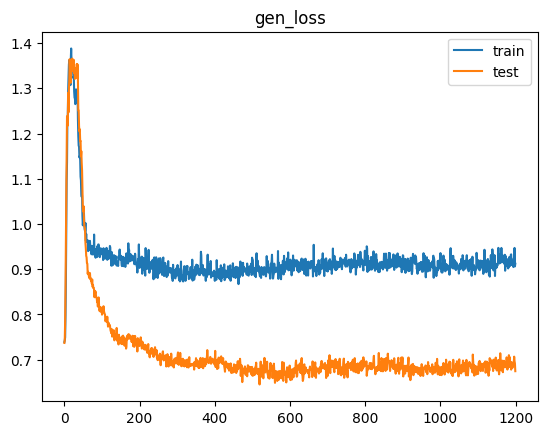

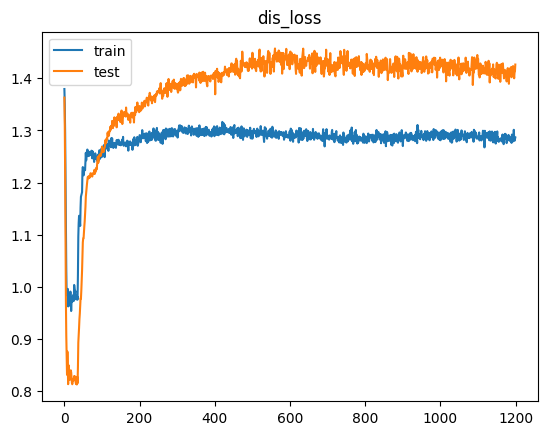

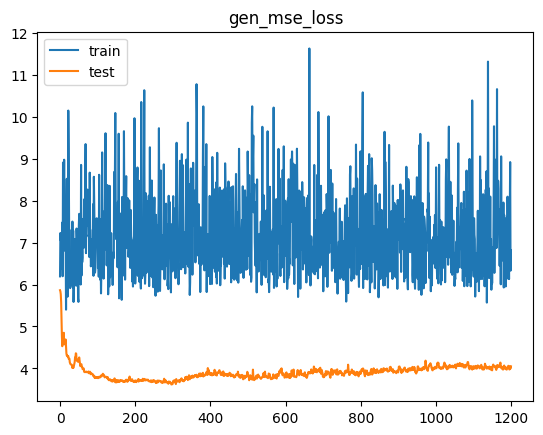

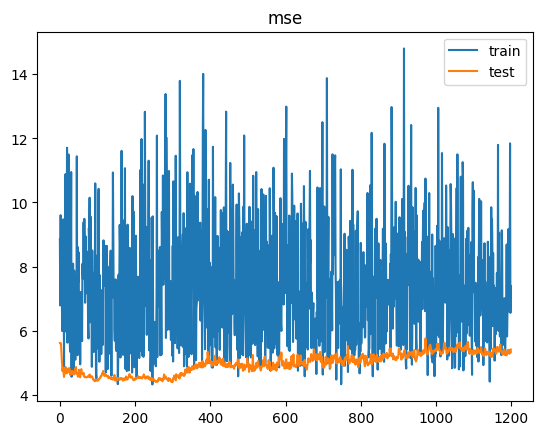

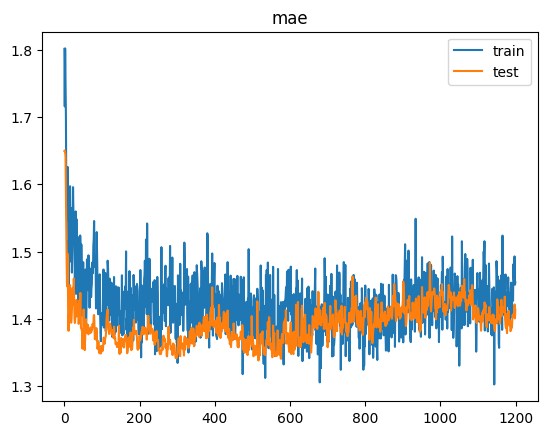

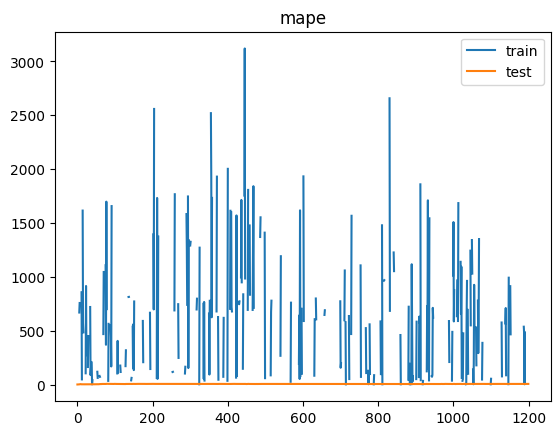

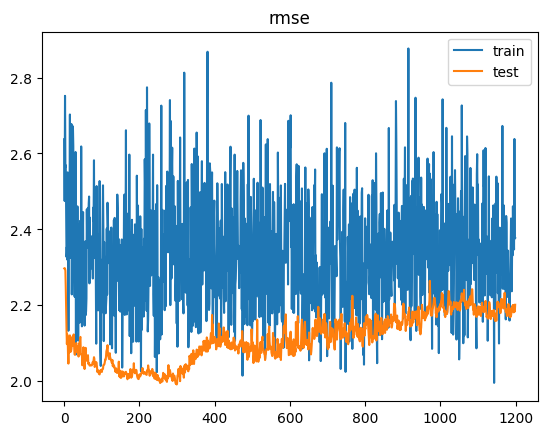

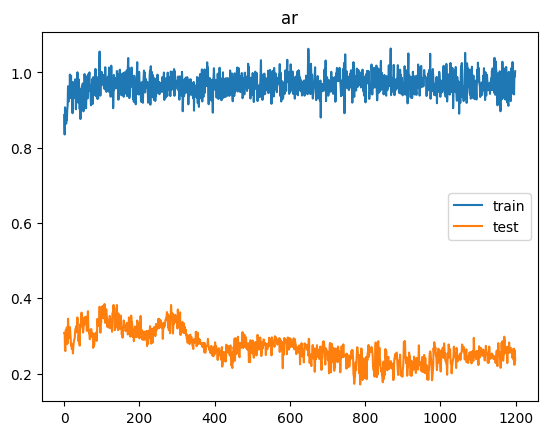

2/2 [==============================] - 0s 4ms/step


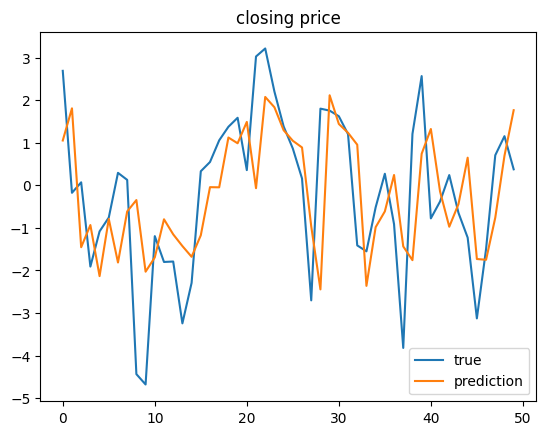

[MSE Baseline] train: 8.751454751180038  test: 4.137918162168212
Delta time with epochs = 1200: 0:15:43.599529
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 lstm_3 (LSTM)

Time for epoch 52 is 0.7417623996734619 sec Generator Loss: 0.931968629360199,  Discriminator_loss: 1.269299030303955
Time for epoch 53 is 0.7484614849090576 sec Generator Loss: 0.9277976155281067,  Discriminator_loss: 1.2742774486541748
Time for epoch 54 is 0.7397933006286621 sec Generator Loss: 0.9023870825767517,  Discriminator_loss: 1.2784303426742554
Time for epoch 55 is 0.7408668994903564 sec Generator Loss: 0.9058483839035034,  Discriminator_loss: 1.263986587524414
Time for epoch 56 is 0.7399334907531738 sec Generator Loss: 0.89583420753479,  Discriminator_loss: 1.2689828872680664
Time for epoch 57 is 0.7343935966491699 sec Generator Loss: 0.9116793870925903,  Discriminator_loss: 1.2668291330337524
Time for epoch 58 is 0.7376194000244141 sec Generator Loss: 0.9049081802368164,  Discriminator_loss: 1.2666970491409302
Time for epoch 59 is 0.7339961528778076 sec Generator Loss: 0.9027899503707886,  Discriminator_loss: 1.2815544605255127
Time for epoch 60 is 0.7446186542510986 sec G

Time for epoch 121 is 0.739466667175293 sec Generator Loss: 0.8818204998970032,  Discriminator_loss: 1.2928187847137451
Time for epoch 122 is 0.761500358581543 sec Generator Loss: 0.8686314225196838,  Discriminator_loss: 1.305152177810669
Time for epoch 123 is 0.7545015811920166 sec Generator Loss: 0.8930551409721375,  Discriminator_loss: 1.2930245399475098
Time for epoch 124 is 0.7393579483032227 sec Generator Loss: 0.885407567024231,  Discriminator_loss: 1.2980185747146606
Time for epoch 125 is 0.7399859428405762 sec Generator Loss: 0.8794205188751221,  Discriminator_loss: 1.299192190170288
Time for epoch 126 is 0.7445142269134521 sec Generator Loss: 0.8786377906799316,  Discriminator_loss: 1.3016598224639893
Time for epoch 127 is 0.7418580055236816 sec Generator Loss: 0.8988434076309204,  Discriminator_loss: 1.3007171154022217
Time for epoch 128 is 0.7471988201141357 sec Generator Loss: 0.8736187815666199,  Discriminator_loss: 1.302453875541687
Time for epoch 129 is 0.76396274566650

Time for epoch 190 is 0.743316650390625 sec Generator Loss: 0.869818389415741,  Discriminator_loss: 1.3070683479309082
Time for epoch 191 is 0.7370095252990723 sec Generator Loss: 0.8691754341125488,  Discriminator_loss: 1.3038543462753296
Time for epoch 192 is 0.7336924076080322 sec Generator Loss: 0.8798233270645142,  Discriminator_loss: 1.3000165224075317
Time for epoch 193 is 0.7216064929962158 sec Generator Loss: 0.8690086603164673,  Discriminator_loss: 1.307539939880371
Time for epoch 194 is 0.7259304523468018 sec Generator Loss: 0.8716447949409485,  Discriminator_loss: 1.300054907798767
Time for epoch 195 is 0.7330524921417236 sec Generator Loss: 0.855231523513794,  Discriminator_loss: 1.2993128299713135
Time for epoch 196 is 0.7281436920166016 sec Generator Loss: 0.8891412615776062,  Discriminator_loss: 1.3010777235031128
Time for epoch 197 is 0.7319610118865967 sec Generator Loss: 0.8725572228431702,  Discriminator_loss: 1.3059684038162231
Time for epoch 198 is 0.7125234603881

Time for epoch 259 is 0.7384657859802246 sec Generator Loss: 0.8787609934806824,  Discriminator_loss: 1.3098609447479248
Time for epoch 260 is 0.7517662048339844 sec Generator Loss: 0.8900173306465149,  Discriminator_loss: 1.2940582036972046
Time for epoch 261 is 0.7533619403839111 sec Generator Loss: 0.9024958610534668,  Discriminator_loss: 1.295920491218567
Time for epoch 262 is 0.7471001148223877 sec Generator Loss: 0.8939573764801025,  Discriminator_loss: 1.3011815547943115
Time for epoch 263 is 0.7357819080352783 sec Generator Loss: 0.8815999627113342,  Discriminator_loss: 1.2876564264297485
Time for epoch 264 is 0.7423436641693115 sec Generator Loss: 0.8797692656517029,  Discriminator_loss: 1.295128583908081
Time for epoch 265 is 0.7275214195251465 sec Generator Loss: 0.8832345008850098,  Discriminator_loss: 1.2932426929473877
Time for epoch 266 is 0.7381613254547119 sec Generator Loss: 0.8894824981689453,  Discriminator_loss: 1.2993494272232056
Time for epoch 267 is 0.7369539737

Time for epoch 327 is 0.7611851692199707 sec Generator Loss: 0.8982817530632019,  Discriminator_loss: 1.2918318510055542
Time for epoch 328 is 0.8250272274017334 sec Generator Loss: 0.9051145911216736,  Discriminator_loss: 1.2840577363967896
Time for epoch 329 is 0.7870330810546875 sec Generator Loss: 0.9131997227668762,  Discriminator_loss: 1.2862634658813477
Time for epoch 330 is 0.7511630058288574 sec Generator Loss: 0.8935618996620178,  Discriminator_loss: 1.2815884351730347
Time for epoch 331 is 0.7513206005096436 sec Generator Loss: 0.903984785079956,  Discriminator_loss: 1.2719908952713013
Time for epoch 332 is 0.7560412883758545 sec Generator Loss: 0.9093315005302429,  Discriminator_loss: 1.2880140542984009
Time for epoch 333 is 0.7503581047058105 sec Generator Loss: 0.9039887189865112,  Discriminator_loss: 1.2792296409606934
Time for epoch 334 is 0.7556018829345703 sec Generator Loss: 0.8899006843566895,  Discriminator_loss: 1.2938202619552612
Time for epoch 335 is 0.749621629

Time for epoch 395 is 0.8066956996917725 sec Generator Loss: 0.9155201315879822,  Discriminator_loss: 1.2837294340133667
Time for epoch 396 is 0.7849633693695068 sec Generator Loss: 0.9002196192741394,  Discriminator_loss: 1.284045934677124
Time for epoch 397 is 0.7987771034240723 sec Generator Loss: 0.9066806435585022,  Discriminator_loss: 1.285607933998108
Time for epoch 398 is 0.7748267650604248 sec Generator Loss: 0.9124090671539307,  Discriminator_loss: 1.2776869535446167
Time for epoch 399 is 0.7534530162811279 sec Generator Loss: 0.9303504824638367,  Discriminator_loss: 1.270974040031433
Time for epoch 400 is 0.8153789043426514 sec Generator Loss: 0.9245409369468689,  Discriminator_loss: 1.2841416597366333
Time for epoch 401 is 0.7518489360809326 sec Generator Loss: 0.9172251224517822,  Discriminator_loss: 1.284125566482544
Time for epoch 402 is 0.7544503211975098 sec Generator Loss: 0.911392331123352,  Discriminator_loss: 1.2713301181793213
Time for epoch 403 is 0.7777037620544

Time for epoch 464 is 0.7477977275848389 sec Generator Loss: 0.9104791283607483,  Discriminator_loss: 1.287249207496643
Time for epoch 465 is 0.7467255592346191 sec Generator Loss: 0.89674973487854,  Discriminator_loss: 1.285691499710083
Time for epoch 466 is 0.8307089805603027 sec Generator Loss: 0.9191018342971802,  Discriminator_loss: 1.2786592245101929
Time for epoch 467 is 0.7795712947845459 sec Generator Loss: 0.9059531688690186,  Discriminator_loss: 1.2781128883361816
Time for epoch 468 is 0.8660707473754883 sec Generator Loss: 0.9367675185203552,  Discriminator_loss: 1.267038106918335
Time for epoch 469 is 0.775684118270874 sec Generator Loss: 0.9059596657752991,  Discriminator_loss: 1.272036075592041
Time for epoch 470 is 0.7654967308044434 sec Generator Loss: 0.9158711433410645,  Discriminator_loss: 1.2753410339355469
Time for epoch 471 is 0.7681412696838379 sec Generator Loss: 0.9207326769828796,  Discriminator_loss: 1.2792260646820068
Time for epoch 472 is 0.831460475921630

Time for epoch 533 is 0.7447521686553955 sec Generator Loss: 0.9267174005508423,  Discriminator_loss: 1.2790802717208862
Time for epoch 534 is 0.7583832740783691 sec Generator Loss: 0.9001905918121338,  Discriminator_loss: 1.278807520866394
Time for epoch 535 is 0.7607719898223877 sec Generator Loss: 0.9158173203468323,  Discriminator_loss: 1.2822281122207642
Time for epoch 536 is 0.7855117321014404 sec Generator Loss: 0.9128942489624023,  Discriminator_loss: 1.2754316329956055
Time for epoch 537 is 0.7573409080505371 sec Generator Loss: 0.9093015193939209,  Discriminator_loss: 1.2774195671081543
Time for epoch 538 is 0.7710227966308594 sec Generator Loss: 0.919257402420044,  Discriminator_loss: 1.274221420288086
Time for epoch 539 is 0.8044910430908203 sec Generator Loss: 0.9215071797370911,  Discriminator_loss: 1.280503273010254
Time for epoch 540 is 0.7629392147064209 sec Generator Loss: 0.9229869842529297,  Discriminator_loss: 1.2739055156707764
Time for epoch 541 is 0.752435445785

Time for epoch 601 is 0.7458579540252686 sec Generator Loss: 0.9182538986206055,  Discriminator_loss: 1.2620952129364014
Time for epoch 602 is 0.7552921772003174 sec Generator Loss: 0.9216625094413757,  Discriminator_loss: 1.2746235132217407
Time for epoch 603 is 0.7426722049713135 sec Generator Loss: 0.9006452560424805,  Discriminator_loss: 1.286935567855835
Time for epoch 604 is 0.7476603984832764 sec Generator Loss: 0.8892019987106323,  Discriminator_loss: 1.2918181419372559
Time for epoch 605 is 0.7459001541137695 sec Generator Loss: 0.90666663646698,  Discriminator_loss: 1.2866238355636597
Time for epoch 606 is 0.7492005825042725 sec Generator Loss: 0.9100178480148315,  Discriminator_loss: 1.2726370096206665
Time for epoch 607 is 0.744112491607666 sec Generator Loss: 0.9155410528182983,  Discriminator_loss: 1.2813254594802856
Time for epoch 608 is 0.7384858131408691 sec Generator Loss: 0.9243336915969849,  Discriminator_loss: 1.2849160432815552
Time for epoch 609 is 0.746067762374

Time for epoch 670 is 0.7399759292602539 sec Generator Loss: 0.9059190154075623,  Discriminator_loss: 1.2750647068023682
Time for epoch 671 is 0.742356538772583 sec Generator Loss: 0.926225483417511,  Discriminator_loss: 1.2828766107559204
Time for epoch 672 is 0.7423486709594727 sec Generator Loss: 0.9060445427894592,  Discriminator_loss: 1.2881669998168945
Time for epoch 673 is 0.7522127628326416 sec Generator Loss: 0.9039880633354187,  Discriminator_loss: 1.2772009372711182
Time for epoch 674 is 0.7476460933685303 sec Generator Loss: 0.9048370718955994,  Discriminator_loss: 1.2889220714569092
Time for epoch 675 is 0.745384693145752 sec Generator Loss: 0.9100349545478821,  Discriminator_loss: 1.2813634872436523
Time for epoch 676 is 0.746253490447998 sec Generator Loss: 0.9001705050468445,  Discriminator_loss: 1.2810343503952026
Time for epoch 677 is 0.743283748626709 sec Generator Loss: 0.9140987992286682,  Discriminator_loss: 1.2830320596694946
Time for epoch 678 is 0.7400226593017

Time for epoch 738 is 0.9800941944122314 sec Generator Loss: 0.8972502946853638,  Discriminator_loss: 1.294508695602417
Time for epoch 739 is 1.0053050518035889 sec Generator Loss: 0.9012474417686462,  Discriminator_loss: 1.2883023023605347
Time for epoch 740 is 0.8867166042327881 sec Generator Loss: 0.9109534025192261,  Discriminator_loss: 1.2900059223175049
Time for epoch 741 is 0.7987620830535889 sec Generator Loss: 0.896440327167511,  Discriminator_loss: 1.2875794172286987
Time for epoch 742 is 0.7783377170562744 sec Generator Loss: 0.9142939448356628,  Discriminator_loss: 1.2881089448928833
Time for epoch 743 is 0.8272147178649902 sec Generator Loss: 0.8876029253005981,  Discriminator_loss: 1.284253478050232
Time for epoch 744 is 0.7547852993011475 sec Generator Loss: 0.9037973284721375,  Discriminator_loss: 1.2832385301589966
Time for epoch 745 is 0.7581720352172852 sec Generator Loss: 0.9007104635238647,  Discriminator_loss: 1.296230673789978
Time for epoch 746 is 0.747334957122

Time for epoch 806 is 0.8185651302337646 sec Generator Loss: 0.9093839526176453,  Discriminator_loss: 1.2933224439620972
Time for epoch 807 is 0.849287748336792 sec Generator Loss: 0.8919192552566528,  Discriminator_loss: 1.3073877096176147
Time for epoch 808 is 0.8648886680603027 sec Generator Loss: 0.8844573497772217,  Discriminator_loss: 1.3068498373031616
Time for epoch 809 is 0.8076136112213135 sec Generator Loss: 0.9052395820617676,  Discriminator_loss: 1.2946858406066895
Time for epoch 810 is 0.7911601066589355 sec Generator Loss: 0.8926907181739807,  Discriminator_loss: 1.290610909461975
Time for epoch 811 is 0.7848243713378906 sec Generator Loss: 0.8780815005302429,  Discriminator_loss: 1.3017510175704956
Time for epoch 812 is 0.9221434593200684 sec Generator Loss: 0.8987704515457153,  Discriminator_loss: 1.2843925952911377
Time for epoch 813 is 0.7756714820861816 sec Generator Loss: 0.902662456035614,  Discriminator_loss: 1.2838501930236816
Time for epoch 814 is 0.82755208015

Time for epoch 875 is 0.7717239856719971 sec Generator Loss: 0.9057555198669434,  Discriminator_loss: 1.3007103204727173
Time for epoch 876 is 0.7770595550537109 sec Generator Loss: 0.8842689394950867,  Discriminator_loss: 1.3028138875961304
Time for epoch 877 is 0.7733864784240723 sec Generator Loss: 0.9065914154052734,  Discriminator_loss: 1.2946754693984985
Time for epoch 878 is 0.7768173217773438 sec Generator Loss: 0.8861369490623474,  Discriminator_loss: 1.3033382892608643
Time for epoch 879 is 0.7809748649597168 sec Generator Loss: 0.8791761994361877,  Discriminator_loss: 1.3037680387496948
Time for epoch 880 is 0.8350667953491211 sec Generator Loss: 0.8842360377311707,  Discriminator_loss: 1.2902686595916748
Time for epoch 881 is 0.8354513645172119 sec Generator Loss: 0.8973490595817566,  Discriminator_loss: 1.3003017902374268
Time for epoch 882 is 0.8987994194030762 sec Generator Loss: 0.8890665769577026,  Discriminator_loss: 1.296041488647461
Time for epoch 883 is 0.823447704

Time for epoch 943 is 0.7430837154388428 sec Generator Loss: 0.8949642777442932,  Discriminator_loss: 1.2886955738067627
Time for epoch 944 is 0.7428138256072998 sec Generator Loss: 0.8920238018035889,  Discriminator_loss: 1.2985541820526123
Time for epoch 945 is 0.746929407119751 sec Generator Loss: 0.8883510231971741,  Discriminator_loss: 1.303108811378479
Time for epoch 946 is 0.7612545490264893 sec Generator Loss: 0.8846518397331238,  Discriminator_loss: 1.2922085523605347
Time for epoch 947 is 0.7529432773590088 sec Generator Loss: 0.894976019859314,  Discriminator_loss: 1.2921953201293945
Time for epoch 948 is 0.7715396881103516 sec Generator Loss: 0.8994743227958679,  Discriminator_loss: 1.2906256914138794
Time for epoch 949 is 0.7581171989440918 sec Generator Loss: 0.8855567574501038,  Discriminator_loss: 1.304113507270813
Time for epoch 950 is 0.7745175361633301 sec Generator Loss: 0.8992305397987366,  Discriminator_loss: 1.296165943145752
Time for epoch 951 is 0.7709462642669

Time for epoch 1011 is 0.7751097679138184 sec Generator Loss: 0.898287296295166,  Discriminator_loss: 1.2925262451171875
Time for epoch 1012 is 0.7893733978271484 sec Generator Loss: 0.8879321813583374,  Discriminator_loss: 1.3019561767578125
Time for epoch 1013 is 0.8051927089691162 sec Generator Loss: 0.891915500164032,  Discriminator_loss: 1.2929518222808838
Time for epoch 1014 is 0.8725028038024902 sec Generator Loss: 0.8832384347915649,  Discriminator_loss: 1.2943788766860962
Time for epoch 1015 is 0.8731770515441895 sec Generator Loss: 0.9140419363975525,  Discriminator_loss: 1.2984918355941772
Time for epoch 1016 is 0.8771336078643799 sec Generator Loss: 0.8911661505699158,  Discriminator_loss: 1.2931932210922241
Time for epoch 1017 is 0.7970261573791504 sec Generator Loss: 0.871600866317749,  Discriminator_loss: 1.3061639070510864
Time for epoch 1018 is 0.8315591812133789 sec Generator Loss: 0.9291260838508606,  Discriminator_loss: 1.2982618808746338
Time for epoch 1019 is 0.79

Time for epoch 1079 is 0.7473077774047852 sec Generator Loss: 0.9019386172294617,  Discriminator_loss: 1.3004690408706665
Time for epoch 1080 is 0.7723102569580078 sec Generator Loss: 0.8998976945877075,  Discriminator_loss: 1.2986116409301758
Time for epoch 1081 is 0.7571320533752441 sec Generator Loss: 0.8853122591972351,  Discriminator_loss: 1.301043152809143
Time for epoch 1082 is 0.7617428302764893 sec Generator Loss: 0.886133074760437,  Discriminator_loss: 1.2971563339233398
Time for epoch 1083 is 0.7436981201171875 sec Generator Loss: 0.8870065808296204,  Discriminator_loss: 1.3044764995574951
Time for epoch 1084 is 0.7469658851623535 sec Generator Loss: 0.8840101361274719,  Discriminator_loss: 1.3013781309127808
Time for epoch 1085 is 0.7503652572631836 sec Generator Loss: 0.8691877126693726,  Discriminator_loss: 1.3073573112487793
Time for epoch 1086 is 0.7494614124298096 sec Generator Loss: 0.877913773059845,  Discriminator_loss: 1.2954236268997192
Time for epoch 1087 is 0.75

Time for epoch 1147 is 0.7504520416259766 sec Generator Loss: 0.8952207565307617,  Discriminator_loss: 1.2991623878479004
Time for epoch 1148 is 0.7616727352142334 sec Generator Loss: 0.8969365358352661,  Discriminator_loss: 1.3003052473068237
Time for epoch 1149 is 0.7593522071838379 sec Generator Loss: 0.877602756023407,  Discriminator_loss: 1.2995105981826782
Time for epoch 1150 is 0.7704160213470459 sec Generator Loss: 0.8854603171348572,  Discriminator_loss: 1.2971949577331543
Time for epoch 1151 is 0.7547502517700195 sec Generator Loss: 0.8850053548812866,  Discriminator_loss: 1.2977393865585327
Time for epoch 1152 is 0.7595040798187256 sec Generator Loss: 0.873995304107666,  Discriminator_loss: 1.3015481233596802
Time for epoch 1153 is 0.7573692798614502 sec Generator Loss: 0.890161395072937,  Discriminator_loss: 1.2980412244796753
Time for epoch 1154 is 0.7458639144897461 sec Generator Loss: 0.8747466206550598,  Discriminator_loss: 1.3090946674346924
Time for epoch 1155 is 0.85

Time for epoch 1215 is 0.8253178596496582 sec Generator Loss: 0.8742946982383728,  Discriminator_loss: 1.3005998134613037
Time for epoch 1216 is 0.8067855834960938 sec Generator Loss: 0.8916585445404053,  Discriminator_loss: 1.3029074668884277
Time for epoch 1217 is 0.8902177810668945 sec Generator Loss: 0.8685516119003296,  Discriminator_loss: 1.307976484298706
Time for epoch 1218 is 0.8215348720550537 sec Generator Loss: 0.8903892636299133,  Discriminator_loss: 1.2942317724227905
Time for epoch 1219 is 0.8185887336730957 sec Generator Loss: 0.8685242533683777,  Discriminator_loss: 1.3020298480987549
Time for epoch 1220 is 0.8207697868347168 sec Generator Loss: 0.9056721329689026,  Discriminator_loss: 1.3013958930969238
Time for epoch 1221 is 0.7927541732788086 sec Generator Loss: 0.8877641558647156,  Discriminator_loss: 1.309926152229309
Time for epoch 1222 is 0.810147762298584 sec Generator Loss: 0.8791520595550537,  Discriminator_loss: 1.3010025024414062
Time for epoch 1223 is 0.78

Time for epoch 1283 is 0.7964093685150146 sec Generator Loss: 0.8694917559623718,  Discriminator_loss: 1.3071409463882446
Time for epoch 1284 is 0.783541202545166 sec Generator Loss: 0.8981499075889587,  Discriminator_loss: 1.291670799255371
Time for epoch 1285 is 0.7737729549407959 sec Generator Loss: 0.9057181477546692,  Discriminator_loss: 1.29874587059021
Time for epoch 1286 is 0.7575728893280029 sec Generator Loss: 0.8706055879592896,  Discriminator_loss: 1.2961612939834595
Time for epoch 1287 is 0.7854518890380859 sec Generator Loss: 0.8900656700134277,  Discriminator_loss: 1.3053925037384033
Time for epoch 1288 is 0.7633564472198486 sec Generator Loss: 0.896873950958252,  Discriminator_loss: 1.296770453453064
Time for epoch 1289 is 0.7562861442565918 sec Generator Loss: 0.8779441118240356,  Discriminator_loss: 1.303255319595337
Time for epoch 1290 is 0.7517051696777344 sec Generator Loss: 0.8885059952735901,  Discriminator_loss: 1.3011538982391357
Time for epoch 1291 is 0.783900

Time for epoch 1351 is 0.8110783100128174 sec Generator Loss: 0.8965244293212891,  Discriminator_loss: 1.2914854288101196
Time for epoch 1352 is 0.7630772590637207 sec Generator Loss: 0.8942247033119202,  Discriminator_loss: 1.297075867652893
Time for epoch 1353 is 0.8293631076812744 sec Generator Loss: 0.8835299611091614,  Discriminator_loss: 1.3022844791412354
Time for epoch 1354 is 0.7891759872436523 sec Generator Loss: 0.873422384262085,  Discriminator_loss: 1.3030073642730713
Time for epoch 1355 is 0.8245174884796143 sec Generator Loss: 0.8791952729225159,  Discriminator_loss: 1.3074686527252197
Time for epoch 1356 is 0.7800416946411133 sec Generator Loss: 0.8831778764724731,  Discriminator_loss: 1.3058899641036987
Time for epoch 1357 is 0.7892782688140869 sec Generator Loss: 0.8710157871246338,  Discriminator_loss: 1.3050569295883179
Time for epoch 1358 is 0.8317880630493164 sec Generator Loss: 0.8858246207237244,  Discriminator_loss: 1.301338791847229
Time for epoch 1359 is 0.82

Time for epoch 1419 is 0.8278484344482422 sec Generator Loss: 0.8802911043167114,  Discriminator_loss: 1.3054108619689941
Time for epoch 1420 is 0.757387638092041 sec Generator Loss: 0.8845762610435486,  Discriminator_loss: 1.2941575050354004
Time for epoch 1421 is 0.7672436237335205 sec Generator Loss: 0.8911277055740356,  Discriminator_loss: 1.2964975833892822
Time for epoch 1422 is 0.8037247657775879 sec Generator Loss: 0.8906509876251221,  Discriminator_loss: 1.2985543012619019
Time for epoch 1423 is 0.7842416763305664 sec Generator Loss: 0.899848997592926,  Discriminator_loss: 1.296384334564209
Time for epoch 1424 is 0.7637698650360107 sec Generator Loss: 0.8663552403450012,  Discriminator_loss: 1.3145108222961426
Time for epoch 1425 is 0.7540619373321533 sec Generator Loss: 0.894550621509552,  Discriminator_loss: 1.3046669960021973
Time for epoch 1426 is 0.7629289627075195 sec Generator Loss: 0.8710753321647644,  Discriminator_loss: 1.305060863494873
Time for epoch 1427 is 0.7803

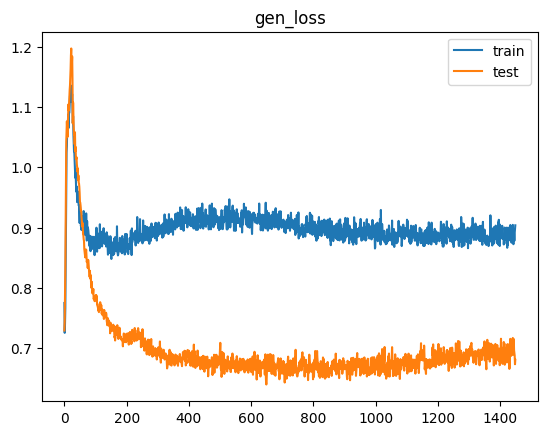

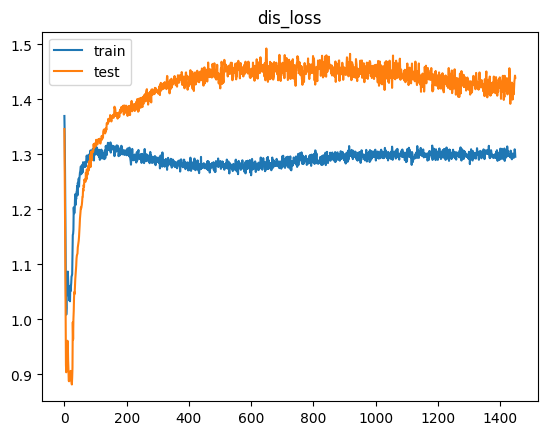

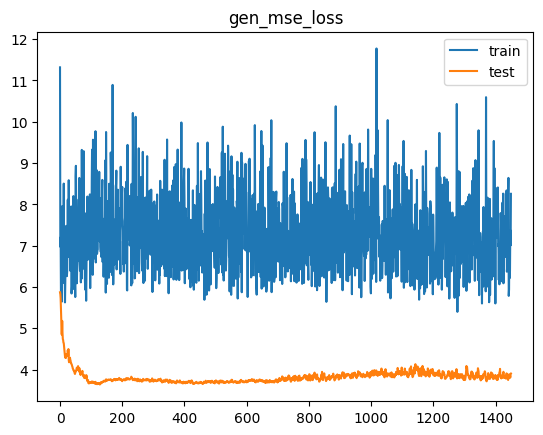

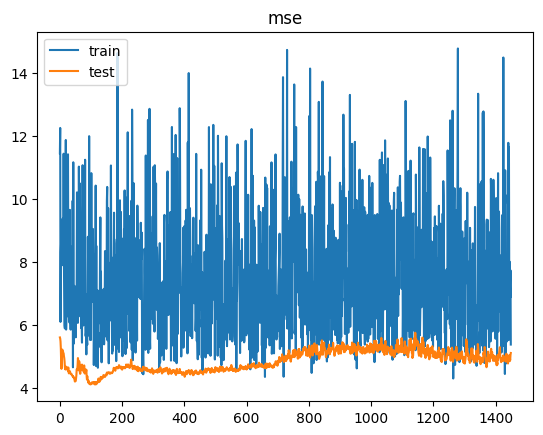

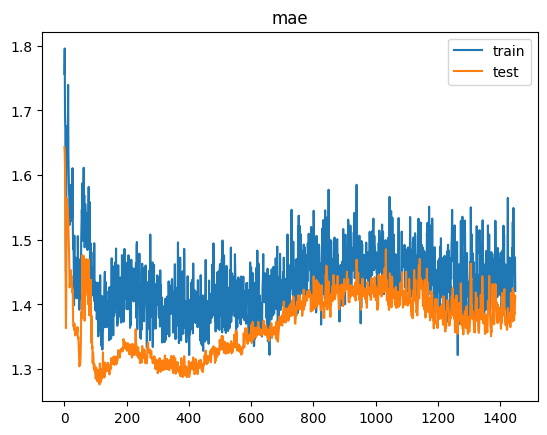

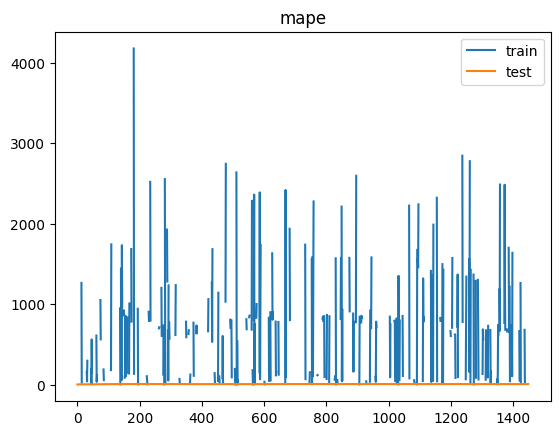

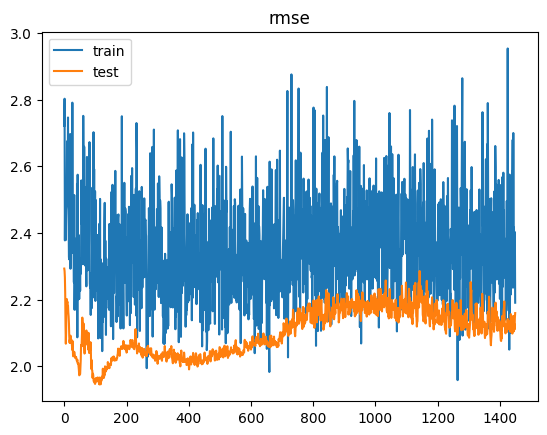

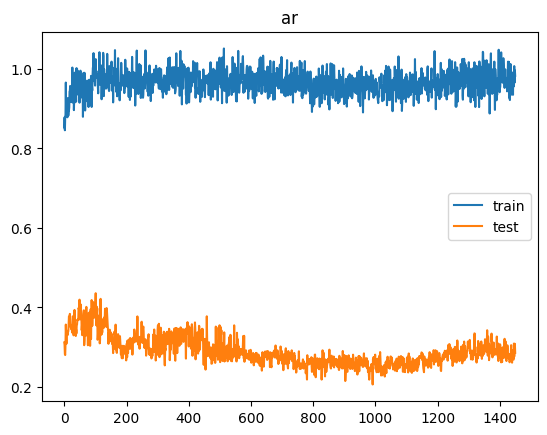

2/2 [==============================] - 0s 3ms/step


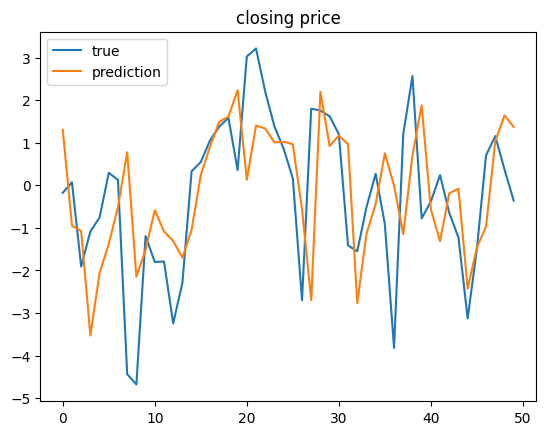

[MSE Baseline] train: 8.094777075391724  test: 4.1521541466081695
Delta time with epochs = 1450: 0:18:59.746871
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_5 (LSTM

Time for epoch 53 is 0.9880948066711426 sec Generator Loss: 1.0363664627075195,  Discriminator_loss: 1.2068800926208496
Time for epoch 54 is 0.8952937126159668 sec Generator Loss: 1.046105980873108,  Discriminator_loss: 1.2089738845825195
Time for epoch 55 is 0.8920125961303711 sec Generator Loss: 1.0058261156082153,  Discriminator_loss: 1.2272865772247314
Time for epoch 56 is 0.9124000072479248 sec Generator Loss: 1.0152490139007568,  Discriminator_loss: 1.2225934267044067
Time for epoch 57 is 0.88069748878479 sec Generator Loss: 1.0006545782089233,  Discriminator_loss: 1.227976679801941
Time for epoch 58 is 0.886432409286499 sec Generator Loss: 0.9912068247795105,  Discriminator_loss: 1.2168363332748413
Time for epoch 59 is 0.8659846782684326 sec Generator Loss: 1.0197354555130005,  Discriminator_loss: 1.2068685293197632
Time for epoch 60 is 0.9308319091796875 sec Generator Loss: 1.0030388832092285,  Discriminator_loss: 1.2349634170532227
Time for epoch 61 is 0.8533449172973633 sec G

Time for epoch 122 is 0.9718837738037109 sec Generator Loss: 0.887714684009552,  Discriminator_loss: 1.2954726219177246
Time for epoch 123 is 0.7869560718536377 sec Generator Loss: 0.9078657627105713,  Discriminator_loss: 1.2977770566940308
Time for epoch 124 is 0.7672421932220459 sec Generator Loss: 0.9210556149482727,  Discriminator_loss: 1.3008700609207153
Time for epoch 125 is 0.866995096206665 sec Generator Loss: 0.9061291813850403,  Discriminator_loss: 1.2958033084869385
Time for epoch 126 is 0.7895388603210449 sec Generator Loss: 0.9011490345001221,  Discriminator_loss: 1.2933710813522339
Time for epoch 127 is 0.8449316024780273 sec Generator Loss: 0.9093656539916992,  Discriminator_loss: 1.2998064756393433
Time for epoch 128 is 0.8607511520385742 sec Generator Loss: 0.912369430065155,  Discriminator_loss: 1.2975343465805054
Time for epoch 129 is 0.8645188808441162 sec Generator Loss: 0.9077079892158508,  Discriminator_loss: 1.2896431684494019
Time for epoch 130 is 0.88076710700

Time for epoch 190 is 0.8528048992156982 sec Generator Loss: 0.8907039165496826,  Discriminator_loss: 1.2997848987579346
Time for epoch 191 is 0.8452610969543457 sec Generator Loss: 0.9057899117469788,  Discriminator_loss: 1.29303777217865
Time for epoch 192 is 0.867229700088501 sec Generator Loss: 0.8853431940078735,  Discriminator_loss: 1.2975069284439087
Time for epoch 193 is 0.780806303024292 sec Generator Loss: 0.9179084897041321,  Discriminator_loss: 1.3045734167099
Time for epoch 194 is 0.7933948040008545 sec Generator Loss: 0.8993197083473206,  Discriminator_loss: 1.3021291494369507
Time for epoch 195 is 0.8513095378875732 sec Generator Loss: 0.879082977771759,  Discriminator_loss: 1.305516004562378
Time for epoch 196 is 0.7850136756896973 sec Generator Loss: 0.8894016742706299,  Discriminator_loss: 1.303131341934204
Time for epoch 197 is 0.7649469375610352 sec Generator Loss: 0.8895902037620544,  Discriminator_loss: 1.301015853881836
Time for epoch 198 is 0.7565305233001709 se

Time for epoch 259 is 0.7541863918304443 sec Generator Loss: 0.8936415314674377,  Discriminator_loss: 1.2974724769592285
Time for epoch 260 is 0.7678351402282715 sec Generator Loss: 0.8659857511520386,  Discriminator_loss: 1.3053579330444336
Time for epoch 261 is 0.7674787044525146 sec Generator Loss: 0.8740482926368713,  Discriminator_loss: 1.31171715259552
Time for epoch 262 is 0.7554998397827148 sec Generator Loss: 0.8985825777053833,  Discriminator_loss: 1.3012936115264893
Time for epoch 263 is 0.7588231563568115 sec Generator Loss: 0.8756908774375916,  Discriminator_loss: 1.3016340732574463
Time for epoch 264 is 0.7545170783996582 sec Generator Loss: 0.8996325135231018,  Discriminator_loss: 1.2956748008728027
Time for epoch 265 is 0.7590916156768799 sec Generator Loss: 0.8937861323356628,  Discriminator_loss: 1.300586462020874
Time for epoch 266 is 0.7751953601837158 sec Generator Loss: 0.9066178202629089,  Discriminator_loss: 1.2995692491531372
Time for epoch 267 is 0.81532573699

Time for epoch 327 is 0.7582716941833496 sec Generator Loss: 0.894787073135376,  Discriminator_loss: 1.289372444152832
Time for epoch 328 is 0.7704474925994873 sec Generator Loss: 0.8874211311340332,  Discriminator_loss: 1.2985056638717651
Time for epoch 329 is 0.7600452899932861 sec Generator Loss: 0.903838574886322,  Discriminator_loss: 1.2998404502868652
Time for epoch 330 is 0.7554116249084473 sec Generator Loss: 0.9019604921340942,  Discriminator_loss: 1.2929130792617798
Time for epoch 331 is 0.8161027431488037 sec Generator Loss: 0.8808513879776001,  Discriminator_loss: 1.301993489265442
Time for epoch 332 is 0.7567305564880371 sec Generator Loss: 0.907629132270813,  Discriminator_loss: 1.293803095817566
Time for epoch 333 is 0.7583012580871582 sec Generator Loss: 0.88596510887146,  Discriminator_loss: 1.292690396308899
Time for epoch 334 is 0.7615904808044434 sec Generator Loss: 0.8916565775871277,  Discriminator_loss: 1.3009188175201416
Time for epoch 335 is 0.7620792388916016 

Time for epoch 396 is 0.8146891593933105 sec Generator Loss: 0.901023268699646,  Discriminator_loss: 1.2906183004379272
Time for epoch 397 is 0.8106687068939209 sec Generator Loss: 0.8810762166976929,  Discriminator_loss: 1.3021584749221802
Time for epoch 398 is 0.779038667678833 sec Generator Loss: 0.8821069002151489,  Discriminator_loss: 1.299692988395691
Time for epoch 399 is 0.7814147472381592 sec Generator Loss: 0.900495707988739,  Discriminator_loss: 1.2979793548583984
Time for epoch 400 is 0.7854719161987305 sec Generator Loss: 0.8747795820236206,  Discriminator_loss: 1.300201416015625
Time for epoch 401 is 0.7769272327423096 sec Generator Loss: 0.902765691280365,  Discriminator_loss: 1.2859361171722412
Time for epoch 402 is 0.776714563369751 sec Generator Loss: 0.9106355309486389,  Discriminator_loss: 1.2889217138290405
Time for epoch 403 is 0.7802953720092773 sec Generator Loss: 0.9032953977584839,  Discriminator_loss: 1.3006505966186523
Time for epoch 404 is 0.782725811004638

Time for epoch 464 is 0.7725870609283447 sec Generator Loss: 0.918554961681366,  Discriminator_loss: 1.2913225889205933
Time for epoch 465 is 0.7752366065979004 sec Generator Loss: 0.9191036820411682,  Discriminator_loss: 1.2792744636535645
Time for epoch 466 is 0.7714829444885254 sec Generator Loss: 0.9104934930801392,  Discriminator_loss: 1.2888623476028442
Time for epoch 467 is 0.8116588592529297 sec Generator Loss: 0.893782377243042,  Discriminator_loss: 1.297091007232666
Time for epoch 468 is 0.7982714176177979 sec Generator Loss: 0.9105233550071716,  Discriminator_loss: 1.2856550216674805
Time for epoch 469 is 0.8443701267242432 sec Generator Loss: 0.9265385866165161,  Discriminator_loss: 1.2880319356918335
Time for epoch 470 is 0.7806496620178223 sec Generator Loss: 0.9190893173217773,  Discriminator_loss: 1.2864067554473877
Time for epoch 471 is 0.8280422687530518 sec Generator Loss: 0.8941745162010193,  Discriminator_loss: 1.294691801071167
Time for epoch 472 is 0.791942358016

Time for epoch 532 is 0.7760565280914307 sec Generator Loss: 0.9003362059593201,  Discriminator_loss: 1.2894396781921387
Time for epoch 533 is 0.7758815288543701 sec Generator Loss: 0.9042141437530518,  Discriminator_loss: 1.2806051969528198
Time for epoch 534 is 0.7795932292938232 sec Generator Loss: 0.9459013342857361,  Discriminator_loss: 1.2805633544921875
Time for epoch 535 is 0.772061824798584 sec Generator Loss: 0.9363166689872742,  Discriminator_loss: 1.2845712900161743
Time for epoch 536 is 0.8047072887420654 sec Generator Loss: 0.9070504307746887,  Discriminator_loss: 1.2867577075958252
Time for epoch 537 is 0.7768244743347168 sec Generator Loss: 0.9154260158538818,  Discriminator_loss: 1.2751048803329468
Time for epoch 538 is 0.7924332618713379 sec Generator Loss: 0.9071415662765503,  Discriminator_loss: 1.2919514179229736
Time for epoch 539 is 0.775017499923706 sec Generator Loss: 0.901721715927124,  Discriminator_loss: 1.2792173624038696
Time for epoch 540 is 0.77907276153

Time for epoch 600 is 0.7849328517913818 sec Generator Loss: 0.9258254170417786,  Discriminator_loss: 1.2675868272781372
Time for epoch 601 is 0.7769474983215332 sec Generator Loss: 0.9215993881225586,  Discriminator_loss: 1.2762783765792847
Time for epoch 602 is 0.8069734573364258 sec Generator Loss: 0.9004899859428406,  Discriminator_loss: 1.2852498292922974
Time for epoch 603 is 0.7778747081756592 sec Generator Loss: 0.9026119112968445,  Discriminator_loss: 1.2784736156463623
Time for epoch 604 is 0.7815406322479248 sec Generator Loss: 0.9065602421760559,  Discriminator_loss: 1.2711936235427856
Time for epoch 605 is 0.7848052978515625 sec Generator Loss: 0.9110583066940308,  Discriminator_loss: 1.273544192314148
Time for epoch 606 is 0.7765085697174072 sec Generator Loss: 0.9238352179527283,  Discriminator_loss: 1.2784665822982788
Time for epoch 607 is 0.7748417854309082 sec Generator Loss: 0.9118387699127197,  Discriminator_loss: 1.2726271152496338
Time for epoch 608 is 0.779412269

Time for epoch 669 is 0.9917080402374268 sec Generator Loss: 0.9291413426399231,  Discriminator_loss: 1.2680655717849731
Time for epoch 670 is 0.9738969802856445 sec Generator Loss: 0.8951989412307739,  Discriminator_loss: 1.2889840602874756
Time for epoch 671 is 0.9676427841186523 sec Generator Loss: 0.9154481887817383,  Discriminator_loss: 1.2844270467758179
Time for epoch 672 is 0.9503982067108154 sec Generator Loss: 0.9151178598403931,  Discriminator_loss: 1.2739232778549194
Time for epoch 673 is 0.948258638381958 sec Generator Loss: 0.9225410223007202,  Discriminator_loss: 1.27651846408844
Time for epoch 674 is 0.9424037933349609 sec Generator Loss: 0.9226744174957275,  Discriminator_loss: 1.2785815000534058
Time for epoch 675 is 0.9439916610717773 sec Generator Loss: 0.9184114336967468,  Discriminator_loss: 1.2792580127716064
Time for epoch 676 is 0.9865503311157227 sec Generator Loss: 0.9276142716407776,  Discriminator_loss: 1.2749090194702148
Time for epoch 677 is 0.97887897491

Time for epoch 738 is 0.7887041568756104 sec Generator Loss: 0.9222894310951233,  Discriminator_loss: 1.2681221961975098
Time for epoch 739 is 0.7939555644989014 sec Generator Loss: 0.9112226366996765,  Discriminator_loss: 1.2789868116378784
Time for epoch 740 is 0.7927749156951904 sec Generator Loss: 0.9131000638008118,  Discriminator_loss: 1.2803289890289307
Time for epoch 741 is 0.8364353179931641 sec Generator Loss: 0.913244366645813,  Discriminator_loss: 1.2750616073608398
Time for epoch 742 is 0.7966368198394775 sec Generator Loss: 0.9257320761680603,  Discriminator_loss: 1.2760142087936401
Time for epoch 743 is 0.787839412689209 sec Generator Loss: 0.9256771802902222,  Discriminator_loss: 1.2818466424942017
Time for epoch 744 is 0.7938830852508545 sec Generator Loss: 0.9209160804748535,  Discriminator_loss: 1.2732326984405518
Time for epoch 745 is 0.8014013767242432 sec Generator Loss: 0.9406501054763794,  Discriminator_loss: 1.2725635766983032
Time for epoch 746 is 0.7990124225

Time for epoch 807 is 0.966357946395874 sec Generator Loss: 0.9344037175178528,  Discriminator_loss: 1.279077410697937
Time for epoch 808 is 0.8876314163208008 sec Generator Loss: 0.9278385043144226,  Discriminator_loss: 1.2719511985778809
Time for epoch 809 is 0.8512363433837891 sec Generator Loss: 0.9188971519470215,  Discriminator_loss: 1.2693380117416382
Time for epoch 810 is 0.8453872203826904 sec Generator Loss: 0.9273917078971863,  Discriminator_loss: 1.275404930114746
Time for epoch 811 is 0.8552160263061523 sec Generator Loss: 0.9242852330207825,  Discriminator_loss: 1.2777541875839233
Time for epoch 812 is 0.9039435386657715 sec Generator Loss: 0.916983962059021,  Discriminator_loss: 1.2751399278640747
Time for epoch 813 is 0.9152495861053467 sec Generator Loss: 0.9227688312530518,  Discriminator_loss: 1.2753435373306274
Time for epoch 814 is 0.9280164241790771 sec Generator Loss: 0.9049376249313354,  Discriminator_loss: 1.278910756111145
Time for epoch 815 is 0.9347388744354

Time for epoch 875 is 1.0365917682647705 sec Generator Loss: 0.9155128002166748,  Discriminator_loss: 1.2746388912200928
Time for epoch 876 is 0.9917349815368652 sec Generator Loss: 0.916502058506012,  Discriminator_loss: 1.2740713357925415
Time for epoch 877 is 0.9878604412078857 sec Generator Loss: 0.9344225525856018,  Discriminator_loss: 1.2540507316589355
Time for epoch 878 is 0.9203121662139893 sec Generator Loss: 0.9092164039611816,  Discriminator_loss: 1.271496295928955
Time for epoch 879 is 0.9015524387359619 sec Generator Loss: 0.9321362972259521,  Discriminator_loss: 1.269688367843628
Time for epoch 880 is 0.9238138198852539 sec Generator Loss: 0.9397789239883423,  Discriminator_loss: 1.268734097480774
Time for epoch 881 is 0.9282214641571045 sec Generator Loss: 0.927241861820221,  Discriminator_loss: 1.2740249633789062
Time for epoch 882 is 0.8936271667480469 sec Generator Loss: 0.9157810211181641,  Discriminator_loss: 1.264194369316101
Time for epoch 883 is 0.89815711975097

Time for epoch 944 is 0.8587286472320557 sec Generator Loss: 0.9088683724403381,  Discriminator_loss: 1.2797536849975586
Time for epoch 945 is 0.8292441368103027 sec Generator Loss: 0.9253959655761719,  Discriminator_loss: 1.2727302312850952
Time for epoch 946 is 0.8596897125244141 sec Generator Loss: 0.9318811893463135,  Discriminator_loss: 1.2716310024261475
Time for epoch 947 is 0.8619563579559326 sec Generator Loss: 0.9150500297546387,  Discriminator_loss: 1.2844592332839966
Time for epoch 948 is 0.864919900894165 sec Generator Loss: 0.9330630302429199,  Discriminator_loss: 1.2796878814697266
Time for epoch 949 is 0.8677322864532471 sec Generator Loss: 0.9038501381874084,  Discriminator_loss: 1.2951823472976685
Time for epoch 950 is 0.9412374496459961 sec Generator Loss: 0.9117958545684814,  Discriminator_loss: 1.2776941061019897
Time for epoch 951 is 0.9370136260986328 sec Generator Loss: 0.9090011715888977,  Discriminator_loss: 1.2666172981262207
Time for epoch 952 is 0.972392797

Time for epoch 1012 is 1.0743069648742676 sec Generator Loss: 0.9283468723297119,  Discriminator_loss: 1.271665096282959
Time for epoch 1013 is 1.1305742263793945 sec Generator Loss: 0.9179198741912842,  Discriminator_loss: 1.2780159711837769
Time for epoch 1014 is 1.1501641273498535 sec Generator Loss: 0.9226536750793457,  Discriminator_loss: 1.2782706022262573
Time for epoch 1015 is 1.0888078212738037 sec Generator Loss: 0.943351149559021,  Discriminator_loss: 1.2634265422821045
Time for epoch 1016 is 1.1293740272521973 sec Generator Loss: 0.9442083835601807,  Discriminator_loss: 1.2591780424118042
Time for epoch 1017 is 1.1161024570465088 sec Generator Loss: 0.9352644681930542,  Discriminator_loss: 1.2702654600143433
Time for epoch 1018 is 1.0139343738555908 sec Generator Loss: 0.9395095705986023,  Discriminator_loss: 1.2656522989273071
Time for epoch 1019 is 1.057070255279541 sec Generator Loss: 0.9048941135406494,  Discriminator_loss: 1.2811144590377808
Time for epoch 1020 is 0.99

Time for epoch 1080 is 1.0630178451538086 sec Generator Loss: 0.9188413023948669,  Discriminator_loss: 1.274125337600708
Time for epoch 1081 is 1.0479731559753418 sec Generator Loss: 0.9210362434387207,  Discriminator_loss: 1.2689764499664307
Time for epoch 1082 is 0.9632256031036377 sec Generator Loss: 0.9138967394828796,  Discriminator_loss: 1.2699964046478271
Time for epoch 1083 is 0.9943497180938721 sec Generator Loss: 0.9338862895965576,  Discriminator_loss: 1.2729685306549072
Time for epoch 1084 is 1.0248103141784668 sec Generator Loss: 0.9307815432548523,  Discriminator_loss: 1.265153169631958
Time for epoch 1085 is 0.967402458190918 sec Generator Loss: 0.9228934645652771,  Discriminator_loss: 1.277646541595459
Time for epoch 1086 is 1.0244314670562744 sec Generator Loss: 0.9201148152351379,  Discriminator_loss: 1.2712808847427368
Time for epoch 1087 is 0.9715714454650879 sec Generator Loss: 0.9485786557197571,  Discriminator_loss: 1.2634501457214355
Time for epoch 1088 is 1.047

Time for epoch 1148 is 0.8643133640289307 sec Generator Loss: 0.9273810982704163,  Discriminator_loss: 1.2872421741485596
Time for epoch 1149 is 0.8743200302124023 sec Generator Loss: 0.9290785789489746,  Discriminator_loss: 1.2797716856002808
Time for epoch 1150 is 0.8493127822875977 sec Generator Loss: 0.9255386590957642,  Discriminator_loss: 1.2817375659942627
Time for epoch 1151 is 0.8745448589324951 sec Generator Loss: 0.9366670846939087,  Discriminator_loss: 1.2726926803588867
Time for epoch 1152 is 0.8644096851348877 sec Generator Loss: 0.9258962869644165,  Discriminator_loss: 1.27306067943573
Time for epoch 1153 is 0.872992753982544 sec Generator Loss: 0.9220098853111267,  Discriminator_loss: 1.270514965057373
Time for epoch 1154 is 0.8764307498931885 sec Generator Loss: 0.9104170799255371,  Discriminator_loss: 1.2694545984268188
Time for epoch 1155 is 0.8705146312713623 sec Generator Loss: 0.9195227026939392,  Discriminator_loss: 1.2703737020492554
Time for epoch 1156 is 0.835

Time for epoch 1216 is 0.8653075695037842 sec Generator Loss: 0.9223445057868958,  Discriminator_loss: 1.2755558490753174
Time for epoch 1217 is 0.9104888439178467 sec Generator Loss: 0.9216692447662354,  Discriminator_loss: 1.2745670080184937
Time for epoch 1218 is 0.8558862209320068 sec Generator Loss: 0.9230344295501709,  Discriminator_loss: 1.2787253856658936
Time for epoch 1219 is 0.8677382469177246 sec Generator Loss: 0.9207264184951782,  Discriminator_loss: 1.2752708196640015
Time for epoch 1220 is 0.8393635749816895 sec Generator Loss: 0.9268046617507935,  Discriminator_loss: 1.2835780382156372
Time for epoch 1221 is 0.8442471027374268 sec Generator Loss: 0.942468523979187,  Discriminator_loss: 1.2636114358901978
Time for epoch 1222 is 0.8739545345306396 sec Generator Loss: 0.9261860847473145,  Discriminator_loss: 1.276292085647583
Time for epoch 1223 is 0.8994550704956055 sec Generator Loss: 0.9339426755905151,  Discriminator_loss: 1.2808609008789062
Time for epoch 1224 is 0.8

Time for epoch 1284 is 0.8947844505310059 sec Generator Loss: 0.9175752997398376,  Discriminator_loss: 1.2857836484909058
Time for epoch 1285 is 0.9883971214294434 sec Generator Loss: 0.9145525097846985,  Discriminator_loss: 1.2847477197647095
Time for epoch 1286 is 0.9341702461242676 sec Generator Loss: 0.9332546591758728,  Discriminator_loss: 1.277373194694519
Time for epoch 1287 is 0.9327535629272461 sec Generator Loss: 0.9286356568336487,  Discriminator_loss: 1.2869534492492676
Time for epoch 1288 is 1.0260581970214844 sec Generator Loss: 0.9388474822044373,  Discriminator_loss: 1.2756925821304321
Time for epoch 1289 is 0.9206743240356445 sec Generator Loss: 0.9251067638397217,  Discriminator_loss: 1.2717465162277222
Time for epoch 1290 is 1.0061283111572266 sec Generator Loss: 0.9152231812477112,  Discriminator_loss: 1.2843133211135864
Time for epoch 1291 is 1.0618913173675537 sec Generator Loss: 0.9314497113227844,  Discriminator_loss: 1.2846448421478271
Time for epoch 1292 is 1.

Time for epoch 1352 is 0.9336390495300293 sec Generator Loss: 0.909905195236206,  Discriminator_loss: 1.3004608154296875
Time for epoch 1353 is 0.882758617401123 sec Generator Loss: 0.9160292744636536,  Discriminator_loss: 1.2921844720840454
Time for epoch 1354 is 0.905205488204956 sec Generator Loss: 0.9141374826431274,  Discriminator_loss: 1.2807356119155884
Time for epoch 1355 is 0.8660082817077637 sec Generator Loss: 0.9239890575408936,  Discriminator_loss: 1.2870917320251465
Time for epoch 1356 is 0.8793842792510986 sec Generator Loss: 0.91548752784729,  Discriminator_loss: 1.289903998374939
Time for epoch 1357 is 0.8905024528503418 sec Generator Loss: 0.9072199463844299,  Discriminator_loss: 1.2765573263168335
Time for epoch 1358 is 1.161525011062622 sec Generator Loss: 0.9079241156578064,  Discriminator_loss: 1.293369174003601
Time for epoch 1359 is 1.1606850624084473 sec Generator Loss: 0.9294575452804565,  Discriminator_loss: 1.2753487825393677
Time for epoch 1360 is 1.2678008

Time for epoch 1420 is 1.1087567806243896 sec Generator Loss: 0.9268619418144226,  Discriminator_loss: 1.2873461246490479
Time for epoch 1421 is 1.2008965015411377 sec Generator Loss: 0.9066689610481262,  Discriminator_loss: 1.2916784286499023
Time for epoch 1422 is 1.0865538120269775 sec Generator Loss: 0.914577841758728,  Discriminator_loss: 1.295150876045227
Time for epoch 1423 is 0.9210712909698486 sec Generator Loss: 0.9185782074928284,  Discriminator_loss: 1.281202793121338
Time for epoch 1424 is 0.9268324375152588 sec Generator Loss: 0.9184334874153137,  Discriminator_loss: 1.2939093112945557
Time for epoch 1425 is 0.9204730987548828 sec Generator Loss: 0.9085090756416321,  Discriminator_loss: 1.287064552307129
Time for epoch 1426 is 0.9050323963165283 sec Generator Loss: 0.9208241701126099,  Discriminator_loss: 1.2990756034851074
Time for epoch 1427 is 0.8878059387207031 sec Generator Loss: 0.8966765999794006,  Discriminator_loss: 1.2877174615859985
Time for epoch 1428 is 0.881

Time for epoch 1488 is 0.9328773021697998 sec Generator Loss: 0.9029138088226318,  Discriminator_loss: 1.2857989072799683
Time for epoch 1489 is 0.9159061908721924 sec Generator Loss: 0.9098185896873474,  Discriminator_loss: 1.2884323596954346
Time for epoch 1490 is 0.948643684387207 sec Generator Loss: 0.9131035208702087,  Discriminator_loss: 1.29175865650177
Time for epoch 1491 is 0.9146690368652344 sec Generator Loss: 0.9251081943511963,  Discriminator_loss: 1.2852418422698975
Time for epoch 1492 is 0.9229288101196289 sec Generator Loss: 0.9065431356430054,  Discriminator_loss: 1.2979049682617188
Time for epoch 1493 is 0.9448451995849609 sec Generator Loss: 0.8997774124145508,  Discriminator_loss: 1.304689884185791
Time for epoch 1494 is 0.9315686225891113 sec Generator Loss: 0.9057172536849976,  Discriminator_loss: 1.2981218099594116
Time for epoch 1495 is 0.9335808753967285 sec Generator Loss: 0.8895614743232727,  Discriminator_loss: 1.2893407344818115
Time for epoch 1496 is 0.921

Time for epoch 1556 is 0.920081377029419 sec Generator Loss: 0.8962979316711426,  Discriminator_loss: 1.2954069375991821
Time for epoch 1557 is 0.9072589874267578 sec Generator Loss: 0.9357141256332397,  Discriminator_loss: 1.2891168594360352
Time for epoch 1558 is 0.9143784046173096 sec Generator Loss: 0.9246582984924316,  Discriminator_loss: 1.2833307981491089
Time for epoch 1559 is 1.017577886581421 sec Generator Loss: 0.9255365133285522,  Discriminator_loss: 1.288909912109375
Time for epoch 1560 is 0.9249000549316406 sec Generator Loss: 0.9092481732368469,  Discriminator_loss: 1.278893232345581
Time for epoch 1561 is 0.8902678489685059 sec Generator Loss: 0.912129282951355,  Discriminator_loss: 1.286801815032959
Time for epoch 1562 is 0.9021639823913574 sec Generator Loss: 0.9135165214538574,  Discriminator_loss: 1.2963125705718994
Time for epoch 1563 is 0.8914523124694824 sec Generator Loss: 0.8895105719566345,  Discriminator_loss: 1.3011679649353027
Time for epoch 1564 is 0.93728

Time for epoch 1624 is 0.9152824878692627 sec Generator Loss: 0.9137519598007202,  Discriminator_loss: 1.283258080482483
Time for epoch 1625 is 0.9147641658782959 sec Generator Loss: 0.908341109752655,  Discriminator_loss: 1.2894163131713867
Time for epoch 1626 is 0.8954877853393555 sec Generator Loss: 0.9182592630386353,  Discriminator_loss: 1.2894103527069092
Time for epoch 1627 is 0.9331471920013428 sec Generator Loss: 0.902359127998352,  Discriminator_loss: 1.2929141521453857
Time for epoch 1628 is 0.8991880416870117 sec Generator Loss: 0.9253938794136047,  Discriminator_loss: 1.2832444906234741
Time for epoch 1629 is 0.9170811176300049 sec Generator Loss: 0.9276149868965149,  Discriminator_loss: 1.2877600193023682
Time for epoch 1630 is 0.9011507034301758 sec Generator Loss: 0.9106071591377258,  Discriminator_loss: 1.2888671159744263
Time for epoch 1631 is 0.9075536727905273 sec Generator Loss: 0.8878224492073059,  Discriminator_loss: 1.2925862073898315
Time for epoch 1632 is 0.92

Time for epoch 1692 is 1.058175802230835 sec Generator Loss: 0.9241544604301453,  Discriminator_loss: 1.2882211208343506
Time for epoch 1693 is 1.0262892246246338 sec Generator Loss: 0.9227700233459473,  Discriminator_loss: 1.2807964086532593
Time for epoch 1694 is 0.9584290981292725 sec Generator Loss: 0.9324682950973511,  Discriminator_loss: 1.2928327322006226
Time for epoch 1695 is 1.024014949798584 sec Generator Loss: 0.8997235298156738,  Discriminator_loss: 1.295756459236145
Time for epoch 1696 is 0.9486522674560547 sec Generator Loss: 0.9032449722290039,  Discriminator_loss: 1.288774013519287
Time for epoch 1697 is 0.9301447868347168 sec Generator Loss: 0.9344505667686462,  Discriminator_loss: 1.2892273664474487
Time for epoch 1698 is 0.9421730041503906 sec Generator Loss: 0.9158613085746765,  Discriminator_loss: 1.297964334487915
Time for epoch 1699 is 0.9732611179351807 sec Generator Loss: 0.9068122506141663,  Discriminator_loss: 1.287063479423523
Time for epoch 1700 is 0.99168

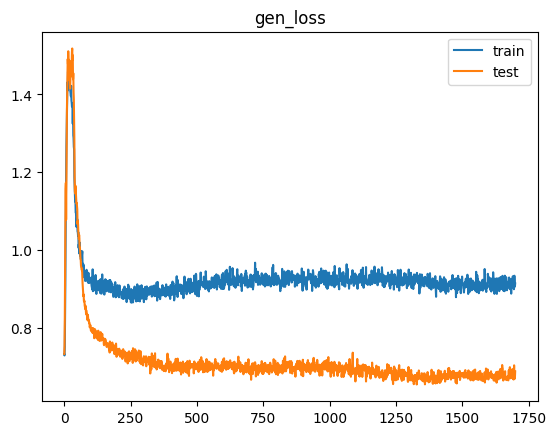

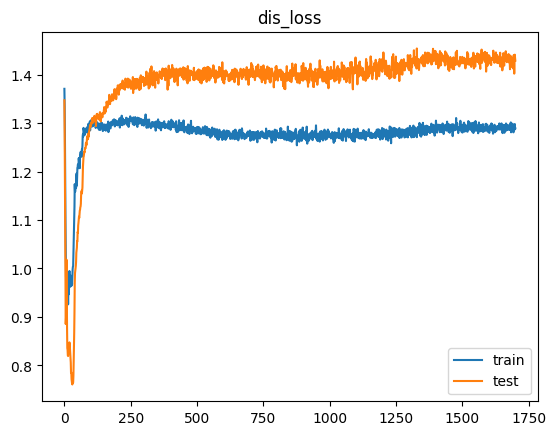

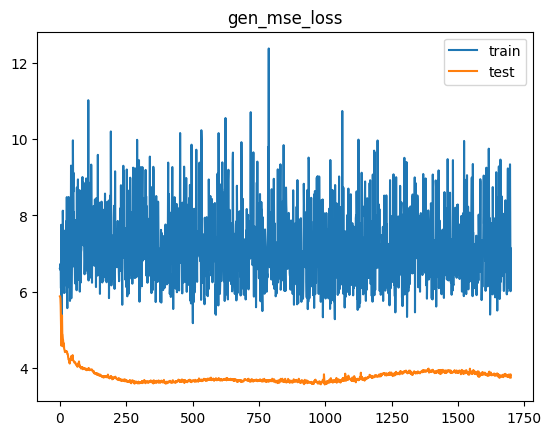

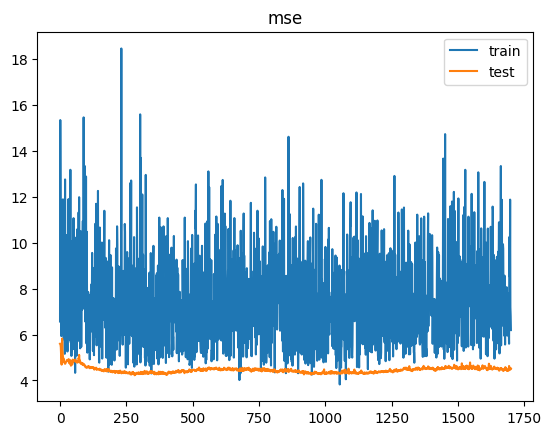

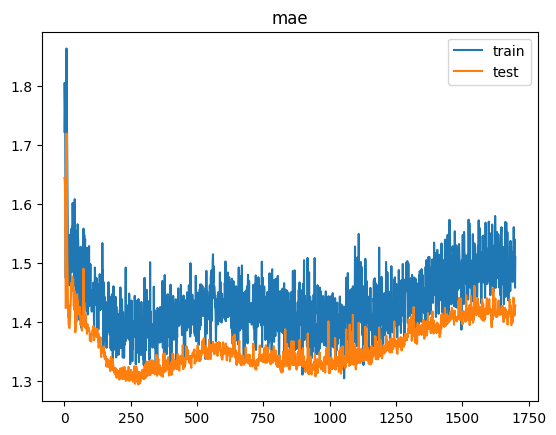

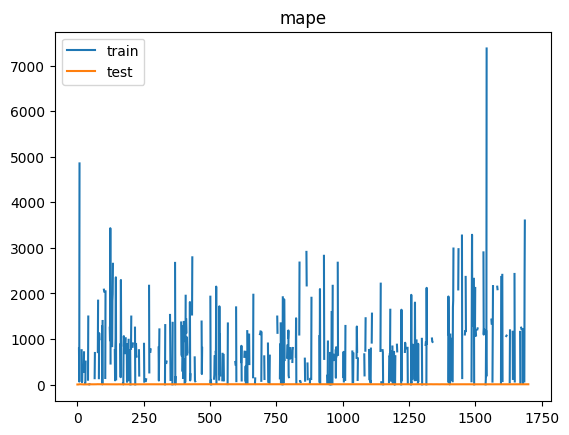

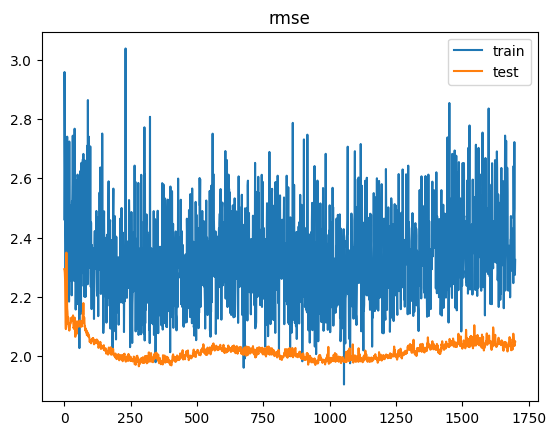

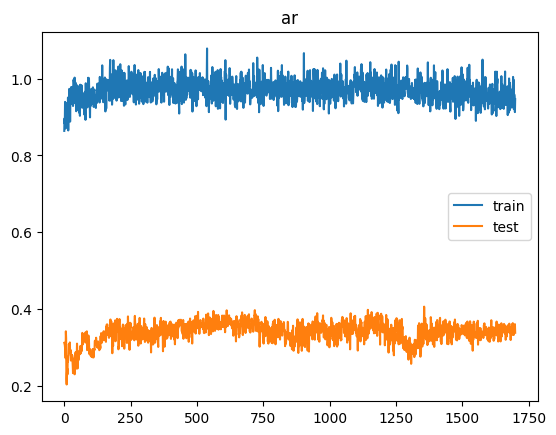

2/2 [==============================] - 0s 4ms/step


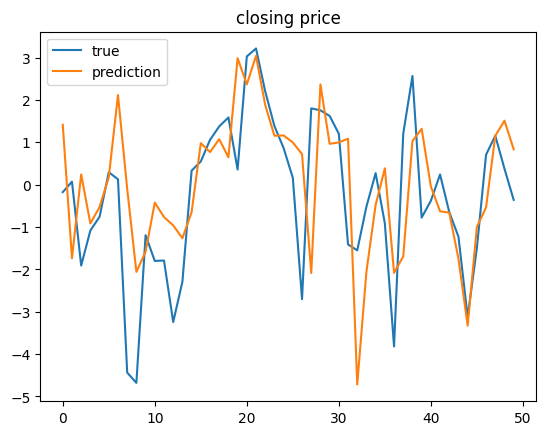

[MSE Baseline] train: 6.944196557010225  test: 4.1521541466081695
Delta time with epochs = 1700: 0:25:26.785637
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_7 (LSTM

Time for epoch 53 is 1.0573344230651855 sec Generator Loss: 0.9542432427406311,  Discriminator_loss: 1.2649778127670288
Time for epoch 54 is 1.0301213264465332 sec Generator Loss: 0.9355075359344482,  Discriminator_loss: 1.261352300643921
Time for epoch 55 is 1.0609431266784668 sec Generator Loss: 0.9478934407234192,  Discriminator_loss: 1.2475003004074097
Time for epoch 56 is 0.9637551307678223 sec Generator Loss: 0.9667677879333496,  Discriminator_loss: 1.2580046653747559
Time for epoch 57 is 1.054469108581543 sec Generator Loss: 0.9478138089179993,  Discriminator_loss: 1.2492600679397583
Time for epoch 58 is 0.9809319972991943 sec Generator Loss: 0.9458221197128296,  Discriminator_loss: 1.2455642223358154
Time for epoch 59 is 0.9234237670898438 sec Generator Loss: 0.9446805715560913,  Discriminator_loss: 1.2511600255966187
Time for epoch 60 is 0.9258146286010742 sec Generator Loss: 0.9393492937088013,  Discriminator_loss: 1.2618485689163208
Time for epoch 61 is 0.9470126628875732 se

Time for epoch 122 is 0.9260838031768799 sec Generator Loss: 0.9379869699478149,  Discriminator_loss: 1.2832698822021484
Time for epoch 123 is 0.9014060497283936 sec Generator Loss: 0.9287548065185547,  Discriminator_loss: 1.2812665700912476
Time for epoch 124 is 0.88747239112854 sec Generator Loss: 0.9078009724617004,  Discriminator_loss: 1.2787971496582031
Time for epoch 125 is 0.955268144607544 sec Generator Loss: 0.9258814454078674,  Discriminator_loss: 1.2850159406661987
Time for epoch 126 is 0.9115638732910156 sec Generator Loss: 0.9048699736595154,  Discriminator_loss: 1.291198492050171
Time for epoch 127 is 0.9108586311340332 sec Generator Loss: 0.8944392204284668,  Discriminator_loss: 1.288796305656433
Time for epoch 128 is 0.9152505397796631 sec Generator Loss: 0.9128602147102356,  Discriminator_loss: 1.2787768840789795
Time for epoch 129 is 0.9005942344665527 sec Generator Loss: 0.9511403441429138,  Discriminator_loss: 1.2740517854690552
Time for epoch 130 is 0.9293999671936

Time for epoch 190 is 0.9937846660614014 sec Generator Loss: 0.9056261777877808,  Discriminator_loss: 1.2870516777038574
Time for epoch 191 is 0.9542629718780518 sec Generator Loss: 0.8887853026390076,  Discriminator_loss: 1.2987653017044067
Time for epoch 192 is 0.905327558517456 sec Generator Loss: 0.9221882224082947,  Discriminator_loss: 1.28983473777771
Time for epoch 193 is 1.0904135704040527 sec Generator Loss: 0.9039860963821411,  Discriminator_loss: 1.2803428173065186
Time for epoch 194 is 1.4097609519958496 sec Generator Loss: 0.8944816589355469,  Discriminator_loss: 1.2957357168197632
Time for epoch 195 is 1.2327656745910645 sec Generator Loss: 0.8837689757347107,  Discriminator_loss: 1.2925972938537598
Time for epoch 196 is 1.0466878414154053 sec Generator Loss: 0.8856270909309387,  Discriminator_loss: 1.2974573373794556
Time for epoch 197 is 1.2498936653137207 sec Generator Loss: 0.8862558007240295,  Discriminator_loss: 1.2830077409744263
Time for epoch 198 is 1.05184507369

Time for epoch 259 is 1.1685867309570312 sec Generator Loss: 0.9032434821128845,  Discriminator_loss: 1.2889430522918701
Time for epoch 260 is 1.211651086807251 sec Generator Loss: 0.9328534603118896,  Discriminator_loss: 1.2844316959381104
Time for epoch 261 is 1.10032057762146 sec Generator Loss: 0.8895803093910217,  Discriminator_loss: 1.2904366254806519
Time for epoch 262 is 1.1242151260375977 sec Generator Loss: 0.8884480595588684,  Discriminator_loss: 1.300666332244873
Time for epoch 263 is 0.9607272148132324 sec Generator Loss: 0.8910954594612122,  Discriminator_loss: 1.2826769351959229
Time for epoch 264 is 0.9671368598937988 sec Generator Loss: 0.8854140043258667,  Discriminator_loss: 1.290276050567627
Time for epoch 265 is 0.9807882308959961 sec Generator Loss: 0.9074950814247131,  Discriminator_loss: 1.284448266029358
Time for epoch 266 is 0.9796643257141113 sec Generator Loss: 0.896018922328949,  Discriminator_loss: 1.298612356185913
Time for epoch 267 is 1.0261077880859375

Time for epoch 328 is 1.5192980766296387 sec Generator Loss: 0.894036591053009,  Discriminator_loss: 1.2928322553634644
Time for epoch 329 is 1.250643014907837 sec Generator Loss: 0.9092133045196533,  Discriminator_loss: 1.2803279161453247
Time for epoch 330 is 1.219714879989624 sec Generator Loss: 0.9055219888687134,  Discriminator_loss: 1.2834291458129883
Time for epoch 331 is 1.1518926620483398 sec Generator Loss: 0.8997678160667419,  Discriminator_loss: 1.2880511283874512
Time for epoch 332 is 1.2429533004760742 sec Generator Loss: 0.8914161324501038,  Discriminator_loss: 1.2903860807418823
Time for epoch 333 is 1.2288100719451904 sec Generator Loss: 0.9157336354255676,  Discriminator_loss: 1.2887870073318481
Time for epoch 334 is 1.131178617477417 sec Generator Loss: 0.9239956140518188,  Discriminator_loss: 1.2781689167022705
Time for epoch 335 is 1.1508796215057373 sec Generator Loss: 0.9263958930969238,  Discriminator_loss: 1.2856659889221191
Time for epoch 336 is 1.178231239318

Time for epoch 396 is 0.9712390899658203 sec Generator Loss: 0.9466195702552795,  Discriminator_loss: 1.2732880115509033
Time for epoch 397 is 0.9750990867614746 sec Generator Loss: 0.9373778104782104,  Discriminator_loss: 1.2748287916183472
Time for epoch 398 is 1.1351826190948486 sec Generator Loss: 0.8959546685218811,  Discriminator_loss: 1.2895385026931763
Time for epoch 399 is 1.1254277229309082 sec Generator Loss: 0.9228821396827698,  Discriminator_loss: 1.2779946327209473
Time for epoch 400 is 1.099778175354004 sec Generator Loss: 0.9164963364601135,  Discriminator_loss: 1.2881940603256226
Time for epoch 401 is 1.0541398525238037 sec Generator Loss: 0.8869621753692627,  Discriminator_loss: 1.2844864130020142
Time for epoch 402 is 1.1257386207580566 sec Generator Loss: 0.9238216876983643,  Discriminator_loss: 1.273696780204773
Time for epoch 403 is 1.0729117393493652 sec Generator Loss: 0.9135109186172485,  Discriminator_loss: 1.287366509437561
Time for epoch 404 is 1.07609772682

Time for epoch 465 is 1.0413458347320557 sec Generator Loss: 0.9335849285125732,  Discriminator_loss: 1.2763835191726685
Time for epoch 466 is 1.082822322845459 sec Generator Loss: 0.9504023194313049,  Discriminator_loss: 1.2745922803878784
Time for epoch 467 is 1.0684711933135986 sec Generator Loss: 0.9233590364456177,  Discriminator_loss: 1.2793792486190796
Time for epoch 468 is 1.1364109516143799 sec Generator Loss: 0.9183398485183716,  Discriminator_loss: 1.2789649963378906
Time for epoch 469 is 1.2595477104187012 sec Generator Loss: 0.9094305038452148,  Discriminator_loss: 1.2894948720932007
Time for epoch 470 is 1.1600751876831055 sec Generator Loss: 0.9061231017112732,  Discriminator_loss: 1.2881563901901245
Time for epoch 471 is 1.0761957168579102 sec Generator Loss: 0.922357439994812,  Discriminator_loss: 1.2700276374816895
Time for epoch 472 is 1.0709493160247803 sec Generator Loss: 0.9153447151184082,  Discriminator_loss: 1.2910767793655396
Time for epoch 473 is 1.0173878669

Time for epoch 534 is 1.172367811203003 sec Generator Loss: 0.9185221791267395,  Discriminator_loss: 1.2799320220947266
Time for epoch 535 is 1.26871919631958 sec Generator Loss: 0.9385233521461487,  Discriminator_loss: 1.2911479473114014
Time for epoch 536 is 1.1196098327636719 sec Generator Loss: 0.9005313515663147,  Discriminator_loss: 1.2801915407180786
Time for epoch 537 is 1.1188838481903076 sec Generator Loss: 0.9156355261802673,  Discriminator_loss: 1.2790298461914062
Time for epoch 538 is 1.0412700176239014 sec Generator Loss: 0.9324905276298523,  Discriminator_loss: 1.2772574424743652
Time for epoch 539 is 1.0043199062347412 sec Generator Loss: 0.9080726504325867,  Discriminator_loss: 1.2868359088897705
Time for epoch 540 is 1.052692174911499 sec Generator Loss: 0.9229391813278198,  Discriminator_loss: 1.2756417989730835
Time for epoch 541 is 0.9951975345611572 sec Generator Loss: 0.9324474930763245,  Discriminator_loss: 1.2794052362442017
Time for epoch 542 is 1.053352594375

Time for epoch 603 is 0.9863276481628418 sec Generator Loss: 0.9218739867210388,  Discriminator_loss: 1.2781426906585693
Time for epoch 604 is 1.194331169128418 sec Generator Loss: 0.9132847785949707,  Discriminator_loss: 1.2804979085922241
Time for epoch 605 is 1.0107545852661133 sec Generator Loss: 0.9242227077484131,  Discriminator_loss: 1.2937302589416504
Time for epoch 606 is 1.0905749797821045 sec Generator Loss: 0.9090169668197632,  Discriminator_loss: 1.2796554565429688
Time for epoch 607 is 1.189138412475586 sec Generator Loss: 0.9181466102600098,  Discriminator_loss: 1.2775065898895264
Time for epoch 608 is 1.0885767936706543 sec Generator Loss: 0.9133433699607849,  Discriminator_loss: 1.2729172706604004
Time for epoch 609 is 1.046684741973877 sec Generator Loss: 0.934349536895752,  Discriminator_loss: 1.2833269834518433
Time for epoch 610 is 1.068864107131958 sec Generator Loss: 0.9246986508369446,  Discriminator_loss: 1.2736873626708984
Time for epoch 611 is 1.0595703125 se

Time for epoch 672 is 1.0150275230407715 sec Generator Loss: 0.9090616703033447,  Discriminator_loss: 1.2819794416427612
Time for epoch 673 is 1.0359644889831543 sec Generator Loss: 0.9121388792991638,  Discriminator_loss: 1.2772963047027588
Time for epoch 674 is 1.0423152446746826 sec Generator Loss: 0.9067665934562683,  Discriminator_loss: 1.2871495485305786
Time for epoch 675 is 1.0651509761810303 sec Generator Loss: 0.9298849105834961,  Discriminator_loss: 1.2779204845428467
Time for epoch 676 is 1.1121046543121338 sec Generator Loss: 0.8975247740745544,  Discriminator_loss: 1.2905354499816895
Time for epoch 677 is 1.0712010860443115 sec Generator Loss: 0.9236025810241699,  Discriminator_loss: 1.2817902565002441
Time for epoch 678 is 1.130185604095459 sec Generator Loss: 0.91567462682724,  Discriminator_loss: 1.2899888753890991
Time for epoch 679 is 1.039189100265503 sec Generator Loss: 0.9215512275695801,  Discriminator_loss: 1.2739259004592896
Time for epoch 680 is 1.162070751190

Time for epoch 740 is 1.126936912536621 sec Generator Loss: 0.9296863675117493,  Discriminator_loss: 1.2726553678512573
Time for epoch 741 is 1.171238899230957 sec Generator Loss: 0.9202674627304077,  Discriminator_loss: 1.277921199798584
Time for epoch 742 is 1.2011542320251465 sec Generator Loss: 0.916138768196106,  Discriminator_loss: 1.2689961194992065
Time for epoch 743 is 1.1068572998046875 sec Generator Loss: 0.9470821022987366,  Discriminator_loss: 1.2745705842971802
Time for epoch 744 is 1.125380277633667 sec Generator Loss: 0.9336895942687988,  Discriminator_loss: 1.2758764028549194
Time for epoch 745 is 1.1337025165557861 sec Generator Loss: 0.9576961994171143,  Discriminator_loss: 1.2713454961776733
Time for epoch 746 is 1.1451284885406494 sec Generator Loss: 0.9422227144241333,  Discriminator_loss: 1.2763298749923706
Time for epoch 747 is 1.0732851028442383 sec Generator Loss: 0.9306901693344116,  Discriminator_loss: 1.2733601331710815
Time for epoch 748 is 1.0300626754760

Time for epoch 809 is 1.0843391418457031 sec Generator Loss: 0.930500328540802,  Discriminator_loss: 1.2730002403259277
Time for epoch 810 is 1.0590715408325195 sec Generator Loss: 0.9301736354827881,  Discriminator_loss: 1.2715129852294922
Time for epoch 811 is 1.1041767597198486 sec Generator Loss: 0.9355223774909973,  Discriminator_loss: 1.2643150091171265
Time for epoch 812 is 1.0488455295562744 sec Generator Loss: 0.9337841868400574,  Discriminator_loss: 1.273325800895691
Time for epoch 813 is 1.0776004791259766 sec Generator Loss: 0.9267930388450623,  Discriminator_loss: 1.2778505086898804
Time for epoch 814 is 1.0258252620697021 sec Generator Loss: 0.9392317533493042,  Discriminator_loss: 1.2751787900924683
Time for epoch 815 is 1.0431666374206543 sec Generator Loss: 0.9184502959251404,  Discriminator_loss: 1.2886641025543213
Time for epoch 816 is 1.0257062911987305 sec Generator Loss: 0.9482157230377197,  Discriminator_loss: 1.2580466270446777
Time for epoch 817 is 1.1161150932

Time for epoch 878 is 1.2097225189208984 sec Generator Loss: 0.9134863018989563,  Discriminator_loss: 1.278783917427063
Time for epoch 879 is 1.3147127628326416 sec Generator Loss: 0.9209728240966797,  Discriminator_loss: 1.2751753330230713
Time for epoch 880 is 1.4040043354034424 sec Generator Loss: 0.9434658885002136,  Discriminator_loss: 1.272334337234497
Time for epoch 881 is 1.271223783493042 sec Generator Loss: 0.9510076642036438,  Discriminator_loss: 1.2692984342575073
Time for epoch 882 is 1.2495157718658447 sec Generator Loss: 0.9060069918632507,  Discriminator_loss: 1.2909785509109497
Time for epoch 883 is 1.2081780433654785 sec Generator Loss: 0.9165087938308716,  Discriminator_loss: 1.2810577154159546
Time for epoch 884 is 1.1257736682891846 sec Generator Loss: 0.9296025037765503,  Discriminator_loss: 1.28184175491333
Time for epoch 885 is 1.1045653820037842 sec Generator Loss: 0.9177942276000977,  Discriminator_loss: 1.2739477157592773
Time for epoch 886 is 1.1050550937652

Time for epoch 947 is 1.1282563209533691 sec Generator Loss: 0.9385111927986145,  Discriminator_loss: 1.265891432762146
Time for epoch 948 is 1.098681926727295 sec Generator Loss: 0.9259850978851318,  Discriminator_loss: 1.2713218927383423
Time for epoch 949 is 1.0796220302581787 sec Generator Loss: 0.9359816312789917,  Discriminator_loss: 1.2680644989013672
Time for epoch 950 is 1.1470918655395508 sec Generator Loss: 0.9286010265350342,  Discriminator_loss: 1.277693271636963
Time for epoch 951 is 1.1216681003570557 sec Generator Loss: 0.92343670129776,  Discriminator_loss: 1.275125503540039
Time for epoch 952 is 1.1235225200653076 sec Generator Loss: 0.9260619878768921,  Discriminator_loss: 1.270242691040039
Time for epoch 953 is 1.1436192989349365 sec Generator Loss: 0.9291208982467651,  Discriminator_loss: 1.2807241678237915
Time for epoch 954 is 1.1160004138946533 sec Generator Loss: 0.9169818162918091,  Discriminator_loss: 1.2661921977996826
Time for epoch 955 is 1.113876581192016

Time for epoch 1015 is 1.089395523071289 sec Generator Loss: 0.9437023997306824,  Discriminator_loss: 1.263793706893921
Time for epoch 1016 is 1.0680444240570068 sec Generator Loss: 0.9298012852668762,  Discriminator_loss: 1.266592025756836
Time for epoch 1017 is 1.0390987396240234 sec Generator Loss: 0.9302644729614258,  Discriminator_loss: 1.2643975019454956
Time for epoch 1018 is 1.0781805515289307 sec Generator Loss: 0.9161607027053833,  Discriminator_loss: 1.2893190383911133
Time for epoch 1019 is 1.1467883586883545 sec Generator Loss: 0.9301869869232178,  Discriminator_loss: 1.2667219638824463
Time for epoch 1020 is 1.20627760887146 sec Generator Loss: 0.9382568001747131,  Discriminator_loss: 1.280566692352295
Time for epoch 1021 is 1.176037311553955 sec Generator Loss: 0.949916660785675,  Discriminator_loss: 1.2669916152954102
Time for epoch 1022 is 1.1858024597167969 sec Generator Loss: 0.9411956667900085,  Discriminator_loss: 1.2623378038406372
Time for epoch 1023 is 1.1543316

Time for epoch 1083 is 1.188936471939087 sec Generator Loss: 0.9471896886825562,  Discriminator_loss: 1.2682156562805176
Time for epoch 1084 is 1.1249511241912842 sec Generator Loss: 0.9259932041168213,  Discriminator_loss: 1.2689552307128906
Time for epoch 1085 is 1.1197490692138672 sec Generator Loss: 0.9324078559875488,  Discriminator_loss: 1.2638994455337524
Time for epoch 1086 is 1.132230281829834 sec Generator Loss: 0.9696103930473328,  Discriminator_loss: 1.2578834295272827
Time for epoch 1087 is 1.1096019744873047 sec Generator Loss: 0.9242437481880188,  Discriminator_loss: 1.281740665435791
Time for epoch 1088 is 1.101344347000122 sec Generator Loss: 0.9342139363288879,  Discriminator_loss: 1.2688676118850708
Time for epoch 1089 is 1.1221387386322021 sec Generator Loss: 0.9350100755691528,  Discriminator_loss: 1.2498157024383545
Time for epoch 1090 is 1.1009190082550049 sec Generator Loss: 0.9377731680870056,  Discriminator_loss: 1.273293137550354
Time for epoch 1091 is 1.0948

Time for epoch 1151 is 1.1676063537597656 sec Generator Loss: 0.9611380696296692,  Discriminator_loss: 1.2615236043930054
Time for epoch 1152 is 1.1271553039550781 sec Generator Loss: 0.9368228912353516,  Discriminator_loss: 1.2656149864196777
Time for epoch 1153 is 1.2356610298156738 sec Generator Loss: 0.9364189505577087,  Discriminator_loss: 1.2664577960968018
Time for epoch 1154 is 1.23252534866333 sec Generator Loss: 0.9416314363479614,  Discriminator_loss: 1.2752490043640137
Time for epoch 1155 is 1.312415599822998 sec Generator Loss: 0.9116069674491882,  Discriminator_loss: 1.2759395837783813
Time for epoch 1156 is 1.1919598579406738 sec Generator Loss: 0.9261916875839233,  Discriminator_loss: 1.262407660484314
Time for epoch 1157 is 1.2756664752960205 sec Generator Loss: 0.9360307455062866,  Discriminator_loss: 1.2708851099014282
Time for epoch 1158 is 1.2024242877960205 sec Generator Loss: 0.9591777920722961,  Discriminator_loss: 1.2717393636703491
Time for epoch 1159 is 1.267

Time for epoch 1219 is 1.185359239578247 sec Generator Loss: 0.9608253240585327,  Discriminator_loss: 1.2594960927963257
Time for epoch 1220 is 1.1821107864379883 sec Generator Loss: 0.9432802200317383,  Discriminator_loss: 1.2813146114349365
Time for epoch 1221 is 1.200103759765625 sec Generator Loss: 0.9400423169136047,  Discriminator_loss: 1.2731987237930298
Time for epoch 1222 is 1.194422721862793 sec Generator Loss: 0.9299659729003906,  Discriminator_loss: 1.2613036632537842
Time for epoch 1223 is 1.2148585319519043 sec Generator Loss: 0.9358057975769043,  Discriminator_loss: 1.2680943012237549
Time for epoch 1224 is 1.1440377235412598 sec Generator Loss: 0.9382070302963257,  Discriminator_loss: 1.2663828134536743
Time for epoch 1225 is 1.1501851081848145 sec Generator Loss: 0.9362024664878845,  Discriminator_loss: 1.2645105123519897
Time for epoch 1226 is 1.2110037803649902 sec Generator Loss: 0.9375713467597961,  Discriminator_loss: 1.2721935510635376
Time for epoch 1227 is 1.16

Time for epoch 1287 is 1.4088101387023926 sec Generator Loss: 0.9221910238265991,  Discriminator_loss: 1.2714563608169556
Time for epoch 1288 is 1.4974756240844727 sec Generator Loss: 0.9519137740135193,  Discriminator_loss: 1.2722615003585815
Time for epoch 1289 is 1.2347829341888428 sec Generator Loss: 0.9232279658317566,  Discriminator_loss: 1.2784862518310547
Time for epoch 1290 is 1.341672658920288 sec Generator Loss: 0.9480292797088623,  Discriminator_loss: 1.2683360576629639
Time for epoch 1291 is 1.2570772171020508 sec Generator Loss: 0.9495317935943604,  Discriminator_loss: 1.269919514656067
Time for epoch 1292 is 1.2922019958496094 sec Generator Loss: 0.9766700863838196,  Discriminator_loss: 1.2687163352966309
Time for epoch 1293 is 1.318540334701538 sec Generator Loss: 0.9310683608055115,  Discriminator_loss: 1.2683043479919434
Time for epoch 1294 is 1.5004322528839111 sec Generator Loss: 0.9572235345840454,  Discriminator_loss: 1.2644835710525513
Time for epoch 1295 is 1.55

Time for epoch 1355 is 1.190380334854126 sec Generator Loss: 0.933737576007843,  Discriminator_loss: 1.277395486831665
Time for epoch 1356 is 1.1798136234283447 sec Generator Loss: 0.9559755921363831,  Discriminator_loss: 1.2761553525924683
Time for epoch 1357 is 1.1078095436096191 sec Generator Loss: 0.9224335551261902,  Discriminator_loss: 1.2726349830627441
Time for epoch 1358 is 1.0999350547790527 sec Generator Loss: 0.9304167628288269,  Discriminator_loss: 1.2810362577438354
Time for epoch 1359 is 1.0663869380950928 sec Generator Loss: 0.9070560932159424,  Discriminator_loss: 1.276494026184082
Time for epoch 1360 is 1.118971824645996 sec Generator Loss: 0.9438774585723877,  Discriminator_loss: 1.2770980596542358
Time for epoch 1361 is 1.169586181640625 sec Generator Loss: 0.9151099324226379,  Discriminator_loss: 1.280860424041748
Time for epoch 1362 is 1.0817527770996094 sec Generator Loss: 0.9244362711906433,  Discriminator_loss: 1.279638409614563
Time for epoch 1363 is 1.0884606

Time for epoch 1423 is 1.177384376525879 sec Generator Loss: 0.9094571471214294,  Discriminator_loss: 1.293060302734375
Time for epoch 1424 is 1.1194865703582764 sec Generator Loss: 0.924127459526062,  Discriminator_loss: 1.2814093828201294
Time for epoch 1425 is 1.2705154418945312 sec Generator Loss: 0.9082805514335632,  Discriminator_loss: 1.2861790657043457
Time for epoch 1426 is 1.1251981258392334 sec Generator Loss: 0.9356452822685242,  Discriminator_loss: 1.2765591144561768
Time for epoch 1427 is 1.0919959545135498 sec Generator Loss: 0.9112250804901123,  Discriminator_loss: 1.2882248163223267
Time for epoch 1428 is 1.1071009635925293 sec Generator Loss: 0.9227972030639648,  Discriminator_loss: 1.285414218902588
Time for epoch 1429 is 1.127471685409546 sec Generator Loss: 0.9100010991096497,  Discriminator_loss: 1.2830792665481567
Time for epoch 1430 is 1.076246738433838 sec Generator Loss: 0.9115099906921387,  Discriminator_loss: 1.2813868522644043
Time for epoch 1431 is 1.07352

Time for epoch 1491 is 1.3548338413238525 sec Generator Loss: 0.9005410075187683,  Discriminator_loss: 1.2907437086105347
Time for epoch 1492 is 1.6179239749908447 sec Generator Loss: 0.9329626560211182,  Discriminator_loss: 1.2885862588882446
Time for epoch 1493 is 1.298844337463379 sec Generator Loss: 0.9028363823890686,  Discriminator_loss: 1.2911593914031982
Time for epoch 1494 is 1.2998063564300537 sec Generator Loss: 0.9074823260307312,  Discriminator_loss: 1.2790391445159912
Time for epoch 1495 is 1.343230962753296 sec Generator Loss: 0.9198147654533386,  Discriminator_loss: 1.2895475625991821
Time for epoch 1496 is 1.2848773002624512 sec Generator Loss: 0.8995462656021118,  Discriminator_loss: 1.2910220623016357
Time for epoch 1497 is 1.2920119762420654 sec Generator Loss: 0.9072347283363342,  Discriminator_loss: 1.293991208076477
Time for epoch 1498 is 1.2077703475952148 sec Generator Loss: 0.9092832207679749,  Discriminator_loss: 1.291506052017212
Time for epoch 1499 is 1.213

Time for epoch 1559 is 1.1527643203735352 sec Generator Loss: 0.9024031758308411,  Discriminator_loss: 1.3099993467330933
Time for epoch 1560 is 1.135979175567627 sec Generator Loss: 0.9109194874763489,  Discriminator_loss: 1.2838833332061768
Time for epoch 1561 is 1.1966478824615479 sec Generator Loss: 0.9384810924530029,  Discriminator_loss: 1.282330870628357
Time for epoch 1562 is 1.189589500427246 sec Generator Loss: 0.907233476638794,  Discriminator_loss: 1.28892982006073
Time for epoch 1563 is 1.182443380355835 sec Generator Loss: 0.9080278277397156,  Discriminator_loss: 1.2849150896072388
Time for epoch 1564 is 1.1842217445373535 sec Generator Loss: 0.9238563179969788,  Discriminator_loss: 1.2788355350494385
Time for epoch 1565 is 1.1798834800720215 sec Generator Loss: 0.9260953664779663,  Discriminator_loss: 1.2902369499206543
Time for epoch 1566 is 1.211756944656372 sec Generator Loss: 0.9075127840042114,  Discriminator_loss: 1.2840372323989868
Time for epoch 1567 is 1.1537013

Time for epoch 1627 is 1.603208065032959 sec Generator Loss: 0.9035367965698242,  Discriminator_loss: 1.2930700778961182
Time for epoch 1628 is 1.5431110858917236 sec Generator Loss: 0.9194977879524231,  Discriminator_loss: 1.2879475355148315
Time for epoch 1629 is 1.4394571781158447 sec Generator Loss: 0.9419280290603638,  Discriminator_loss: 1.276183843612671
Time for epoch 1630 is 1.6483826637268066 sec Generator Loss: 0.9348277449607849,  Discriminator_loss: 1.2917639017105103
Time for epoch 1631 is 1.51426100730896 sec Generator Loss: 0.9005695581436157,  Discriminator_loss: 1.2881174087524414
Time for epoch 1632 is 1.4727966785430908 sec Generator Loss: 0.9077085852622986,  Discriminator_loss: 1.2836015224456787
Time for epoch 1633 is 1.5209977626800537 sec Generator Loss: 0.8946563601493835,  Discriminator_loss: 1.296873688697815
Time for epoch 1634 is 1.539515495300293 sec Generator Loss: 0.8940972089767456,  Discriminator_loss: 1.291688084602356
Time for epoch 1635 is 1.459164

Time for epoch 1695 is 1.5738499164581299 sec Generator Loss: 0.9143415689468384,  Discriminator_loss: 1.2949930429458618
Time for epoch 1696 is 1.4231641292572021 sec Generator Loss: 0.9118635654449463,  Discriminator_loss: 1.285658359527588
Time for epoch 1697 is 1.4293296337127686 sec Generator Loss: 0.9020854234695435,  Discriminator_loss: 1.28572416305542
Time for epoch 1698 is 1.6508402824401855 sec Generator Loss: 0.9146939516067505,  Discriminator_loss: 1.288867712020874
Time for epoch 1699 is 1.7710931301116943 sec Generator Loss: 0.9045614004135132,  Discriminator_loss: 1.2904833555221558
Time for epoch 1700 is 1.5930728912353516 sec Generator Loss: 0.9150248765945435,  Discriminator_loss: 1.2900058031082153
Time for epoch 1701 is 1.7313318252563477 sec Generator Loss: 0.9084204435348511,  Discriminator_loss: 1.291778802871704
Time for epoch 1702 is 1.522892951965332 sec Generator Loss: 0.9085290431976318,  Discriminator_loss: 1.290026068687439
Time for epoch 1703 is 1.530877

Time for epoch 1763 is 1.2698180675506592 sec Generator Loss: 0.945484459400177,  Discriminator_loss: 1.2823424339294434
Time for epoch 1764 is 1.2910447120666504 sec Generator Loss: 0.942855715751648,  Discriminator_loss: 1.2893139123916626
Time for epoch 1765 is 1.2725131511688232 sec Generator Loss: 0.9269881844520569,  Discriminator_loss: 1.283148169517517
Time for epoch 1766 is 1.2795052528381348 sec Generator Loss: 0.9307681322097778,  Discriminator_loss: 1.2917799949645996
Time for epoch 1767 is 1.2096853256225586 sec Generator Loss: 0.9082395434379578,  Discriminator_loss: 1.281639814376831
Time for epoch 1768 is 1.2495687007904053 sec Generator Loss: 0.9341019988059998,  Discriminator_loss: 1.2818505764007568
Time for epoch 1769 is 1.346975326538086 sec Generator Loss: 0.9207003712654114,  Discriminator_loss: 1.2835781574249268
Time for epoch 1770 is 1.3672804832458496 sec Generator Loss: 0.9024785757064819,  Discriminator_loss: 1.3018070459365845
Time for epoch 1771 is 1.4179

Time for epoch 1831 is 1.4286489486694336 sec Generator Loss: 0.9067863821983337,  Discriminator_loss: 1.286029577255249
Time for epoch 1832 is 1.248399257659912 sec Generator Loss: 0.9243754148483276,  Discriminator_loss: 1.2846044301986694
Time for epoch 1833 is 1.227997064590454 sec Generator Loss: 0.926780104637146,  Discriminator_loss: 1.2886043787002563
Time for epoch 1834 is 1.2240028381347656 sec Generator Loss: 0.908306896686554,  Discriminator_loss: 1.298811674118042
Time for epoch 1835 is 1.197373867034912 sec Generator Loss: 0.9102770090103149,  Discriminator_loss: 1.2939133644104004
Time for epoch 1836 is 1.1847667694091797 sec Generator Loss: 0.9045153856277466,  Discriminator_loss: 1.29350745677948
Time for epoch 1837 is 1.1750428676605225 sec Generator Loss: 0.9335544109344482,  Discriminator_loss: 1.2873730659484863
Time for epoch 1838 is 1.246476650238037 sec Generator Loss: 0.9036996364593506,  Discriminator_loss: 1.295408844947815
Time for epoch 1839 is 1.3527967929

Time for epoch 1899 is 1.28627610206604 sec Generator Loss: 0.9170355200767517,  Discriminator_loss: 1.2976248264312744
Time for epoch 1900 is 1.2188525199890137 sec Generator Loss: 0.9136548042297363,  Discriminator_loss: 1.2845494747161865
Time for epoch 1901 is 1.2103254795074463 sec Generator Loss: 0.9049789309501648,  Discriminator_loss: 1.2956597805023193
Time for epoch 1902 is 1.2094502449035645 sec Generator Loss: 0.9346398711204529,  Discriminator_loss: 1.2860686779022217
Time for epoch 1903 is 1.383791208267212 sec Generator Loss: 0.9190679788589478,  Discriminator_loss: 1.2902493476867676
Time for epoch 1904 is 1.4709274768829346 sec Generator Loss: 0.9241118431091309,  Discriminator_loss: 1.2759982347488403
Time for epoch 1905 is 1.4161510467529297 sec Generator Loss: 0.9345437288284302,  Discriminator_loss: 1.2817437648773193
Time for epoch 1906 is 1.466207504272461 sec Generator Loss: 0.9218931198120117,  Discriminator_loss: 1.276654839515686
Time for epoch 1907 is 1.4246

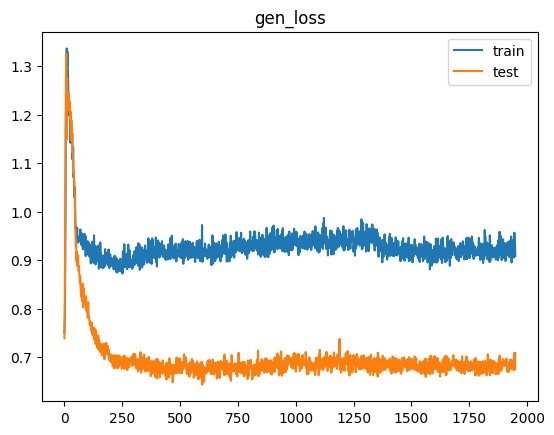

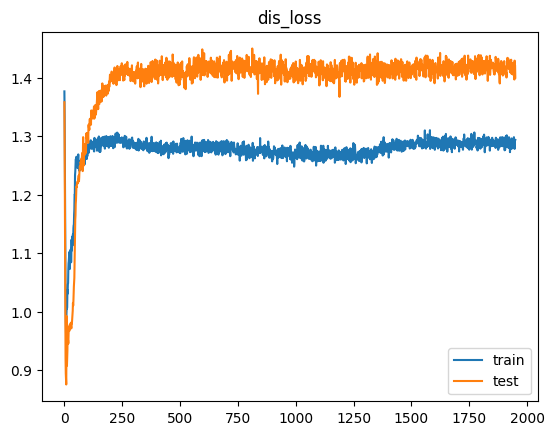

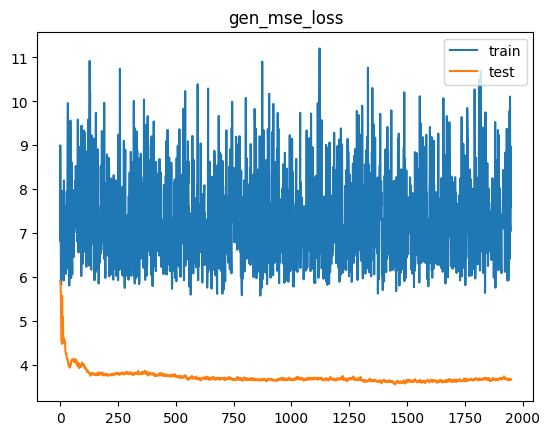

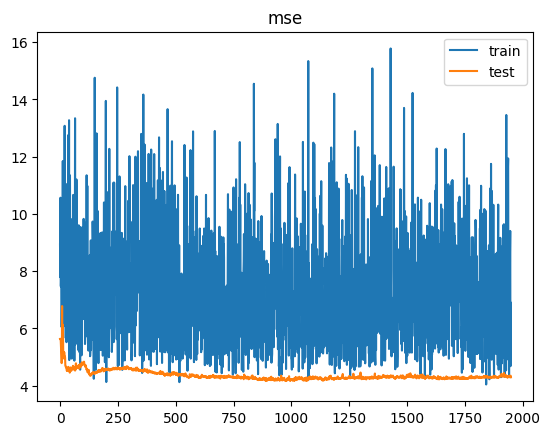

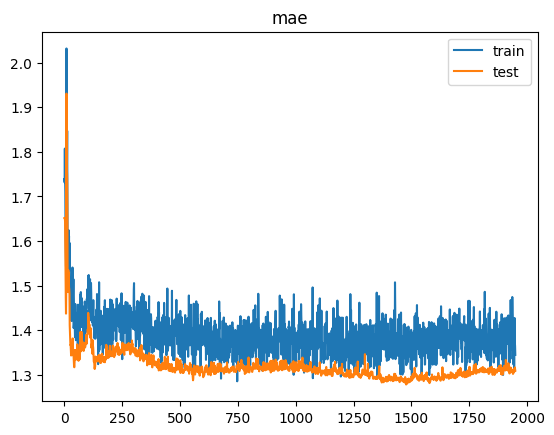

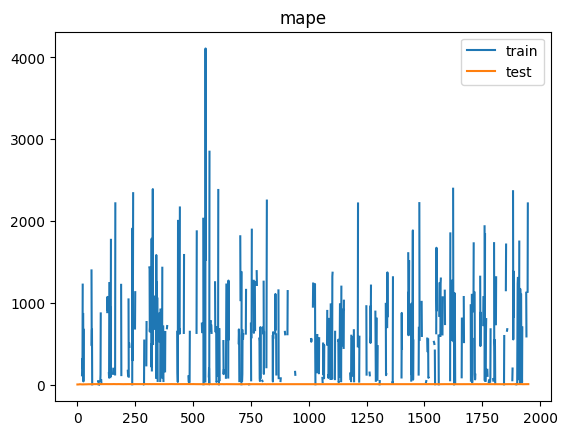

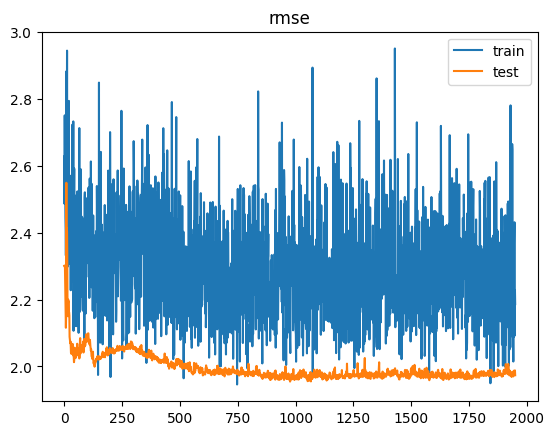

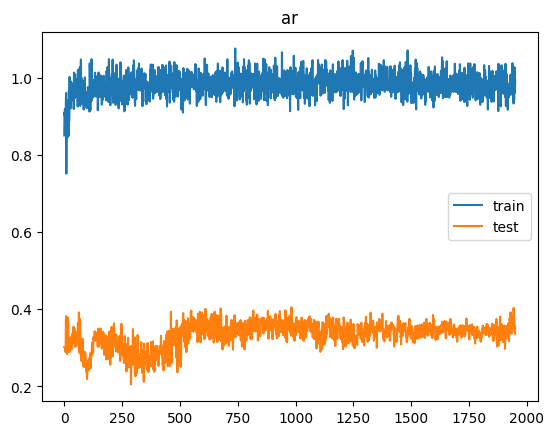

2/2 [==============================] - 0s 6ms/step


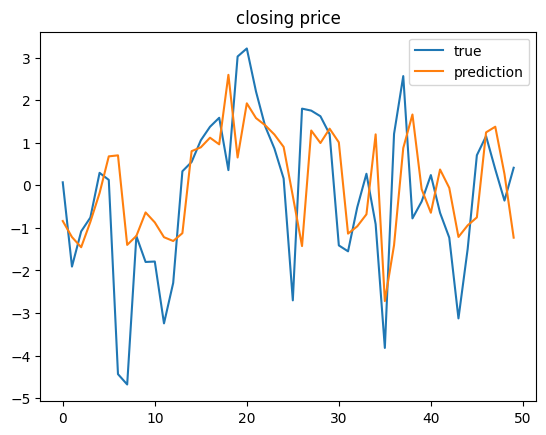

[MSE Baseline] train: 8.00881000374697  test: 4.16723565376744
Delta time with epochs = 1950: 0:38:09.726461


In [20]:
for epochs in [1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))